In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.final_preprocessing import serve_data, serve_data_sine, serve_data_kmeans

from models.transformer_encoder import TransEncoder

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visualize_all_customers, visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Parameters

In [3]:
config_path = "./config_transcoder.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [4]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data_kmeans(seq_len, batch_size_config)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


(13129, 10, 12)


In [5]:
# train_loader, test_loader, features , test_data = serve_data_sine(batch_size_config, seq_len)
# cond_features = 10

In [6]:
# train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["re"],seq_len=seq_len, batch_size=batch_size_config)

# Model

In [7]:
model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device, seq_len=seq_len)
    
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Train

In [8]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, None)
        loss.backward()
        
        optim.step()
        
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  0%|          | 1/2000 [00:06<3:43:24,  6.71s/it]

Epoch: 1, Epoch Loss: 0.6458, RMSE: 0.6013


  0%|          | 2/2000 [00:07<1:51:16,  3.34s/it]

Epoch: 2, Epoch Loss: 0.3834


  0%|          | 3/2000 [00:08<1:15:19,  2.26s/it]

Epoch: 3, Epoch Loss: 0.3458


  0%|          | 4/2000 [00:09<58:21,  1.75s/it]  

Epoch: 4, Epoch Loss: 0.3278


  0%|          | 5/2000 [00:10<48:54,  1.47s/it]

Epoch: 5, Epoch Loss: 0.3088


  0%|          | 6/2000 [00:16<1:40:22,  3.02s/it]

Epoch: 6, Epoch Loss: 0.2950, RMSE: 0.5828


  0%|          | 7/2000 [00:17<1:18:01,  2.35s/it]

Epoch: 7, Epoch Loss: 0.2870


  0%|          | 8/2000 [00:18<1:03:20,  1.91s/it]

Epoch: 8, Epoch Loss: 0.2776


  0%|          | 9/2000 [00:19<53:32,  1.61s/it]  

Epoch: 9, Epoch Loss: 0.2701


  0%|          | 10/2000 [00:20<46:52,  1.41s/it]

Epoch: 10, Epoch Loss: 0.2666


  1%|          | 11/2000 [00:26<1:33:57,  2.83s/it]

Epoch: 11, Epoch Loss: 0.2585, RMSE: 0.5810


  1%|          | 12/2000 [00:27<1:15:07,  2.27s/it]

Epoch: 12, Epoch Loss: 0.2585


  1%|          | 13/2000 [00:28<1:02:02,  1.87s/it]

Epoch: 13, Epoch Loss: 0.2532


  1%|          | 14/2000 [00:29<52:56,  1.60s/it]  

Epoch: 14, Epoch Loss: 0.2513


  1%|          | 15/2000 [00:30<46:37,  1.41s/it]

Epoch: 15, Epoch Loss: 0.2440


  1%|          | 16/2000 [00:36<1:33:02,  2.81s/it]

Epoch: 16, Epoch Loss: 0.2462, RMSE: 0.5706


  1%|          | 17/2000 [00:37<1:14:48,  2.26s/it]

Epoch: 17, Epoch Loss: 0.2445


  1%|          | 18/2000 [00:38<1:01:57,  1.88s/it]

Epoch: 18, Epoch Loss: 0.2402


  1%|          | 19/2000 [00:39<52:56,  1.60s/it]  

Epoch: 19, Epoch Loss: 0.2419


  1%|          | 20/2000 [00:40<46:45,  1.42s/it]

Epoch: 20, Epoch Loss: 0.2380


  1%|          | 21/2000 [00:46<1:32:59,  2.82s/it]

Epoch: 21, Epoch Loss: 0.2369, RMSE: 0.5909


  1%|          | 22/2000 [00:47<1:14:39,  2.26s/it]

Epoch: 22, Epoch Loss: 0.2369


  1%|          | 23/2000 [00:48<1:01:50,  1.88s/it]

Epoch: 23, Epoch Loss: 0.2371


  1%|          | 24/2000 [00:49<52:55,  1.61s/it]  

Epoch: 24, Epoch Loss: 0.2333


  1%|▏         | 25/2000 [00:50<46:40,  1.42s/it]

Epoch: 25, Epoch Loss: 0.2329


  1%|▏         | 26/2000 [00:56<1:32:58,  2.83s/it]

Epoch: 26, Epoch Loss: 0.2312, RMSE: 0.5859


  1%|▏         | 27/2000 [00:57<1:14:35,  2.27s/it]

Epoch: 27, Epoch Loss: 0.2315


  1%|▏         | 28/2000 [00:58<1:01:46,  1.88s/it]

Epoch: 28, Epoch Loss: 0.2341


  1%|▏         | 29/2000 [00:59<52:46,  1.61s/it]  

Epoch: 29, Epoch Loss: 0.2298


  2%|▏         | 30/2000 [01:00<46:28,  1.42s/it]

Epoch: 30, Epoch Loss: 0.2278


  2%|▏         | 31/2000 [01:06<1:32:47,  2.83s/it]

Epoch: 31, Epoch Loss: 0.2278, RMSE: 0.5766


  2%|▏         | 32/2000 [01:07<1:14:31,  2.27s/it]

Epoch: 32, Epoch Loss: 0.2286


  2%|▏         | 33/2000 [01:08<1:01:42,  1.88s/it]

Epoch: 33, Epoch Loss: 0.2259


  2%|▏         | 34/2000 [01:09<52:45,  1.61s/it]  

Epoch: 34, Epoch Loss: 0.2265


  2%|▏         | 35/2000 [01:10<46:31,  1.42s/it]

Epoch: 35, Epoch Loss: 0.2274


  2%|▏         | 36/2000 [01:16<1:32:41,  2.83s/it]

Epoch: 36, Epoch Loss: 0.2278, RMSE: 0.5942


  2%|▏         | 37/2000 [01:17<1:14:25,  2.27s/it]

Epoch: 37, Epoch Loss: 0.2262


  2%|▏         | 38/2000 [01:18<1:01:37,  1.88s/it]

Epoch: 38, Epoch Loss: 0.2242


  2%|▏         | 39/2000 [01:19<52:39,  1.61s/it]  

Epoch: 39, Epoch Loss: 0.2243


  2%|▏         | 40/2000 [01:20<46:24,  1.42s/it]

Epoch: 40, Epoch Loss: 0.2249


  2%|▏         | 41/2000 [01:26<1:32:25,  2.83s/it]

Epoch: 41, Epoch Loss: 0.2269, RMSE: 0.5992


  2%|▏         | 42/2000 [01:27<1:14:14,  2.28s/it]

Epoch: 42, Epoch Loss: 0.2235


  2%|▏         | 43/2000 [01:28<1:01:30,  1.89s/it]

Epoch: 43, Epoch Loss: 0.2248


  2%|▏         | 44/2000 [01:29<52:35,  1.61s/it]  

Epoch: 44, Epoch Loss: 0.2201


  2%|▏         | 45/2000 [01:30<46:19,  1.42s/it]

Epoch: 45, Epoch Loss: 0.2209


  2%|▏         | 46/2000 [01:36<1:32:17,  2.83s/it]

Epoch: 46, Epoch Loss: 0.2224, RMSE: 0.5773


  2%|▏         | 47/2000 [01:37<1:14:07,  2.28s/it]

Epoch: 47, Epoch Loss: 0.2249


  2%|▏         | 48/2000 [01:38<1:01:21,  1.89s/it]

Epoch: 48, Epoch Loss: 0.2202


  2%|▏         | 49/2000 [01:39<52:26,  1.61s/it]  

Epoch: 49, Epoch Loss: 0.2197


  2%|▎         | 50/2000 [01:40<46:13,  1.42s/it]

Epoch: 50, Epoch Loss: 0.2206


  3%|▎         | 51/2000 [01:46<1:33:31,  2.88s/it]

Epoch: 51, Epoch Loss: 0.2187, RMSE: 0.5824


  3%|▎         | 52/2000 [01:47<1:14:55,  2.31s/it]

Epoch: 52, Epoch Loss: 0.2235


  3%|▎         | 53/2000 [01:48<1:01:53,  1.91s/it]

Epoch: 53, Epoch Loss: 0.2213


  3%|▎         | 54/2000 [01:49<52:46,  1.63s/it]  

Epoch: 54, Epoch Loss: 0.2172


  3%|▎         | 55/2000 [01:50<46:24,  1.43s/it]

Epoch: 55, Epoch Loss: 0.2204


  3%|▎         | 56/2000 [01:56<1:33:46,  2.89s/it]

Epoch: 56, Epoch Loss: 0.2187, RMSE: 0.5990


  3%|▎         | 57/2000 [01:57<1:15:04,  2.32s/it]

Epoch: 57, Epoch Loss: 0.2176


  3%|▎         | 58/2000 [01:58<1:02:00,  1.92s/it]

Epoch: 58, Epoch Loss: 0.2204


  3%|▎         | 59/2000 [01:59<52:51,  1.63s/it]  

Epoch: 59, Epoch Loss: 0.2183


  3%|▎         | 60/2000 [02:00<46:28,  1.44s/it]

Epoch: 60, Epoch Loss: 0.2195


  3%|▎         | 61/2000 [02:07<1:32:07,  2.85s/it]

Epoch: 61, Epoch Loss: 0.2171, RMSE: 0.5919


  3%|▎         | 62/2000 [02:08<1:14:00,  2.29s/it]

Epoch: 62, Epoch Loss: 0.2211


  3%|▎         | 63/2000 [02:09<1:01:17,  1.90s/it]

Epoch: 63, Epoch Loss: 0.2191


  3%|▎         | 64/2000 [02:09<52:24,  1.62s/it]  

Epoch: 64, Epoch Loss: 0.2183


  3%|▎         | 65/2000 [02:10<46:11,  1.43s/it]

Epoch: 65, Epoch Loss: 0.2158


  3%|▎         | 66/2000 [02:17<1:31:47,  2.85s/it]

Epoch: 66, Epoch Loss: 0.2138, RMSE: 0.6000


  3%|▎         | 67/2000 [02:18<1:13:44,  2.29s/it]

Epoch: 67, Epoch Loss: 0.2153


  3%|▎         | 68/2000 [02:19<1:01:04,  1.90s/it]

Epoch: 68, Epoch Loss: 0.2150


  3%|▎         | 69/2000 [02:20<52:12,  1.62s/it]  

Epoch: 69, Epoch Loss: 0.2168


  4%|▎         | 70/2000 [02:21<45:57,  1.43s/it]

Epoch: 70, Epoch Loss: 0.2164


  4%|▎         | 71/2000 [02:27<1:31:27,  2.84s/it]

Epoch: 71, Epoch Loss: 0.2147, RMSE: 0.5869


  4%|▎         | 72/2000 [02:28<1:13:27,  2.29s/it]

Epoch: 72, Epoch Loss: 0.2168


  4%|▎         | 73/2000 [02:29<1:00:49,  1.89s/it]

Epoch: 73, Epoch Loss: 0.2178


  4%|▎         | 74/2000 [02:30<51:57,  1.62s/it]  

Epoch: 74, Epoch Loss: 0.2163


  4%|▍         | 75/2000 [02:31<45:47,  1.43s/it]

Epoch: 75, Epoch Loss: 0.2139


  4%|▍         | 76/2000 [02:37<1:31:15,  2.85s/it]

Epoch: 76, Epoch Loss: 0.2138, RMSE: 0.5957


  4%|▍         | 77/2000 [02:38<1:13:19,  2.29s/it]

Epoch: 77, Epoch Loss: 0.2136


  4%|▍         | 78/2000 [02:39<1:00:45,  1.90s/it]

Epoch: 78, Epoch Loss: 0.2179


  4%|▍         | 79/2000 [02:40<51:55,  1.62s/it]  

Epoch: 79, Epoch Loss: 0.2143


  4%|▍         | 80/2000 [02:41<45:42,  1.43s/it]

Epoch: 80, Epoch Loss: 0.2136


  4%|▍         | 81/2000 [02:47<1:31:00,  2.85s/it]

Epoch: 81, Epoch Loss: 0.2106, RMSE: 0.5991


  4%|▍         | 82/2000 [02:48<1:13:07,  2.29s/it]

Epoch: 82, Epoch Loss: 0.2129


  4%|▍         | 83/2000 [02:49<1:00:35,  1.90s/it]

Epoch: 83, Epoch Loss: 0.2129


  4%|▍         | 84/2000 [02:50<51:48,  1.62s/it]  

Epoch: 84, Epoch Loss: 0.2148


  4%|▍         | 85/2000 [02:51<45:40,  1.43s/it]

Epoch: 85, Epoch Loss: 0.2125


  4%|▍         | 86/2000 [02:57<1:30:55,  2.85s/it]

Epoch: 86, Epoch Loss: 0.2145, RMSE: 0.5857


  4%|▍         | 87/2000 [02:58<1:12:58,  2.29s/it]

Epoch: 87, Epoch Loss: 0.2134


  4%|▍         | 88/2000 [02:59<1:00:26,  1.90s/it]

Epoch: 88, Epoch Loss: 0.2113


  4%|▍         | 89/2000 [03:00<51:40,  1.62s/it]  

Epoch: 89, Epoch Loss: 0.2123


  4%|▍         | 90/2000 [03:01<45:32,  1.43s/it]

Epoch: 90, Epoch Loss: 0.2138


  5%|▍         | 91/2000 [03:07<1:30:38,  2.85s/it]

Epoch: 91, Epoch Loss: 0.2134, RMSE: 0.5729


  5%|▍         | 92/2000 [03:08<1:12:42,  2.29s/it]

Epoch: 92, Epoch Loss: 0.2143


  5%|▍         | 93/2000 [03:09<1:00:10,  1.89s/it]

Epoch: 93, Epoch Loss: 0.2130


  5%|▍         | 94/2000 [03:10<51:23,  1.62s/it]  

Epoch: 94, Epoch Loss: 0.2089


  5%|▍         | 95/2000 [03:11<45:17,  1.43s/it]

Epoch: 95, Epoch Loss: 0.2108


  5%|▍         | 96/2000 [03:17<1:30:21,  2.85s/it]

Epoch: 96, Epoch Loss: 0.2123, RMSE: 0.5824


  5%|▍         | 97/2000 [03:18<1:12:34,  2.29s/it]

Epoch: 97, Epoch Loss: 0.2102


  5%|▍         | 98/2000 [03:19<1:00:06,  1.90s/it]

Epoch: 98, Epoch Loss: 0.2113


  5%|▍         | 99/2000 [03:20<51:22,  1.62s/it]  

Epoch: 99, Epoch Loss: 0.2117


  5%|▌         | 100/2000 [03:21<45:11,  1.43s/it]

Epoch: 100, Epoch Loss: 0.2115


  5%|▌         | 101/2000 [03:27<1:30:46,  2.87s/it]

Epoch: 101, Epoch Loss: 0.2099, RMSE: 0.5918


  5%|▌         | 102/2000 [03:28<1:12:48,  2.30s/it]

Epoch: 102, Epoch Loss: 0.2119


  5%|▌         | 103/2000 [03:29<1:00:12,  1.90s/it]

Epoch: 103, Epoch Loss: 0.2090


  5%|▌         | 104/2000 [03:30<51:25,  1.63s/it]  

Epoch: 104, Epoch Loss: 0.2109


  5%|▌         | 105/2000 [03:31<45:14,  1.43s/it]

Epoch: 105, Epoch Loss: 0.2137


  5%|▌         | 106/2000 [03:37<1:30:00,  2.85s/it]

Epoch: 106, Epoch Loss: 0.2113, RMSE: 0.5830


  5%|▌         | 107/2000 [03:38<1:12:56,  2.31s/it]

Epoch: 107, Epoch Loss: 0.2124


  5%|▌         | 108/2000 [03:39<1:00:18,  1.91s/it]

Epoch: 108, Epoch Loss: 0.2119


  5%|▌         | 109/2000 [03:40<51:27,  1.63s/it]  

Epoch: 109, Epoch Loss: 0.2081


  6%|▌         | 110/2000 [03:41<45:14,  1.44s/it]

Epoch: 110, Epoch Loss: 0.2120


  6%|▌         | 111/2000 [03:47<1:29:53,  2.86s/it]

Epoch: 111, Epoch Loss: 0.2103, RMSE: 0.5855


  6%|▌         | 112/2000 [03:48<1:12:12,  2.29s/it]

Epoch: 112, Epoch Loss: 0.2077


  6%|▌         | 113/2000 [03:49<59:48,  1.90s/it]  

Epoch: 113, Epoch Loss: 0.2108


  6%|▌         | 114/2000 [03:50<51:07,  1.63s/it]

Epoch: 114, Epoch Loss: 0.2109


  6%|▌         | 115/2000 [03:51<45:11,  1.44s/it]

Epoch: 115, Epoch Loss: 0.2103


  6%|▌         | 116/2000 [03:58<1:29:51,  2.86s/it]

Epoch: 116, Epoch Loss: 0.2074, RMSE: 0.5783


  6%|▌         | 117/2000 [03:59<1:12:04,  2.30s/it]

Epoch: 117, Epoch Loss: 0.2092


  6%|▌         | 118/2000 [04:00<59:41,  1.90s/it]  

Epoch: 118, Epoch Loss: 0.2112


  6%|▌         | 119/2000 [04:01<52:33,  1.68s/it]

Epoch: 119, Epoch Loss: 0.2070


  6%|▌         | 120/2000 [04:02<45:59,  1.47s/it]

Epoch: 120, Epoch Loss: 0.2106


  6%|▌         | 121/2000 [04:08<1:30:00,  2.87s/it]

Epoch: 121, Epoch Loss: 0.2109, RMSE: 0.5793


  6%|▌         | 122/2000 [04:09<1:12:15,  2.31s/it]

Epoch: 122, Epoch Loss: 0.2116


  6%|▌         | 123/2000 [04:10<59:49,  1.91s/it]  

Epoch: 123, Epoch Loss: 0.2082


  6%|▌         | 124/2000 [04:11<51:07,  1.64s/it]

Epoch: 124, Epoch Loss: 0.2096


  6%|▋         | 125/2000 [04:12<45:00,  1.44s/it]

Epoch: 125, Epoch Loss: 0.2093


  6%|▋         | 126/2000 [04:18<1:29:19,  2.86s/it]

Epoch: 126, Epoch Loss: 0.2100, RMSE: 0.5816


  6%|▋         | 127/2000 [04:19<1:11:44,  2.30s/it]

Epoch: 127, Epoch Loss: 0.2125


  6%|▋         | 128/2000 [04:20<59:22,  1.90s/it]  

Epoch: 128, Epoch Loss: 0.2115


  6%|▋         | 129/2000 [04:21<50:42,  1.63s/it]

Epoch: 129, Epoch Loss: 0.2091


  6%|▋         | 130/2000 [04:22<44:39,  1.43s/it]

Epoch: 130, Epoch Loss: 0.2084


  7%|▋         | 131/2000 [04:28<1:28:51,  2.85s/it]

Epoch: 131, Epoch Loss: 0.2072, RMSE: 0.5938


  7%|▋         | 132/2000 [04:29<1:11:21,  2.29s/it]

Epoch: 132, Epoch Loss: 0.2105


  7%|▋         | 133/2000 [04:30<59:05,  1.90s/it]  

Epoch: 133, Epoch Loss: 0.2090


  7%|▋         | 134/2000 [04:31<50:31,  1.62s/it]

Epoch: 134, Epoch Loss: 0.2077


  7%|▋         | 135/2000 [04:32<44:32,  1.43s/it]

Epoch: 135, Epoch Loss: 0.2090


  7%|▋         | 136/2000 [04:38<1:28:38,  2.85s/it]

Epoch: 136, Epoch Loss: 0.2067, RMSE: 0.5890


  7%|▋         | 137/2000 [04:39<1:11:11,  2.29s/it]

Epoch: 137, Epoch Loss: 0.2073


  7%|▋         | 138/2000 [04:40<58:58,  1.90s/it]  

Epoch: 138, Epoch Loss: 0.2089


  7%|▋         | 139/2000 [04:41<50:22,  1.62s/it]

Epoch: 139, Epoch Loss: 0.2088


  7%|▋         | 140/2000 [04:42<44:22,  1.43s/it]

Epoch: 140, Epoch Loss: 0.2094


  7%|▋         | 141/2000 [04:48<1:28:20,  2.85s/it]

Epoch: 141, Epoch Loss: 0.2092, RMSE: 0.5844


  7%|▋         | 142/2000 [04:49<1:10:57,  2.29s/it]

Epoch: 142, Epoch Loss: 0.2081


  7%|▋         | 143/2000 [04:50<58:46,  1.90s/it]  

Epoch: 143, Epoch Loss: 0.2062


  7%|▋         | 144/2000 [04:51<50:13,  1.62s/it]

Epoch: 144, Epoch Loss: 0.2078


  7%|▋         | 145/2000 [04:52<44:12,  1.43s/it]

Epoch: 145, Epoch Loss: 0.2082


  7%|▋         | 146/2000 [04:58<1:28:03,  2.85s/it]

Epoch: 146, Epoch Loss: 0.2088, RMSE: 0.5901


  7%|▋         | 147/2000 [04:59<1:10:45,  2.29s/it]

Epoch: 147, Epoch Loss: 0.2090


  7%|▋         | 148/2000 [05:00<58:36,  1.90s/it]  

Epoch: 148, Epoch Loss: 0.2058


  7%|▋         | 149/2000 [05:01<50:06,  1.62s/it]

Epoch: 149, Epoch Loss: 0.2091


  8%|▊         | 150/2000 [05:02<44:07,  1.43s/it]

Epoch: 150, Epoch Loss: 0.2071


  8%|▊         | 151/2000 [05:09<1:28:28,  2.87s/it]

Epoch: 151, Epoch Loss: 0.2071, RMSE: 0.5797


  8%|▊         | 152/2000 [05:10<1:10:59,  2.30s/it]

Epoch: 152, Epoch Loss: 0.2054


  8%|▊         | 153/2000 [05:11<58:45,  1.91s/it]  

Epoch: 153, Epoch Loss: 0.2051


  8%|▊         | 154/2000 [05:12<50:13,  1.63s/it]

Epoch: 154, Epoch Loss: 0.2066


  8%|▊         | 155/2000 [05:12<44:14,  1.44s/it]

Epoch: 155, Epoch Loss: 0.2073


  8%|▊         | 156/2000 [05:19<1:27:55,  2.86s/it]

Epoch: 156, Epoch Loss: 0.2077, RMSE: 0.5783


  8%|▊         | 157/2000 [05:20<1:10:35,  2.30s/it]

Epoch: 157, Epoch Loss: 0.2046


  8%|▊         | 158/2000 [05:21<58:26,  1.90s/it]  

Epoch: 158, Epoch Loss: 0.2072


  8%|▊         | 159/2000 [05:22<49:57,  1.63s/it]

Epoch: 159, Epoch Loss: 0.2083


  8%|▊         | 160/2000 [05:23<44:01,  1.44s/it]

Epoch: 160, Epoch Loss: 0.2062


  8%|▊         | 161/2000 [05:29<1:27:29,  2.85s/it]

Epoch: 161, Epoch Loss: 0.2079, RMSE: 0.5841


  8%|▊         | 162/2000 [05:30<1:10:13,  2.29s/it]

Epoch: 162, Epoch Loss: 0.2065


  8%|▊         | 163/2000 [05:31<58:06,  1.90s/it]  

Epoch: 163, Epoch Loss: 0.2077


  8%|▊         | 164/2000 [05:32<49:39,  1.62s/it]

Epoch: 164, Epoch Loss: 0.2060


  8%|▊         | 165/2000 [05:33<43:41,  1.43s/it]

Epoch: 165, Epoch Loss: 0.2056


  8%|▊         | 166/2000 [05:39<1:27:10,  2.85s/it]

Epoch: 166, Epoch Loss: 0.2056, RMSE: 0.5764


  8%|▊         | 167/2000 [05:40<1:10:00,  2.29s/it]

Epoch: 167, Epoch Loss: 0.2072


  8%|▊         | 168/2000 [05:41<57:59,  1.90s/it]  

Epoch: 168, Epoch Loss: 0.2072


  8%|▊         | 169/2000 [05:42<49:38,  1.63s/it]

Epoch: 169, Epoch Loss: 0.2071


  8%|▊         | 170/2000 [05:43<43:40,  1.43s/it]

Epoch: 170, Epoch Loss: 0.2049


  9%|▊         | 171/2000 [05:49<1:27:01,  2.86s/it]

Epoch: 171, Epoch Loss: 0.2069, RMSE: 0.5674


  9%|▊         | 172/2000 [05:50<1:09:49,  2.29s/it]

Epoch: 172, Epoch Loss: 0.2101


  9%|▊         | 173/2000 [05:51<57:49,  1.90s/it]  

Epoch: 173, Epoch Loss: 0.2075


  9%|▊         | 174/2000 [05:52<49:25,  1.62s/it]

Epoch: 174, Epoch Loss: 0.2062


  9%|▉         | 175/2000 [05:53<43:31,  1.43s/it]

Epoch: 175, Epoch Loss: 0.2078


  9%|▉         | 176/2000 [05:59<1:26:45,  2.85s/it]

Epoch: 176, Epoch Loss: 0.2039, RMSE: 0.5896


  9%|▉         | 177/2000 [06:00<1:09:41,  2.29s/it]

Epoch: 177, Epoch Loss: 0.2057


  9%|▉         | 178/2000 [06:01<57:42,  1.90s/it]  

Epoch: 178, Epoch Loss: 0.2084


  9%|▉         | 179/2000 [06:02<49:18,  1.62s/it]

Epoch: 179, Epoch Loss: 0.2068


  9%|▉         | 180/2000 [06:03<43:24,  1.43s/it]

Epoch: 180, Epoch Loss: 0.2047


  9%|▉         | 181/2000 [06:09<1:26:29,  2.85s/it]

Epoch: 181, Epoch Loss: 0.2049, RMSE: 0.5823


  9%|▉         | 182/2000 [06:10<1:10:53,  2.34s/it]

Epoch: 182, Epoch Loss: 0.2072


  9%|▉         | 183/2000 [06:11<58:30,  1.93s/it]  

Epoch: 183, Epoch Loss: 0.2055


  9%|▉         | 184/2000 [06:12<49:51,  1.65s/it]

Epoch: 184, Epoch Loss: 0.2056


  9%|▉         | 185/2000 [06:13<43:47,  1.45s/it]

Epoch: 185, Epoch Loss: 0.2053


  9%|▉         | 186/2000 [06:19<1:26:38,  2.87s/it]

Epoch: 186, Epoch Loss: 0.2051, RMSE: 0.5857


  9%|▉         | 187/2000 [06:20<1:09:29,  2.30s/it]

Epoch: 187, Epoch Loss: 0.2029


  9%|▉         | 188/2000 [06:21<57:32,  1.91s/it]  

Epoch: 188, Epoch Loss: 0.2035


  9%|▉         | 189/2000 [06:22<49:10,  1.63s/it]

Epoch: 189, Epoch Loss: 0.2077


 10%|▉         | 190/2000 [06:23<43:18,  1.44s/it]

Epoch: 190, Epoch Loss: 0.2083


 10%|▉         | 191/2000 [06:30<1:26:13,  2.86s/it]

Epoch: 191, Epoch Loss: 0.2067, RMSE: 0.5921


 10%|▉         | 192/2000 [06:31<1:09:12,  2.30s/it]

Epoch: 192, Epoch Loss: 0.2048


 10%|▉         | 193/2000 [06:32<57:14,  1.90s/it]  

Epoch: 193, Epoch Loss: 0.2068


 10%|▉         | 194/2000 [06:32<48:52,  1.62s/it]

Epoch: 194, Epoch Loss: 0.2033


 10%|▉         | 195/2000 [06:33<43:00,  1.43s/it]

Epoch: 195, Epoch Loss: 0.2068


 10%|▉         | 196/2000 [06:40<1:25:46,  2.85s/it]

Epoch: 196, Epoch Loss: 0.2053, RMSE: 0.5757


 10%|▉         | 197/2000 [06:41<1:08:50,  2.29s/it]

Epoch: 197, Epoch Loss: 0.2055


 10%|▉         | 198/2000 [06:42<56:59,  1.90s/it]  

Epoch: 198, Epoch Loss: 0.2073


 10%|▉         | 199/2000 [06:43<48:41,  1.62s/it]

Epoch: 199, Epoch Loss: 0.2073


 10%|█         | 200/2000 [06:44<42:53,  1.43s/it]

Epoch: 200, Epoch Loss: 0.2051


 10%|█         | 201/2000 [06:50<1:26:02,  2.87s/it]

Epoch: 201, Epoch Loss: 0.2059, RMSE: 0.5772


 10%|█         | 202/2000 [06:51<1:09:03,  2.30s/it]

Epoch: 202, Epoch Loss: 0.2050


 10%|█         | 203/2000 [06:52<57:07,  1.91s/it]  

Epoch: 203, Epoch Loss: 0.2044


 10%|█         | 204/2000 [06:53<48:45,  1.63s/it]

Epoch: 204, Epoch Loss: 0.2054


 10%|█         | 205/2000 [06:54<42:55,  1.43s/it]

Epoch: 205, Epoch Loss: 0.2046


 10%|█         | 206/2000 [07:00<1:25:27,  2.86s/it]

Epoch: 206, Epoch Loss: 0.2057, RMSE: 0.5849


 10%|█         | 207/2000 [07:01<1:08:38,  2.30s/it]

Epoch: 207, Epoch Loss: 0.2067


 10%|█         | 208/2000 [07:02<56:47,  1.90s/it]  

Epoch: 208, Epoch Loss: 0.2065


 10%|█         | 209/2000 [07:03<48:30,  1.63s/it]

Epoch: 209, Epoch Loss: 0.2026


 10%|█         | 210/2000 [07:04<42:42,  1.43s/it]

Epoch: 210, Epoch Loss: 0.2044


 11%|█         | 211/2000 [07:10<1:25:06,  2.85s/it]

Epoch: 211, Epoch Loss: 0.2038, RMSE: 0.5717


 11%|█         | 212/2000 [07:11<1:08:23,  2.30s/it]

Epoch: 212, Epoch Loss: 0.2053


 11%|█         | 213/2000 [07:12<56:37,  1.90s/it]  

Epoch: 213, Epoch Loss: 0.2040


 11%|█         | 214/2000 [07:13<48:24,  1.63s/it]

Epoch: 214, Epoch Loss: 0.2065


 11%|█         | 215/2000 [07:14<42:36,  1.43s/it]

Epoch: 215, Epoch Loss: 0.2052


 11%|█         | 216/2000 [07:20<1:25:05,  2.86s/it]

Epoch: 216, Epoch Loss: 0.2029, RMSE: 0.5894


 11%|█         | 217/2000 [07:21<1:08:20,  2.30s/it]

Epoch: 217, Epoch Loss: 0.2061


 11%|█         | 218/2000 [07:22<56:44,  1.91s/it]  

Epoch: 218, Epoch Loss: 0.2066


 11%|█         | 219/2000 [07:23<48:57,  1.65s/it]

Epoch: 219, Epoch Loss: 0.2061


 11%|█         | 220/2000 [07:24<43:19,  1.46s/it]

Epoch: 220, Epoch Loss: 0.2030


 11%|█         | 221/2000 [07:30<1:26:21,  2.91s/it]

Epoch: 221, Epoch Loss: 0.2072, RMSE: 0.5883


 11%|█         | 222/2000 [07:31<1:09:21,  2.34s/it]

Epoch: 222, Epoch Loss: 0.2049


 11%|█         | 223/2000 [07:32<57:24,  1.94s/it]  

Epoch: 223, Epoch Loss: 0.2053


 11%|█         | 224/2000 [07:33<49:04,  1.66s/it]

Epoch: 224, Epoch Loss: 0.2033


 11%|█▏        | 225/2000 [07:34<43:10,  1.46s/it]

Epoch: 225, Epoch Loss: 0.2057


 11%|█▏        | 226/2000 [07:41<1:26:04,  2.91s/it]

Epoch: 226, Epoch Loss: 0.2032, RMSE: 0.5846


 11%|█▏        | 227/2000 [07:42<1:09:00,  2.34s/it]

Epoch: 227, Epoch Loss: 0.2076


 11%|█▏        | 228/2000 [07:43<57:05,  1.93s/it]  

Epoch: 228, Epoch Loss: 0.2025


 11%|█▏        | 229/2000 [07:44<48:38,  1.65s/it]

Epoch: 229, Epoch Loss: 0.2028


 12%|█▏        | 230/2000 [07:45<42:45,  1.45s/it]

Epoch: 230, Epoch Loss: 0.2028


 12%|█▏        | 231/2000 [07:51<1:24:46,  2.88s/it]

Epoch: 231, Epoch Loss: 0.2022, RMSE: 0.5827


 12%|█▏        | 232/2000 [07:52<1:08:03,  2.31s/it]

Epoch: 232, Epoch Loss: 0.2047


 12%|█▏        | 233/2000 [07:53<56:21,  1.91s/it]  

Epoch: 233, Epoch Loss: 0.2046


 12%|█▏        | 234/2000 [07:54<48:08,  1.64s/it]

Epoch: 234, Epoch Loss: 0.2066


 12%|█▏        | 235/2000 [07:55<42:30,  1.45s/it]

Epoch: 235, Epoch Loss: 0.2029


 12%|█▏        | 236/2000 [08:01<1:24:22,  2.87s/it]

Epoch: 236, Epoch Loss: 0.2031, RMSE: 0.5899


 12%|█▏        | 237/2000 [08:02<1:07:47,  2.31s/it]

Epoch: 237, Epoch Loss: 0.2021


 12%|█▏        | 238/2000 [08:03<56:08,  1.91s/it]  

Epoch: 238, Epoch Loss: 0.2059


 12%|█▏        | 239/2000 [08:04<47:59,  1.64s/it]

Epoch: 239, Epoch Loss: 0.2061


 12%|█▏        | 240/2000 [08:05<42:18,  1.44s/it]

Epoch: 240, Epoch Loss: 0.2049


 12%|█▏        | 241/2000 [08:11<1:24:02,  2.87s/it]

Epoch: 241, Epoch Loss: 0.2054, RMSE: 0.5838


 12%|█▏        | 242/2000 [08:12<1:07:33,  2.31s/it]

Epoch: 242, Epoch Loss: 0.2024


 12%|█▏        | 243/2000 [08:13<56:00,  1.91s/it]  

Epoch: 243, Epoch Loss: 0.2063


 12%|█▏        | 244/2000 [08:14<47:53,  1.64s/it]

Epoch: 244, Epoch Loss: 0.2034


 12%|█▏        | 245/2000 [08:15<43:33,  1.49s/it]

Epoch: 245, Epoch Loss: 0.2032


 12%|█▏        | 246/2000 [08:22<1:24:47,  2.90s/it]

Epoch: 246, Epoch Loss: 0.2022, RMSE: 0.5739


 12%|█▏        | 247/2000 [08:23<1:07:59,  2.33s/it]

Epoch: 247, Epoch Loss: 0.2031


 12%|█▏        | 248/2000 [08:24<56:14,  1.93s/it]  

Epoch: 248, Epoch Loss: 0.2025


 12%|█▏        | 249/2000 [08:25<47:59,  1.64s/it]

Epoch: 249, Epoch Loss: 0.2047


 12%|█▎        | 250/2000 [08:26<42:11,  1.45s/it]

Epoch: 250, Epoch Loss: 0.2023


 13%|█▎        | 251/2000 [08:32<1:24:10,  2.89s/it]

Epoch: 251, Epoch Loss: 0.2051, RMSE: 0.5906


 13%|█▎        | 252/2000 [08:33<1:07:30,  2.32s/it]

Epoch: 252, Epoch Loss: 0.2027


 13%|█▎        | 253/2000 [08:34<55:50,  1.92s/it]  

Epoch: 253, Epoch Loss: 0.2030


 13%|█▎        | 254/2000 [08:35<47:40,  1.64s/it]

Epoch: 254, Epoch Loss: 0.2012


 13%|█▎        | 255/2000 [08:36<41:54,  1.44s/it]

Epoch: 255, Epoch Loss: 0.2014


 13%|█▎        | 256/2000 [08:42<1:23:07,  2.86s/it]

Epoch: 256, Epoch Loss: 0.2039, RMSE: 0.5761


 13%|█▎        | 257/2000 [08:43<1:06:43,  2.30s/it]

Epoch: 257, Epoch Loss: 0.2029


 13%|█▎        | 258/2000 [08:44<55:14,  1.90s/it]  

Epoch: 258, Epoch Loss: 0.2036


 13%|█▎        | 259/2000 [08:45<47:13,  1.63s/it]

Epoch: 259, Epoch Loss: 0.2017


 13%|█▎        | 260/2000 [08:46<41:35,  1.43s/it]

Epoch: 260, Epoch Loss: 0.2031


 13%|█▎        | 261/2000 [08:52<1:22:46,  2.86s/it]

Epoch: 261, Epoch Loss: 0.2036, RMSE: 0.5849


 13%|█▎        | 262/2000 [08:53<1:06:26,  2.29s/it]

Epoch: 262, Epoch Loss: 0.2030


 13%|█▎        | 263/2000 [08:54<55:02,  1.90s/it]  

Epoch: 263, Epoch Loss: 0.2044


 13%|█▎        | 264/2000 [08:55<47:07,  1.63s/it]

Epoch: 264, Epoch Loss: 0.2029


 13%|█▎        | 265/2000 [08:56<41:59,  1.45s/it]

Epoch: 265, Epoch Loss: 0.2029


 13%|█▎        | 266/2000 [09:02<1:22:53,  2.87s/it]

Epoch: 266, Epoch Loss: 0.2030, RMSE: 0.5956


 13%|█▎        | 267/2000 [09:03<1:06:29,  2.30s/it]

Epoch: 267, Epoch Loss: 0.2053


 13%|█▎        | 268/2000 [09:04<55:01,  1.91s/it]  

Epoch: 268, Epoch Loss: 0.2037


 13%|█▎        | 269/2000 [09:05<46:59,  1.63s/it]

Epoch: 269, Epoch Loss: 0.2027


 14%|█▎        | 270/2000 [09:06<41:23,  1.44s/it]

Epoch: 270, Epoch Loss: 0.2029


 14%|█▎        | 271/2000 [09:12<1:22:22,  2.86s/it]

Epoch: 271, Epoch Loss: 0.1994, RMSE: 0.5866


 14%|█▎        | 272/2000 [09:13<1:06:06,  2.30s/it]

Epoch: 272, Epoch Loss: 0.2052


 14%|█▎        | 273/2000 [09:14<54:41,  1.90s/it]  

Epoch: 273, Epoch Loss: 0.2054


 14%|█▎        | 274/2000 [09:15<46:42,  1.62s/it]

Epoch: 274, Epoch Loss: 0.2011


 14%|█▍        | 275/2000 [09:16<41:06,  1.43s/it]

Epoch: 275, Epoch Loss: 0.2030


 14%|█▍        | 276/2000 [09:22<1:22:00,  2.85s/it]

Epoch: 276, Epoch Loss: 0.2031, RMSE: 0.5811


 14%|█▍        | 277/2000 [09:23<1:05:51,  2.29s/it]

Epoch: 277, Epoch Loss: 0.2013


 14%|█▍        | 278/2000 [09:24<54:31,  1.90s/it]  

Epoch: 278, Epoch Loss: 0.2043


 14%|█▍        | 279/2000 [09:25<46:34,  1.62s/it]

Epoch: 279, Epoch Loss: 0.2016


 14%|█▍        | 280/2000 [09:26<40:59,  1.43s/it]

Epoch: 280, Epoch Loss: 0.2038


 14%|█▍        | 281/2000 [09:32<1:21:41,  2.85s/it]

Epoch: 281, Epoch Loss: 0.2022, RMSE: 0.5761


 14%|█▍        | 282/2000 [09:33<1:05:35,  2.29s/it]

Epoch: 282, Epoch Loss: 0.2014


 14%|█▍        | 283/2000 [09:34<54:20,  1.90s/it]  

Epoch: 283, Epoch Loss: 0.2036


 14%|█▍        | 284/2000 [09:35<46:27,  1.62s/it]

Epoch: 284, Epoch Loss: 0.2032


 14%|█▍        | 285/2000 [09:36<40:56,  1.43s/it]

Epoch: 285, Epoch Loss: 0.2073


 14%|█▍        | 286/2000 [09:43<1:21:31,  2.85s/it]

Epoch: 286, Epoch Loss: 0.2026, RMSE: 0.5723


 14%|█▍        | 287/2000 [09:44<1:05:27,  2.29s/it]

Epoch: 287, Epoch Loss: 0.2040


 14%|█▍        | 288/2000 [09:45<54:11,  1.90s/it]  

Epoch: 288, Epoch Loss: 0.2005


 14%|█▍        | 289/2000 [09:46<46:20,  1.63s/it]

Epoch: 289, Epoch Loss: 0.2037


 14%|█▍        | 290/2000 [09:47<40:49,  1.43s/it]

Epoch: 290, Epoch Loss: 0.2049


 15%|█▍        | 291/2000 [09:53<1:21:15,  2.85s/it]

Epoch: 291, Epoch Loss: 0.2033, RMSE: 0.5804


 15%|█▍        | 292/2000 [09:54<1:05:14,  2.29s/it]

Epoch: 292, Epoch Loss: 0.2029


 15%|█▍        | 293/2000 [09:55<54:03,  1.90s/it]  

Epoch: 293, Epoch Loss: 0.2002


 15%|█▍        | 294/2000 [09:56<46:12,  1.63s/it]

Epoch: 294, Epoch Loss: 0.2004


 15%|█▍        | 295/2000 [09:57<40:41,  1.43s/it]

Epoch: 295, Epoch Loss: 0.2012


 15%|█▍        | 296/2000 [10:03<1:21:05,  2.86s/it]

Epoch: 296, Epoch Loss: 0.2023, RMSE: 0.5872


 15%|█▍        | 297/2000 [10:04<1:05:10,  2.30s/it]

Epoch: 297, Epoch Loss: 0.2053


 15%|█▍        | 298/2000 [10:05<53:59,  1.90s/it]  

Epoch: 298, Epoch Loss: 0.2004


 15%|█▍        | 299/2000 [10:06<46:10,  1.63s/it]

Epoch: 299, Epoch Loss: 0.2039


 15%|█▌        | 300/2000 [10:07<40:41,  1.44s/it]

Epoch: 300, Epoch Loss: 0.1995


 15%|█▌        | 301/2000 [10:13<1:21:25,  2.88s/it]

Epoch: 301, Epoch Loss: 0.1993, RMSE: 0.5844


 15%|█▌        | 302/2000 [10:14<1:05:20,  2.31s/it]

Epoch: 302, Epoch Loss: 0.2024


 15%|█▌        | 303/2000 [10:15<54:03,  1.91s/it]  

Epoch: 303, Epoch Loss: 0.2021


 15%|█▌        | 304/2000 [10:16<46:10,  1.63s/it]

Epoch: 304, Epoch Loss: 0.2053


 15%|█▌        | 305/2000 [10:17<40:41,  1.44s/it]

Epoch: 305, Epoch Loss: 0.1997


 15%|█▌        | 306/2000 [10:23<1:20:47,  2.86s/it]

Epoch: 306, Epoch Loss: 0.2022, RMSE: 0.5736


 15%|█▌        | 307/2000 [10:24<1:04:50,  2.30s/it]

Epoch: 307, Epoch Loss: 0.2033


 15%|█▌        | 308/2000 [10:25<54:55,  1.95s/it]  

Epoch: 308, Epoch Loss: 0.2050


 15%|█▌        | 309/2000 [10:26<46:44,  1.66s/it]

Epoch: 309, Epoch Loss: 0.2030


 16%|█▌        | 310/2000 [10:27<41:02,  1.46s/it]

Epoch: 310, Epoch Loss: 0.2016


 16%|█▌        | 311/2000 [10:33<1:20:52,  2.87s/it]

Epoch: 311, Epoch Loss: 0.2011, RMSE: 0.5839


 16%|█▌        | 312/2000 [10:34<1:04:53,  2.31s/it]

Epoch: 312, Epoch Loss: 0.2037


 16%|█▌        | 313/2000 [10:35<53:42,  1.91s/it]  

Epoch: 313, Epoch Loss: 0.2023


 16%|█▌        | 314/2000 [10:36<45:50,  1.63s/it]

Epoch: 314, Epoch Loss: 0.2013


 16%|█▌        | 315/2000 [10:37<40:20,  1.44s/it]

Epoch: 315, Epoch Loss: 0.2014


 16%|█▌        | 316/2000 [10:43<1:20:13,  2.86s/it]

Epoch: 316, Epoch Loss: 0.2006, RMSE: 0.5788


 16%|█▌        | 317/2000 [10:44<1:04:25,  2.30s/it]

Epoch: 317, Epoch Loss: 0.2032


 16%|█▌        | 318/2000 [10:45<53:18,  1.90s/it]  

Epoch: 318, Epoch Loss: 0.2011


 16%|█▌        | 319/2000 [10:46<45:35,  1.63s/it]

Epoch: 319, Epoch Loss: 0.2030


 16%|█▌        | 320/2000 [10:47<40:10,  1.43s/it]

Epoch: 320, Epoch Loss: 0.2029


 16%|█▌        | 321/2000 [10:54<1:19:53,  2.85s/it]

Epoch: 321, Epoch Loss: 0.2017, RMSE: 0.5730


 16%|█▌        | 322/2000 [10:55<1:04:10,  2.29s/it]

Epoch: 322, Epoch Loss: 0.2023


 16%|█▌        | 323/2000 [10:56<53:09,  1.90s/it]  

Epoch: 323, Epoch Loss: 0.1990


 16%|█▌        | 324/2000 [10:57<45:27,  1.63s/it]

Epoch: 324, Epoch Loss: 0.2007


 16%|█▋        | 325/2000 [10:58<40:03,  1.43s/it]

Epoch: 325, Epoch Loss: 0.1990


 16%|█▋        | 326/2000 [11:04<1:19:44,  2.86s/it]

Epoch: 326, Epoch Loss: 0.2001, RMSE: 0.5793


 16%|█▋        | 327/2000 [11:05<1:04:01,  2.30s/it]

Epoch: 327, Epoch Loss: 0.2015


 16%|█▋        | 328/2000 [11:06<53:01,  1.90s/it]  

Epoch: 328, Epoch Loss: 0.2004


 16%|█▋        | 329/2000 [11:07<45:17,  1.63s/it]

Epoch: 329, Epoch Loss: 0.2032


 16%|█▋        | 330/2000 [11:08<39:56,  1.44s/it]

Epoch: 330, Epoch Loss: 0.1996


 17%|█▋        | 331/2000 [11:14<1:19:31,  2.86s/it]

Epoch: 331, Epoch Loss: 0.2006, RMSE: 0.5752


 17%|█▋        | 332/2000 [11:15<1:03:51,  2.30s/it]

Epoch: 332, Epoch Loss: 0.2012


 17%|█▋        | 333/2000 [11:16<52:55,  1.90s/it]  

Epoch: 333, Epoch Loss: 0.2015


 17%|█▋        | 334/2000 [11:17<45:12,  1.63s/it]

Epoch: 334, Epoch Loss: 0.1988


 17%|█▋        | 335/2000 [11:18<39:47,  1.43s/it]

Epoch: 335, Epoch Loss: 0.2004


 17%|█▋        | 336/2000 [11:24<1:19:20,  2.86s/it]

Epoch: 336, Epoch Loss: 0.2010, RMSE: 0.5766


 17%|█▋        | 337/2000 [11:25<1:03:47,  2.30s/it]

Epoch: 337, Epoch Loss: 0.2014


 17%|█▋        | 338/2000 [11:26<52:55,  1.91s/it]  

Epoch: 338, Epoch Loss: 0.1997


 17%|█▋        | 339/2000 [11:27<45:17,  1.64s/it]

Epoch: 339, Epoch Loss: 0.2017


 17%|█▋        | 340/2000 [11:28<40:06,  1.45s/it]

Epoch: 340, Epoch Loss: 0.2025


 17%|█▋        | 341/2000 [11:34<1:20:16,  2.90s/it]

Epoch: 341, Epoch Loss: 0.1999, RMSE: 0.5802


 17%|█▋        | 342/2000 [11:35<1:04:24,  2.33s/it]

Epoch: 342, Epoch Loss: 0.2008


 17%|█▋        | 343/2000 [11:36<53:18,  1.93s/it]  

Epoch: 343, Epoch Loss: 0.2001


 17%|█▋        | 344/2000 [11:37<45:33,  1.65s/it]

Epoch: 344, Epoch Loss: 0.2014


 17%|█▋        | 345/2000 [11:38<40:12,  1.46s/it]

Epoch: 345, Epoch Loss: 0.2003


 17%|█▋        | 346/2000 [11:45<1:19:58,  2.90s/it]

Epoch: 346, Epoch Loss: 0.1983, RMSE: 0.5848


 17%|█▋        | 347/2000 [11:46<1:04:16,  2.33s/it]

Epoch: 347, Epoch Loss: 0.2018


 17%|█▋        | 348/2000 [11:47<53:13,  1.93s/it]  

Epoch: 348, Epoch Loss: 0.2010


 17%|█▋        | 349/2000 [11:48<45:26,  1.65s/it]

Epoch: 349, Epoch Loss: 0.2013


 18%|█▊        | 350/2000 [11:49<39:59,  1.45s/it]

Epoch: 350, Epoch Loss: 0.2001


 18%|█▊        | 351/2000 [11:55<1:20:03,  2.91s/it]

Epoch: 351, Epoch Loss: 0.1999, RMSE: 0.5807


 18%|█▊        | 352/2000 [11:56<1:04:14,  2.34s/it]

Epoch: 352, Epoch Loss: 0.2009


 18%|█▊        | 353/2000 [11:57<53:10,  1.94s/it]  

Epoch: 353, Epoch Loss: 0.2000


 18%|█▊        | 354/2000 [11:58<45:22,  1.65s/it]

Epoch: 354, Epoch Loss: 0.2003


 18%|█▊        | 355/2000 [11:59<39:58,  1.46s/it]

Epoch: 355, Epoch Loss: 0.2001


 18%|█▊        | 356/2000 [12:05<1:19:30,  2.90s/it]

Epoch: 356, Epoch Loss: 0.1993, RMSE: 0.5853


 18%|█▊        | 357/2000 [12:06<1:03:47,  2.33s/it]

Epoch: 357, Epoch Loss: 0.2006


 18%|█▊        | 358/2000 [12:07<52:45,  1.93s/it]  

Epoch: 358, Epoch Loss: 0.2020


 18%|█▊        | 359/2000 [12:08<45:05,  1.65s/it]

Epoch: 359, Epoch Loss: 0.2011


 18%|█▊        | 360/2000 [12:09<39:41,  1.45s/it]

Epoch: 360, Epoch Loss: 0.2014


 18%|█▊        | 361/2000 [12:15<1:19:07,  2.90s/it]

Epoch: 361, Epoch Loss: 0.1997, RMSE: 0.5845


 18%|█▊        | 362/2000 [12:16<1:03:34,  2.33s/it]

Epoch: 362, Epoch Loss: 0.2031


 18%|█▊        | 363/2000 [12:17<52:43,  1.93s/it]  

Epoch: 363, Epoch Loss: 0.2037


 18%|█▊        | 364/2000 [12:18<45:05,  1.65s/it]

Epoch: 364, Epoch Loss: 0.2005


 18%|█▊        | 365/2000 [12:19<39:43,  1.46s/it]

Epoch: 365, Epoch Loss: 0.2003


 18%|█▊        | 366/2000 [12:26<1:19:00,  2.90s/it]

Epoch: 366, Epoch Loss: 0.1994, RMSE: 0.5960


 18%|█▊        | 367/2000 [12:27<1:03:25,  2.33s/it]

Epoch: 367, Epoch Loss: 0.1980


 18%|█▊        | 368/2000 [12:28<52:31,  1.93s/it]  

Epoch: 368, Epoch Loss: 0.1991


 18%|█▊        | 369/2000 [12:29<44:52,  1.65s/it]

Epoch: 369, Epoch Loss: 0.2009


 18%|█▊        | 370/2000 [12:30<39:28,  1.45s/it]

Epoch: 370, Epoch Loss: 0.2000


 19%|█▊        | 371/2000 [12:36<1:19:53,  2.94s/it]

Epoch: 371, Epoch Loss: 0.1983, RMSE: 0.6033


 19%|█▊        | 372/2000 [12:37<1:04:00,  2.36s/it]

Epoch: 372, Epoch Loss: 0.1984


 19%|█▊        | 373/2000 [12:38<52:50,  1.95s/it]  

Epoch: 373, Epoch Loss: 0.2019


 19%|█▊        | 374/2000 [12:39<45:02,  1.66s/it]

Epoch: 374, Epoch Loss: 0.2008


 19%|█▉        | 375/2000 [12:40<39:34,  1.46s/it]

Epoch: 375, Epoch Loss: 0.2010


 19%|█▉        | 376/2000 [12:46<1:18:28,  2.90s/it]

Epoch: 376, Epoch Loss: 0.2000, RMSE: 0.5904


 19%|█▉        | 377/2000 [12:47<1:03:02,  2.33s/it]

Epoch: 377, Epoch Loss: 0.2021


 19%|█▉        | 378/2000 [12:48<52:14,  1.93s/it]  

Epoch: 378, Epoch Loss: 0.1990


 19%|█▉        | 379/2000 [12:49<44:40,  1.65s/it]

Epoch: 379, Epoch Loss: 0.1997


 19%|█▉        | 380/2000 [12:50<39:18,  1.46s/it]

Epoch: 380, Epoch Loss: 0.2021


 19%|█▉        | 381/2000 [12:57<1:18:08,  2.90s/it]

Epoch: 381, Epoch Loss: 0.1998, RMSE: 0.5931


 19%|█▉        | 382/2000 [12:58<1:02:43,  2.33s/it]

Epoch: 382, Epoch Loss: 0.1999


 19%|█▉        | 383/2000 [12:59<51:56,  1.93s/it]  

Epoch: 383, Epoch Loss: 0.1993


 19%|█▉        | 384/2000 [12:59<44:21,  1.65s/it]

Epoch: 384, Epoch Loss: 0.2009


 19%|█▉        | 385/2000 [13:00<39:05,  1.45s/it]

Epoch: 385, Epoch Loss: 0.2019


 19%|█▉        | 386/2000 [13:07<1:17:52,  2.89s/it]

Epoch: 386, Epoch Loss: 0.2014, RMSE: 0.5901


 19%|█▉        | 387/2000 [13:08<1:02:32,  2.33s/it]

Epoch: 387, Epoch Loss: 0.1997


 19%|█▉        | 388/2000 [13:09<52:19,  1.95s/it]  

Epoch: 388, Epoch Loss: 0.1972


 19%|█▉        | 389/2000 [13:10<44:36,  1.66s/it]

Epoch: 389, Epoch Loss: 0.2003


 20%|█▉        | 390/2000 [13:11<39:12,  1.46s/it]

Epoch: 390, Epoch Loss: 0.2009


 20%|█▉        | 391/2000 [13:17<1:17:48,  2.90s/it]

Epoch: 391, Epoch Loss: 0.2007, RMSE: 0.5854


 20%|█▉        | 392/2000 [13:18<1:02:29,  2.33s/it]

Epoch: 392, Epoch Loss: 0.2016


 20%|█▉        | 393/2000 [13:19<51:44,  1.93s/it]  

Epoch: 393, Epoch Loss: 0.2008


 20%|█▉        | 394/2000 [13:20<44:13,  1.65s/it]

Epoch: 394, Epoch Loss: 0.1994


 20%|█▉        | 395/2000 [13:21<38:53,  1.45s/it]

Epoch: 395, Epoch Loss: 0.1987


 20%|█▉        | 396/2000 [13:27<1:17:24,  2.90s/it]

Epoch: 396, Epoch Loss: 0.2021, RMSE: 0.5814


 20%|█▉        | 397/2000 [13:28<1:02:08,  2.33s/it]

Epoch: 397, Epoch Loss: 0.2008


 20%|█▉        | 398/2000 [13:29<51:25,  1.93s/it]  

Epoch: 398, Epoch Loss: 0.1992


 20%|█▉        | 399/2000 [13:30<43:58,  1.65s/it]

Epoch: 399, Epoch Loss: 0.2012


 20%|██        | 400/2000 [13:31<38:42,  1.45s/it]

Epoch: 400, Epoch Loss: 0.1989


 20%|██        | 401/2000 [13:38<1:17:39,  2.91s/it]

Epoch: 401, Epoch Loss: 0.1987, RMSE: 0.5883


 20%|██        | 402/2000 [13:39<1:02:22,  2.34s/it]

Epoch: 402, Epoch Loss: 0.2004


 20%|██        | 403/2000 [13:40<51:35,  1.94s/it]  

Epoch: 403, Epoch Loss: 0.1991


 20%|██        | 404/2000 [13:41<44:01,  1.66s/it]

Epoch: 404, Epoch Loss: 0.1975


 20%|██        | 405/2000 [13:42<38:43,  1.46s/it]

Epoch: 405, Epoch Loss: 0.1999


 20%|██        | 406/2000 [13:48<1:16:59,  2.90s/it]

Epoch: 406, Epoch Loss: 0.1991, RMSE: 0.5936


 20%|██        | 407/2000 [13:49<1:01:49,  2.33s/it]

Epoch: 407, Epoch Loss: 0.1989


 20%|██        | 408/2000 [13:50<51:13,  1.93s/it]  

Epoch: 408, Epoch Loss: 0.2009


 20%|██        | 409/2000 [13:51<43:49,  1.65s/it]

Epoch: 409, Epoch Loss: 0.1987


 20%|██        | 410/2000 [13:52<38:37,  1.46s/it]

Epoch: 410, Epoch Loss: 0.1995


 21%|██        | 411/2000 [13:58<1:16:45,  2.90s/it]

Epoch: 411, Epoch Loss: 0.2006, RMSE: 0.5799


 21%|██        | 412/2000 [13:59<1:01:35,  2.33s/it]

Epoch: 412, Epoch Loss: 0.1991


 21%|██        | 413/2000 [14:00<51:00,  1.93s/it]  

Epoch: 413, Epoch Loss: 0.1987


 21%|██        | 414/2000 [14:01<43:40,  1.65s/it]

Epoch: 414, Epoch Loss: 0.2003


 21%|██        | 415/2000 [14:02<38:28,  1.46s/it]

Epoch: 415, Epoch Loss: 0.2002


 21%|██        | 416/2000 [14:08<1:16:34,  2.90s/it]

Epoch: 416, Epoch Loss: 0.2006, RMSE: 0.5722


 21%|██        | 417/2000 [14:09<1:01:27,  2.33s/it]

Epoch: 417, Epoch Loss: 0.2007


 21%|██        | 418/2000 [14:10<50:55,  1.93s/it]  

Epoch: 418, Epoch Loss: 0.1976


 21%|██        | 419/2000 [14:11<43:47,  1.66s/it]

Epoch: 419, Epoch Loss: 0.2014


 21%|██        | 420/2000 [14:12<38:48,  1.47s/it]

Epoch: 420, Epoch Loss: 0.2003


 21%|██        | 421/2000 [14:19<1:16:32,  2.91s/it]

Epoch: 421, Epoch Loss: 0.1984, RMSE: 0.5819


 21%|██        | 422/2000 [14:20<1:01:24,  2.34s/it]

Epoch: 422, Epoch Loss: 0.1986


 21%|██        | 423/2000 [14:21<50:50,  1.93s/it]  

Epoch: 423, Epoch Loss: 0.1991


 21%|██        | 424/2000 [14:22<43:24,  1.65s/it]

Epoch: 424, Epoch Loss: 0.1975


 21%|██▏       | 425/2000 [14:23<38:13,  1.46s/it]

Epoch: 425, Epoch Loss: 0.2017


 21%|██▏       | 426/2000 [14:29<1:16:00,  2.90s/it]

Epoch: 426, Epoch Loss: 0.2015, RMSE: 0.5921


 21%|██▏       | 427/2000 [14:30<1:01:05,  2.33s/it]

Epoch: 427, Epoch Loss: 0.1983


 21%|██▏       | 428/2000 [14:31<50:35,  1.93s/it]  

Epoch: 428, Epoch Loss: 0.1973


 21%|██▏       | 429/2000 [14:32<43:16,  1.65s/it]

Epoch: 429, Epoch Loss: 0.2008


 22%|██▏       | 430/2000 [14:33<38:05,  1.46s/it]

Epoch: 430, Epoch Loss: 0.1979


 22%|██▏       | 431/2000 [14:39<1:15:43,  2.90s/it]

Epoch: 431, Epoch Loss: 0.1990, RMSE: 0.5812


 22%|██▏       | 432/2000 [14:40<1:00:52,  2.33s/it]

Epoch: 432, Epoch Loss: 0.2009


 22%|██▏       | 433/2000 [14:41<50:25,  1.93s/it]  

Epoch: 433, Epoch Loss: 0.2013


 22%|██▏       | 434/2000 [14:42<44:24,  1.70s/it]

Epoch: 434, Epoch Loss: 0.1983


 22%|██▏       | 435/2000 [14:43<38:55,  1.49s/it]

Epoch: 435, Epoch Loss: 0.1983


 22%|██▏       | 436/2000 [14:50<1:16:11,  2.92s/it]

Epoch: 436, Epoch Loss: 0.2003, RMSE: 0.5804


 22%|██▏       | 437/2000 [14:51<1:01:05,  2.35s/it]

Epoch: 437, Epoch Loss: 0.1991


 22%|██▏       | 438/2000 [14:52<50:34,  1.94s/it]  

Epoch: 438, Epoch Loss: 0.1991


 22%|██▏       | 439/2000 [14:53<43:11,  1.66s/it]

Epoch: 439, Epoch Loss: 0.1990


 22%|██▏       | 440/2000 [14:54<37:59,  1.46s/it]

Epoch: 440, Epoch Loss: 0.1972


 22%|██▏       | 441/2000 [15:00<1:15:22,  2.90s/it]

Epoch: 441, Epoch Loss: 0.1982, RMSE: 0.5799


 22%|██▏       | 442/2000 [15:01<1:00:28,  2.33s/it]

Epoch: 442, Epoch Loss: 0.1978


 22%|██▏       | 443/2000 [15:02<50:01,  1.93s/it]  

Epoch: 443, Epoch Loss: 0.1993


 22%|██▏       | 444/2000 [15:03<42:43,  1.65s/it]

Epoch: 444, Epoch Loss: 0.1967


 22%|██▏       | 445/2000 [15:04<37:38,  1.45s/it]

Epoch: 445, Epoch Loss: 0.1975


 22%|██▏       | 446/2000 [15:10<1:14:59,  2.90s/it]

Epoch: 446, Epoch Loss: 0.2002, RMSE: 0.5852


 22%|██▏       | 447/2000 [15:11<1:00:11,  2.33s/it]

Epoch: 447, Epoch Loss: 0.1988


 22%|██▏       | 448/2000 [15:12<49:51,  1.93s/it]  

Epoch: 448, Epoch Loss: 0.2000


 22%|██▏       | 449/2000 [15:13<42:34,  1.65s/it]

Epoch: 449, Epoch Loss: 0.2017


 22%|██▎       | 450/2000 [15:14<37:28,  1.45s/it]

Epoch: 450, Epoch Loss: 0.1994


 23%|██▎       | 451/2000 [15:21<1:15:38,  2.93s/it]

Epoch: 451, Epoch Loss: 0.1990, RMSE: 0.5950


 23%|██▎       | 452/2000 [15:22<1:00:39,  2.35s/it]

Epoch: 452, Epoch Loss: 0.2005


 23%|██▎       | 453/2000 [15:23<50:08,  1.94s/it]  

Epoch: 453, Epoch Loss: 0.1994


 23%|██▎       | 454/2000 [15:24<42:49,  1.66s/it]

Epoch: 454, Epoch Loss: 0.2011


 23%|██▎       | 455/2000 [15:25<37:39,  1.46s/it]

Epoch: 455, Epoch Loss: 0.1986


 23%|██▎       | 456/2000 [15:31<1:14:39,  2.90s/it]

Epoch: 456, Epoch Loss: 0.1958, RMSE: 0.5876


 23%|██▎       | 457/2000 [15:32<59:58,  2.33s/it]  

Epoch: 457, Epoch Loss: 0.2000


 23%|██▎       | 458/2000 [15:33<49:42,  1.93s/it]

Epoch: 458, Epoch Loss: 0.1971


 23%|██▎       | 459/2000 [15:34<42:30,  1.65s/it]

Epoch: 459, Epoch Loss: 0.1970


 23%|██▎       | 460/2000 [15:35<37:26,  1.46s/it]

Epoch: 460, Epoch Loss: 0.1975


 23%|██▎       | 461/2000 [15:41<1:14:20,  2.90s/it]

Epoch: 461, Epoch Loss: 0.2001, RMSE: 0.5779


 23%|██▎       | 462/2000 [15:42<59:39,  2.33s/it]  

Epoch: 462, Epoch Loss: 0.1972


 23%|██▎       | 463/2000 [15:43<49:21,  1.93s/it]

Epoch: 463, Epoch Loss: 0.1996


 23%|██▎       | 464/2000 [15:44<42:11,  1.65s/it]

Epoch: 464, Epoch Loss: 0.1984


 23%|██▎       | 465/2000 [15:45<37:08,  1.45s/it]

Epoch: 465, Epoch Loss: 0.1967


 23%|██▎       | 466/2000 [15:51<1:14:06,  2.90s/it]

Epoch: 466, Epoch Loss: 0.1994, RMSE: 0.5740


 23%|██▎       | 467/2000 [15:52<59:46,  2.34s/it]  

Epoch: 467, Epoch Loss: 0.1983


 23%|██▎       | 468/2000 [15:53<49:46,  1.95s/it]

Epoch: 468, Epoch Loss: 0.1983


 23%|██▎       | 469/2000 [15:54<42:46,  1.68s/it]

Epoch: 469, Epoch Loss: 0.1975


 24%|██▎       | 470/2000 [15:55<37:51,  1.48s/it]

Epoch: 470, Epoch Loss: 0.1975


 24%|██▎       | 471/2000 [16:02<1:15:18,  2.96s/it]

Epoch: 471, Epoch Loss: 0.2013, RMSE: 0.5719


 24%|██▎       | 472/2000 [16:03<1:00:15,  2.37s/it]

Epoch: 472, Epoch Loss: 0.1975


 24%|██▎       | 473/2000 [16:04<49:41,  1.95s/it]  

Epoch: 473, Epoch Loss: 0.1994


 24%|██▎       | 474/2000 [16:05<42:16,  1.66s/it]

Epoch: 474, Epoch Loss: 0.2008


 24%|██▍       | 475/2000 [16:06<37:05,  1.46s/it]

Epoch: 475, Epoch Loss: 0.1973


 24%|██▍       | 476/2000 [16:12<1:13:03,  2.88s/it]

Epoch: 476, Epoch Loss: 0.2002, RMSE: 0.5803


 24%|██▍       | 477/2000 [16:13<58:33,  2.31s/it]  

Epoch: 477, Epoch Loss: 0.2005


 24%|██▍       | 478/2000 [16:14<48:27,  1.91s/it]

Epoch: 478, Epoch Loss: 0.1984


 24%|██▍       | 479/2000 [16:15<41:23,  1.63s/it]

Epoch: 479, Epoch Loss: 0.1994


 24%|██▍       | 480/2000 [16:16<36:25,  1.44s/it]

Epoch: 480, Epoch Loss: 0.1991


 24%|██▍       | 481/2000 [16:22<1:12:23,  2.86s/it]

Epoch: 481, Epoch Loss: 0.1975, RMSE: 0.5748


 24%|██▍       | 482/2000 [16:23<58:08,  2.30s/it]  

Epoch: 482, Epoch Loss: 0.1997


 24%|██▍       | 483/2000 [16:24<48:09,  1.90s/it]

Epoch: 483, Epoch Loss: 0.1990


 24%|██▍       | 484/2000 [16:25<41:13,  1.63s/it]

Epoch: 484, Epoch Loss: 0.1988


 24%|██▍       | 485/2000 [16:26<36:18,  1.44s/it]

Epoch: 485, Epoch Loss: 0.1997


 24%|██▍       | 486/2000 [16:32<1:12:11,  2.86s/it]

Epoch: 486, Epoch Loss: 0.1994, RMSE: 0.5800


 24%|██▍       | 487/2000 [16:33<57:59,  2.30s/it]  

Epoch: 487, Epoch Loss: 0.1969


 24%|██▍       | 488/2000 [16:34<48:00,  1.91s/it]

Epoch: 488, Epoch Loss: 0.1981


 24%|██▍       | 489/2000 [16:35<41:00,  1.63s/it]

Epoch: 489, Epoch Loss: 0.1983


 24%|██▍       | 490/2000 [16:36<36:06,  1.43s/it]

Epoch: 490, Epoch Loss: 0.2001


 25%|██▍       | 491/2000 [16:42<1:11:49,  2.86s/it]

Epoch: 491, Epoch Loss: 0.2014, RMSE: 0.5725


 25%|██▍       | 492/2000 [16:43<57:40,  2.29s/it]  

Epoch: 492, Epoch Loss: 0.1974


 25%|██▍       | 493/2000 [16:44<47:45,  1.90s/it]

Epoch: 493, Epoch Loss: 0.1992


 25%|██▍       | 494/2000 [16:45<40:48,  1.63s/it]

Epoch: 494, Epoch Loss: 0.1980


 25%|██▍       | 495/2000 [16:46<35:57,  1.43s/it]

Epoch: 495, Epoch Loss: 0.1968


 25%|██▍       | 496/2000 [16:52<1:11:40,  2.86s/it]

Epoch: 496, Epoch Loss: 0.1996, RMSE: 0.5747


 25%|██▍       | 497/2000 [16:54<58:41,  2.34s/it]  

Epoch: 497, Epoch Loss: 0.1953


 25%|██▍       | 498/2000 [16:55<48:28,  1.94s/it]

Epoch: 498, Epoch Loss: 0.1987


 25%|██▍       | 499/2000 [16:56<41:19,  1.65s/it]

Epoch: 499, Epoch Loss: 0.1980


 25%|██▌       | 500/2000 [16:57<36:16,  1.45s/it]

Epoch: 500, Epoch Loss: 0.1992


 25%|██▌       | 501/2000 [17:03<1:12:09,  2.89s/it]

Epoch: 501, Epoch Loss: 0.1966, RMSE: 0.5904


 25%|██▌       | 502/2000 [17:04<57:52,  2.32s/it]  

Epoch: 502, Epoch Loss: 0.1967


 25%|██▌       | 503/2000 [17:05<47:53,  1.92s/it]

Epoch: 503, Epoch Loss: 0.1981


 25%|██▌       | 504/2000 [17:06<40:52,  1.64s/it]

Epoch: 504, Epoch Loss: 0.1948


 25%|██▌       | 505/2000 [17:07<35:58,  1.44s/it]

Epoch: 505, Epoch Loss: 0.1961


 25%|██▌       | 506/2000 [17:13<1:11:21,  2.87s/it]

Epoch: 506, Epoch Loss: 0.1969, RMSE: 0.5833


 25%|██▌       | 507/2000 [17:14<57:16,  2.30s/it]  

Epoch: 507, Epoch Loss: 0.1951


 25%|██▌       | 508/2000 [17:15<47:25,  1.91s/it]

Epoch: 508, Epoch Loss: 0.1978


 25%|██▌       | 509/2000 [17:16<40:30,  1.63s/it]

Epoch: 509, Epoch Loss: 0.1984


 26%|██▌       | 510/2000 [17:17<35:39,  1.44s/it]

Epoch: 510, Epoch Loss: 0.1975


 26%|██▌       | 511/2000 [17:23<1:10:59,  2.86s/it]

Epoch: 511, Epoch Loss: 0.1976, RMSE: 0.5797


 26%|██▌       | 512/2000 [17:24<56:59,  2.30s/it]  

Epoch: 512, Epoch Loss: 0.1963


 26%|██▌       | 513/2000 [17:25<47:10,  1.90s/it]

Epoch: 513, Epoch Loss: 0.1990


 26%|██▌       | 514/2000 [17:26<40:19,  1.63s/it]

Epoch: 514, Epoch Loss: 0.1968


 26%|██▌       | 515/2000 [17:27<35:31,  1.44s/it]

Epoch: 515, Epoch Loss: 0.1982


 26%|██▌       | 516/2000 [17:33<1:10:45,  2.86s/it]

Epoch: 516, Epoch Loss: 0.1981, RMSE: 0.5858


 26%|██▌       | 517/2000 [17:34<56:50,  2.30s/it]  

Epoch: 517, Epoch Loss: 0.1985


 26%|██▌       | 518/2000 [17:35<47:02,  1.90s/it]

Epoch: 518, Epoch Loss: 0.1955


 26%|██▌       | 519/2000 [17:36<40:10,  1.63s/it]

Epoch: 519, Epoch Loss: 0.1987


 26%|██▌       | 520/2000 [17:37<35:21,  1.43s/it]

Epoch: 520, Epoch Loss: 0.1990


 26%|██▌       | 521/2000 [17:43<1:10:25,  2.86s/it]

Epoch: 521, Epoch Loss: 0.1951, RMSE: 0.5784


 26%|██▌       | 522/2000 [17:44<56:32,  2.30s/it]  

Epoch: 522, Epoch Loss: 0.1959


 26%|██▌       | 523/2000 [17:45<46:47,  1.90s/it]

Epoch: 523, Epoch Loss: 0.1971


 26%|██▌       | 524/2000 [17:46<40:01,  1.63s/it]

Epoch: 524, Epoch Loss: 0.1978


 26%|██▋       | 525/2000 [17:47<35:13,  1.43s/it]

Epoch: 525, Epoch Loss: 0.2008


 26%|██▋       | 526/2000 [17:53<1:10:12,  2.86s/it]

Epoch: 526, Epoch Loss: 0.1981, RMSE: 0.5826


 26%|██▋       | 527/2000 [17:54<56:21,  2.30s/it]  

Epoch: 527, Epoch Loss: 0.1977


 26%|██▋       | 528/2000 [17:55<46:40,  1.90s/it]

Epoch: 528, Epoch Loss: 0.1990


 26%|██▋       | 529/2000 [17:56<39:51,  1.63s/it]

Epoch: 529, Epoch Loss: 0.1979


 26%|██▋       | 530/2000 [17:57<35:07,  1.43s/it]

Epoch: 530, Epoch Loss: 0.1956


 27%|██▋       | 531/2000 [18:04<1:09:57,  2.86s/it]

Epoch: 531, Epoch Loss: 0.1949, RMSE: 0.5869


 27%|██▋       | 532/2000 [18:05<56:08,  2.29s/it]  

Epoch: 532, Epoch Loss: 0.1974


 27%|██▋       | 533/2000 [18:06<46:29,  1.90s/it]

Epoch: 533, Epoch Loss: 0.1948


 27%|██▋       | 534/2000 [18:06<39:41,  1.62s/it]

Epoch: 534, Epoch Loss: 0.1962


 27%|██▋       | 535/2000 [18:07<34:56,  1.43s/it]

Epoch: 535, Epoch Loss: 0.1966


 27%|██▋       | 536/2000 [18:14<1:09:40,  2.86s/it]

Epoch: 536, Epoch Loss: 0.1954, RMSE: 0.5758


 27%|██▋       | 537/2000 [18:15<55:57,  2.30s/it]  

Epoch: 537, Epoch Loss: 0.1981


 27%|██▋       | 538/2000 [18:16<46:20,  1.90s/it]

Epoch: 538, Epoch Loss: 0.1954


 27%|██▋       | 539/2000 [18:17<39:34,  1.63s/it]

Epoch: 539, Epoch Loss: 0.1939


 27%|██▋       | 540/2000 [18:18<34:52,  1.43s/it]

Epoch: 540, Epoch Loss: 0.1980


 27%|██▋       | 541/2000 [18:24<1:09:29,  2.86s/it]

Epoch: 541, Epoch Loss: 0.2005, RMSE: 0.5825


 27%|██▋       | 542/2000 [18:25<55:46,  2.30s/it]  

Epoch: 542, Epoch Loss: 0.1958


 27%|██▋       | 543/2000 [18:26<46:31,  1.92s/it]

Epoch: 543, Epoch Loss: 0.1964


 27%|██▋       | 544/2000 [18:27<39:41,  1.64s/it]

Epoch: 544, Epoch Loss: 0.1972


 27%|██▋       | 545/2000 [18:28<34:52,  1.44s/it]

Epoch: 545, Epoch Loss: 0.1972


 27%|██▋       | 546/2000 [18:34<1:09:21,  2.86s/it]

Epoch: 546, Epoch Loss: 0.1994, RMSE: 0.5818


 27%|██▋       | 547/2000 [18:35<55:41,  2.30s/it]  

Epoch: 547, Epoch Loss: 0.1960


 27%|██▋       | 548/2000 [18:36<46:06,  1.91s/it]

Epoch: 548, Epoch Loss: 0.1977


 27%|██▋       | 549/2000 [18:37<39:23,  1.63s/it]

Epoch: 549, Epoch Loss: 0.1988


 28%|██▊       | 550/2000 [18:38<34:40,  1.44s/it]

Epoch: 550, Epoch Loss: 0.1976


 28%|██▊       | 551/2000 [18:44<1:09:27,  2.88s/it]

Epoch: 551, Epoch Loss: 0.1956, RMSE: 0.5802


 28%|██▊       | 552/2000 [18:45<55:44,  2.31s/it]  

Epoch: 552, Epoch Loss: 0.1967


 28%|██▊       | 553/2000 [18:46<46:06,  1.91s/it]

Epoch: 553, Epoch Loss: 0.1992


 28%|██▊       | 554/2000 [18:47<39:22,  1.63s/it]

Epoch: 554, Epoch Loss: 0.1982


 28%|██▊       | 555/2000 [18:48<34:37,  1.44s/it]

Epoch: 555, Epoch Loss: 0.1990


 28%|██▊       | 556/2000 [18:54<1:08:51,  2.86s/it]

Epoch: 556, Epoch Loss: 0.1986, RMSE: 0.5863


 28%|██▊       | 557/2000 [18:55<55:21,  2.30s/it]  

Epoch: 557, Epoch Loss: 0.1949


 28%|██▊       | 558/2000 [18:56<45:55,  1.91s/it]

Epoch: 558, Epoch Loss: 0.1933


 28%|██▊       | 559/2000 [18:57<39:11,  1.63s/it]

Epoch: 559, Epoch Loss: 0.1971


 28%|██▊       | 560/2000 [18:58<35:36,  1.48s/it]

Epoch: 560, Epoch Loss: 0.1976


 28%|██▊       | 561/2000 [19:05<1:09:21,  2.89s/it]

Epoch: 561, Epoch Loss: 0.1939, RMSE: 0.5781


 28%|██▊       | 562/2000 [19:06<55:36,  2.32s/it]  

Epoch: 562, Epoch Loss: 0.1981


 28%|██▊       | 563/2000 [19:06<46:02,  1.92s/it]

Epoch: 563, Epoch Loss: 0.1962


 28%|██▊       | 564/2000 [19:07<39:14,  1.64s/it]

Epoch: 564, Epoch Loss: 0.1981


 28%|██▊       | 565/2000 [19:08<34:31,  1.44s/it]

Epoch: 565, Epoch Loss: 0.1962


 28%|██▊       | 566/2000 [19:15<1:08:27,  2.86s/it]

Epoch: 566, Epoch Loss: 0.1968, RMSE: 0.5908


 28%|██▊       | 567/2000 [19:16<54:54,  2.30s/it]  

Epoch: 567, Epoch Loss: 0.1970


 28%|██▊       | 568/2000 [19:17<45:29,  1.91s/it]

Epoch: 568, Epoch Loss: 0.1956


 28%|██▊       | 569/2000 [19:18<38:51,  1.63s/it]

Epoch: 569, Epoch Loss: 0.1955


 28%|██▊       | 570/2000 [19:19<34:35,  1.45s/it]

Epoch: 570, Epoch Loss: 0.1965


 29%|██▊       | 571/2000 [19:25<1:10:02,  2.94s/it]

Epoch: 571, Epoch Loss: 0.1956, RMSE: 0.5826


 29%|██▊       | 572/2000 [19:26<56:13,  2.36s/it]  

Epoch: 572, Epoch Loss: 0.1938


 29%|██▊       | 573/2000 [19:27<46:22,  1.95s/it]

Epoch: 573, Epoch Loss: 0.1950


 29%|██▊       | 574/2000 [19:28<39:26,  1.66s/it]

Epoch: 574, Epoch Loss: 0.1921


 29%|██▉       | 575/2000 [19:29<34:56,  1.47s/it]

Epoch: 575, Epoch Loss: 0.1966


 29%|██▉       | 576/2000 [19:35<1:08:34,  2.89s/it]

Epoch: 576, Epoch Loss: 0.1958, RMSE: 0.5941


 29%|██▉       | 577/2000 [19:36<54:57,  2.32s/it]  

Epoch: 577, Epoch Loss: 0.1973


 29%|██▉       | 578/2000 [19:37<45:25,  1.92s/it]

Epoch: 578, Epoch Loss: 0.1928


 29%|██▉       | 579/2000 [19:38<38:45,  1.64s/it]

Epoch: 579, Epoch Loss: 0.1953


 29%|██▉       | 580/2000 [19:39<34:04,  1.44s/it]

Epoch: 580, Epoch Loss: 0.1954


 29%|██▉       | 581/2000 [19:45<1:07:43,  2.86s/it]

Epoch: 581, Epoch Loss: 0.1973, RMSE: 0.5810


 29%|██▉       | 582/2000 [19:46<54:20,  2.30s/it]  

Epoch: 582, Epoch Loss: 0.1974


 29%|██▉       | 583/2000 [19:47<44:56,  1.90s/it]

Epoch: 583, Epoch Loss: 0.1956


 29%|██▉       | 584/2000 [19:48<38:21,  1.63s/it]

Epoch: 584, Epoch Loss: 0.1976


 29%|██▉       | 585/2000 [19:49<33:48,  1.43s/it]

Epoch: 585, Epoch Loss: 0.1967


 29%|██▉       | 586/2000 [19:55<1:07:22,  2.86s/it]

Epoch: 586, Epoch Loss: 0.1946, RMSE: 0.5800


 29%|██▉       | 587/2000 [19:56<54:04,  2.30s/it]  

Epoch: 587, Epoch Loss: 0.1963


 29%|██▉       | 588/2000 [19:57<44:43,  1.90s/it]

Epoch: 588, Epoch Loss: 0.1964


 29%|██▉       | 589/2000 [19:58<38:10,  1.62s/it]

Epoch: 589, Epoch Loss: 0.1954


 30%|██▉       | 590/2000 [19:59<33:36,  1.43s/it]

Epoch: 590, Epoch Loss: 0.1960


 30%|██▉       | 591/2000 [20:06<1:07:00,  2.85s/it]

Epoch: 591, Epoch Loss: 0.1957, RMSE: 0.5743


 30%|██▉       | 592/2000 [20:07<53:48,  2.29s/it]  

Epoch: 592, Epoch Loss: 0.1939


 30%|██▉       | 593/2000 [20:08<44:35,  1.90s/it]

Epoch: 593, Epoch Loss: 0.1954


 30%|██▉       | 594/2000 [20:09<38:05,  1.63s/it]

Epoch: 594, Epoch Loss: 0.1963


 30%|██▉       | 595/2000 [20:10<33:32,  1.43s/it]

Epoch: 595, Epoch Loss: 0.1961


 30%|██▉       | 596/2000 [20:16<1:06:48,  2.85s/it]

Epoch: 596, Epoch Loss: 0.1962, RMSE: 0.5843


 30%|██▉       | 597/2000 [20:17<53:35,  2.29s/it]  

Epoch: 597, Epoch Loss: 0.1964


 30%|██▉       | 598/2000 [20:18<44:22,  1.90s/it]

Epoch: 598, Epoch Loss: 0.1970


 30%|██▉       | 599/2000 [20:19<37:56,  1.62s/it]

Epoch: 599, Epoch Loss: 0.1965


 30%|███       | 600/2000 [20:20<33:24,  1.43s/it]

Epoch: 600, Epoch Loss: 0.1968


 30%|███       | 601/2000 [20:26<1:07:02,  2.88s/it]

Epoch: 601, Epoch Loss: 0.1937, RMSE: 0.5977


 30%|███       | 602/2000 [20:27<53:49,  2.31s/it]  

Epoch: 602, Epoch Loss: 0.1955


 30%|███       | 603/2000 [20:28<44:33,  1.91s/it]

Epoch: 603, Epoch Loss: 0.1967


 30%|███       | 604/2000 [20:29<38:03,  1.64s/it]

Epoch: 604, Epoch Loss: 0.1962


 30%|███       | 605/2000 [20:30<33:29,  1.44s/it]

Epoch: 605, Epoch Loss: 0.1964


 30%|███       | 606/2000 [20:36<1:06:28,  2.86s/it]

Epoch: 606, Epoch Loss: 0.1969, RMSE: 0.5752


 30%|███       | 607/2000 [20:37<53:22,  2.30s/it]  

Epoch: 607, Epoch Loss: 0.1979


 30%|███       | 608/2000 [20:38<44:13,  1.91s/it]

Epoch: 608, Epoch Loss: 0.1912


 30%|███       | 609/2000 [20:39<37:47,  1.63s/it]

Epoch: 609, Epoch Loss: 0.1949


 30%|███       | 610/2000 [20:40<33:17,  1.44s/it]

Epoch: 610, Epoch Loss: 0.1970


 31%|███       | 611/2000 [20:46<1:06:12,  2.86s/it]

Epoch: 611, Epoch Loss: 0.1940, RMSE: 0.5833


 31%|███       | 612/2000 [20:47<53:07,  2.30s/it]  

Epoch: 612, Epoch Loss: 0.1934


 31%|███       | 613/2000 [20:48<44:00,  1.90s/it]

Epoch: 613, Epoch Loss: 0.1962


 31%|███       | 614/2000 [20:49<37:35,  1.63s/it]

Epoch: 614, Epoch Loss: 0.1952


 31%|███       | 615/2000 [20:50<33:06,  1.43s/it]

Epoch: 615, Epoch Loss: 0.1954


 31%|███       | 616/2000 [20:56<1:05:53,  2.86s/it]

Epoch: 616, Epoch Loss: 0.1987, RMSE: 0.5841


 31%|███       | 617/2000 [20:57<52:54,  2.30s/it]  

Epoch: 617, Epoch Loss: 0.1949


 31%|███       | 618/2000 [20:58<43:48,  1.90s/it]

Epoch: 618, Epoch Loss: 0.1973


 31%|███       | 619/2000 [20:59<37:26,  1.63s/it]

Epoch: 619, Epoch Loss: 0.1929


 31%|███       | 620/2000 [21:00<32:57,  1.43s/it]

Epoch: 620, Epoch Loss: 0.1935


 31%|███       | 621/2000 [21:06<1:05:38,  2.86s/it]

Epoch: 621, Epoch Loss: 0.1957, RMSE: 0.5696


 31%|███       | 622/2000 [21:07<52:40,  2.29s/it]  

Epoch: 622, Epoch Loss: 0.1951


 31%|███       | 623/2000 [21:08<44:41,  1.95s/it]

Epoch: 623, Epoch Loss: 0.1933


 31%|███       | 624/2000 [21:09<38:01,  1.66s/it]

Epoch: 624, Epoch Loss: 0.1957


 31%|███▏      | 625/2000 [21:10<33:23,  1.46s/it]

Epoch: 625, Epoch Loss: 0.1940


 31%|███▏      | 626/2000 [21:17<1:05:46,  2.87s/it]

Epoch: 626, Epoch Loss: 0.1960, RMSE: 0.5771


 31%|███▏      | 627/2000 [21:18<52:44,  2.30s/it]  

Epoch: 627, Epoch Loss: 0.1946


 31%|███▏      | 628/2000 [21:19<43:37,  1.91s/it]

Epoch: 628, Epoch Loss: 0.1958


 31%|███▏      | 629/2000 [21:20<37:14,  1.63s/it]

Epoch: 629, Epoch Loss: 0.1947


 32%|███▏      | 630/2000 [21:21<32:45,  1.43s/it]

Epoch: 630, Epoch Loss: 0.1962


 32%|███▏      | 631/2000 [21:27<1:05:10,  2.86s/it]

Epoch: 631, Epoch Loss: 0.1956, RMSE: 0.5906


 32%|███▏      | 632/2000 [21:28<52:22,  2.30s/it]  

Epoch: 632, Epoch Loss: 0.1947


 32%|███▏      | 633/2000 [21:29<43:19,  1.90s/it]

Epoch: 633, Epoch Loss: 0.1979


 32%|███▏      | 634/2000 [21:30<37:01,  1.63s/it]

Epoch: 634, Epoch Loss: 0.1951


 32%|███▏      | 635/2000 [21:31<32:35,  1.43s/it]

Epoch: 635, Epoch Loss: 0.1958


 32%|███▏      | 636/2000 [21:37<1:04:55,  2.86s/it]

Epoch: 636, Epoch Loss: 0.1955, RMSE: 0.5937


 32%|███▏      | 637/2000 [21:38<52:05,  2.29s/it]  

Epoch: 637, Epoch Loss: 0.1936


 32%|███▏      | 638/2000 [21:39<43:04,  1.90s/it]

Epoch: 638, Epoch Loss: 0.1954


 32%|███▏      | 639/2000 [21:40<36:48,  1.62s/it]

Epoch: 639, Epoch Loss: 0.1967


 32%|███▏      | 640/2000 [21:41<32:26,  1.43s/it]

Epoch: 640, Epoch Loss: 0.1938


 32%|███▏      | 641/2000 [21:47<1:04:40,  2.86s/it]

Epoch: 641, Epoch Loss: 0.1959, RMSE: 0.5870


 32%|███▏      | 642/2000 [21:48<51:55,  2.29s/it]  

Epoch: 642, Epoch Loss: 0.1966


 32%|███▏      | 643/2000 [21:49<42:59,  1.90s/it]

Epoch: 643, Epoch Loss: 0.1950


 32%|███▏      | 644/2000 [21:50<36:43,  1.63s/it]

Epoch: 644, Epoch Loss: 0.1946


 32%|███▏      | 645/2000 [21:51<32:22,  1.43s/it]

Epoch: 645, Epoch Loss: 0.1933


 32%|███▏      | 646/2000 [21:57<1:04:27,  2.86s/it]

Epoch: 646, Epoch Loss: 0.1958, RMSE: 0.5814


 32%|███▏      | 647/2000 [21:58<51:44,  2.29s/it]  

Epoch: 647, Epoch Loss: 0.1921


 32%|███▏      | 648/2000 [21:59<42:49,  1.90s/it]

Epoch: 648, Epoch Loss: 0.1954


 32%|███▏      | 649/2000 [22:00<36:36,  1.63s/it]

Epoch: 649, Epoch Loss: 0.1949


 32%|███▎      | 650/2000 [22:01<32:16,  1.43s/it]

Epoch: 650, Epoch Loss: 0.1934


 33%|███▎      | 651/2000 [22:07<1:04:41,  2.88s/it]

Epoch: 651, Epoch Loss: 0.1955, RMSE: 0.5744


 33%|███▎      | 652/2000 [22:08<51:56,  2.31s/it]  

Epoch: 652, Epoch Loss: 0.1976


 33%|███▎      | 653/2000 [22:09<42:58,  1.91s/it]

Epoch: 653, Epoch Loss: 0.1948


 33%|███▎      | 654/2000 [22:10<36:41,  1.64s/it]

Epoch: 654, Epoch Loss: 0.1947


 33%|███▎      | 655/2000 [22:11<32:17,  1.44s/it]

Epoch: 655, Epoch Loss: 0.1946


 33%|███▎      | 656/2000 [22:17<1:04:06,  2.86s/it]

Epoch: 656, Epoch Loss: 0.1936, RMSE: 0.5971


 33%|███▎      | 657/2000 [22:18<51:28,  2.30s/it]  

Epoch: 657, Epoch Loss: 0.1928


 33%|███▎      | 658/2000 [22:19<42:34,  1.90s/it]

Epoch: 658, Epoch Loss: 0.1943


 33%|███▎      | 659/2000 [22:20<36:22,  1.63s/it]

Epoch: 659, Epoch Loss: 0.1939


 33%|███▎      | 660/2000 [22:21<32:03,  1.44s/it]

Epoch: 660, Epoch Loss: 0.1939


 33%|███▎      | 661/2000 [22:27<1:03:47,  2.86s/it]

Epoch: 661, Epoch Loss: 0.1947, RMSE: 0.5764


 33%|███▎      | 662/2000 [22:28<51:12,  2.30s/it]  

Epoch: 662, Epoch Loss: 0.1934


 33%|███▎      | 663/2000 [22:29<42:25,  1.90s/it]

Epoch: 663, Epoch Loss: 0.1942


 33%|███▎      | 664/2000 [22:30<36:14,  1.63s/it]

Epoch: 664, Epoch Loss: 0.1949


 33%|███▎      | 665/2000 [22:31<31:55,  1.43s/it]

Epoch: 665, Epoch Loss: 0.1947


 33%|███▎      | 666/2000 [22:38<1:03:35,  2.86s/it]

Epoch: 666, Epoch Loss: 0.1923, RMSE: 0.5811


 33%|███▎      | 667/2000 [22:39<51:30,  2.32s/it]  

Epoch: 667, Epoch Loss: 0.1957


 33%|███▎      | 668/2000 [22:40<42:35,  1.92s/it]

Epoch: 668, Epoch Loss: 0.1944


 33%|███▎      | 669/2000 [22:41<36:20,  1.64s/it]

Epoch: 669, Epoch Loss: 0.1956


 34%|███▎      | 670/2000 [22:42<32:00,  1.44s/it]

Epoch: 670, Epoch Loss: 0.1959


 34%|███▎      | 671/2000 [22:48<1:03:27,  2.86s/it]

Epoch: 671, Epoch Loss: 0.1961, RMSE: 0.5827


 34%|███▎      | 672/2000 [22:49<50:59,  2.30s/it]  

Epoch: 672, Epoch Loss: 0.1965


 34%|███▎      | 673/2000 [22:50<42:11,  1.91s/it]

Epoch: 673, Epoch Loss: 0.1941


 34%|███▎      | 674/2000 [22:51<36:01,  1.63s/it]

Epoch: 674, Epoch Loss: 0.1945


 34%|███▍      | 675/2000 [22:52<31:44,  1.44s/it]

Epoch: 675, Epoch Loss: 0.1932


 34%|███▍      | 676/2000 [22:58<1:03:07,  2.86s/it]

Epoch: 676, Epoch Loss: 0.1966, RMSE: 0.5827


 34%|███▍      | 677/2000 [22:59<50:40,  2.30s/it]  

Epoch: 677, Epoch Loss: 0.1918


 34%|███▍      | 678/2000 [23:00<41:56,  1.90s/it]

Epoch: 678, Epoch Loss: 0.1936


 34%|███▍      | 679/2000 [23:01<35:51,  1.63s/it]

Epoch: 679, Epoch Loss: 0.1975


 34%|███▍      | 680/2000 [23:02<31:35,  1.44s/it]

Epoch: 680, Epoch Loss: 0.1944


 34%|███▍      | 681/2000 [23:08<1:02:51,  2.86s/it]

Epoch: 681, Epoch Loss: 0.1957, RMSE: 0.5883


 34%|███▍      | 682/2000 [23:09<50:27,  2.30s/it]  

Epoch: 682, Epoch Loss: 0.1936


 34%|███▍      | 683/2000 [23:10<41:47,  1.90s/it]

Epoch: 683, Epoch Loss: 0.1937


 34%|███▍      | 684/2000 [23:11<35:43,  1.63s/it]

Epoch: 684, Epoch Loss: 0.1942


 34%|███▍      | 685/2000 [23:12<31:27,  1.44s/it]

Epoch: 685, Epoch Loss: 0.1952


 34%|███▍      | 686/2000 [23:18<1:03:53,  2.92s/it]

Epoch: 686, Epoch Loss: 0.1932, RMSE: 0.5813


 34%|███▍      | 687/2000 [23:19<51:15,  2.34s/it]  

Epoch: 687, Epoch Loss: 0.1969


 34%|███▍      | 688/2000 [23:20<42:24,  1.94s/it]

Epoch: 688, Epoch Loss: 0.1929


 34%|███▍      | 689/2000 [23:21<36:13,  1.66s/it]

Epoch: 689, Epoch Loss: 0.1978


 34%|███▍      | 690/2000 [23:22<31:53,  1.46s/it]

Epoch: 690, Epoch Loss: 0.1934


 35%|███▍      | 691/2000 [23:29<1:03:18,  2.90s/it]

Epoch: 691, Epoch Loss: 0.1976, RMSE: 0.5815


 35%|███▍      | 692/2000 [23:30<50:49,  2.33s/it]  

Epoch: 692, Epoch Loss: 0.1938


 35%|███▍      | 693/2000 [23:31<42:04,  1.93s/it]

Epoch: 693, Epoch Loss: 0.1951


 35%|███▍      | 694/2000 [23:32<35:57,  1.65s/it]

Epoch: 694, Epoch Loss: 0.1927


 35%|███▍      | 695/2000 [23:33<31:38,  1.45s/it]

Epoch: 695, Epoch Loss: 0.1950


 35%|███▍      | 696/2000 [23:39<1:02:59,  2.90s/it]

Epoch: 696, Epoch Loss: 0.1941, RMSE: 0.5779


 35%|███▍      | 697/2000 [23:40<50:33,  2.33s/it]  

Epoch: 697, Epoch Loss: 0.1964


 35%|███▍      | 698/2000 [23:41<41:56,  1.93s/it]

Epoch: 698, Epoch Loss: 0.1952


 35%|███▍      | 699/2000 [23:42<36:05,  1.66s/it]

Epoch: 699, Epoch Loss: 0.1926


 35%|███▌      | 700/2000 [23:43<31:44,  1.47s/it]

Epoch: 700, Epoch Loss: 0.1951


 35%|███▌      | 701/2000 [23:49<1:03:14,  2.92s/it]

Epoch: 701, Epoch Loss: 0.1973, RMSE: 0.5766


 35%|███▌      | 702/2000 [23:50<50:44,  2.35s/it]  

Epoch: 702, Epoch Loss: 0.1962


 35%|███▌      | 703/2000 [23:51<41:59,  1.94s/it]

Epoch: 703, Epoch Loss: 0.1957


 35%|███▌      | 704/2000 [23:52<35:52,  1.66s/it]

Epoch: 704, Epoch Loss: 0.1971


 35%|███▌      | 705/2000 [23:53<31:38,  1.47s/it]

Epoch: 705, Epoch Loss: 0.1936


 35%|███▌      | 706/2000 [24:00<1:02:41,  2.91s/it]

Epoch: 706, Epoch Loss: 0.1936, RMSE: 0.5806


 35%|███▌      | 707/2000 [24:01<50:19,  2.34s/it]  

Epoch: 707, Epoch Loss: 0.1946


 35%|███▌      | 708/2000 [24:02<41:37,  1.93s/it]

Epoch: 708, Epoch Loss: 0.1933


 35%|███▌      | 709/2000 [24:03<35:33,  1.65s/it]

Epoch: 709, Epoch Loss: 0.1970


 36%|███▌      | 710/2000 [24:04<31:16,  1.45s/it]

Epoch: 710, Epoch Loss: 0.1935


 36%|███▌      | 711/2000 [24:10<1:02:14,  2.90s/it]

Epoch: 711, Epoch Loss: 0.1952, RMSE: 0.5789


 36%|███▌      | 712/2000 [24:11<49:56,  2.33s/it]  

Epoch: 712, Epoch Loss: 0.1946


 36%|███▌      | 713/2000 [24:12<41:19,  1.93s/it]

Epoch: 713, Epoch Loss: 0.1946


 36%|███▌      | 714/2000 [24:13<35:19,  1.65s/it]

Epoch: 714, Epoch Loss: 0.1924


 36%|███▌      | 715/2000 [24:14<31:07,  1.45s/it]

Epoch: 715, Epoch Loss: 0.1929


 36%|███▌      | 716/2000 [24:20<1:01:58,  2.90s/it]

Epoch: 716, Epoch Loss: 0.1929, RMSE: 0.5848


 36%|███▌      | 717/2000 [24:21<49:47,  2.33s/it]  

Epoch: 717, Epoch Loss: 0.1929


 36%|███▌      | 718/2000 [24:22<41:15,  1.93s/it]

Epoch: 718, Epoch Loss: 0.1946


 36%|███▌      | 719/2000 [24:23<35:15,  1.65s/it]

Epoch: 719, Epoch Loss: 0.1936


 36%|███▌      | 720/2000 [24:24<31:04,  1.46s/it]

Epoch: 720, Epoch Loss: 0.1914


 36%|███▌      | 721/2000 [24:30<1:01:47,  2.90s/it]

Epoch: 721, Epoch Loss: 0.1926, RMSE: 0.5831


 36%|███▌      | 722/2000 [24:31<49:33,  2.33s/it]  

Epoch: 722, Epoch Loss: 0.1943


 36%|███▌      | 723/2000 [24:32<41:03,  1.93s/it]

Epoch: 723, Epoch Loss: 0.1912


 36%|███▌      | 724/2000 [24:33<35:02,  1.65s/it]

Epoch: 724, Epoch Loss: 0.1912


 36%|███▋      | 725/2000 [24:34<30:49,  1.45s/it]

Epoch: 725, Epoch Loss: 0.1924


 36%|███▋      | 726/2000 [24:41<1:01:30,  2.90s/it]

Epoch: 726, Epoch Loss: 0.1904, RMSE: 0.5844


 36%|███▋      | 727/2000 [24:42<49:23,  2.33s/it]  

Epoch: 727, Epoch Loss: 0.1928


 36%|███▋      | 728/2000 [24:43<40:53,  1.93s/it]

Epoch: 728, Epoch Loss: 0.1936


 36%|███▋      | 729/2000 [24:44<34:56,  1.65s/it]

Epoch: 729, Epoch Loss: 0.1931


 36%|███▋      | 730/2000 [24:45<31:04,  1.47s/it]

Epoch: 730, Epoch Loss: 0.1942


 37%|███▋      | 731/2000 [24:51<1:01:28,  2.91s/it]

Epoch: 731, Epoch Loss: 0.1912, RMSE: 0.5784


 37%|███▋      | 732/2000 [24:52<49:18,  2.33s/it]  

Epoch: 732, Epoch Loss: 0.1922


 37%|███▋      | 733/2000 [24:53<40:49,  1.93s/it]

Epoch: 733, Epoch Loss: 0.1925


 37%|███▋      | 734/2000 [24:54<34:51,  1.65s/it]

Epoch: 734, Epoch Loss: 0.1953


 37%|███▋      | 735/2000 [24:55<30:41,  1.46s/it]

Epoch: 735, Epoch Loss: 0.1963


 37%|███▋      | 736/2000 [25:01<1:01:06,  2.90s/it]

Epoch: 736, Epoch Loss: 0.1934, RMSE: 0.5988


 37%|███▋      | 737/2000 [25:02<49:03,  2.33s/it]  

Epoch: 737, Epoch Loss: 0.1914


 37%|███▋      | 738/2000 [25:03<40:33,  1.93s/it]

Epoch: 738, Epoch Loss: 0.1938


 37%|███▋      | 739/2000 [25:04<34:40,  1.65s/it]

Epoch: 739, Epoch Loss: 0.1898


 37%|███▋      | 740/2000 [25:05<30:32,  1.45s/it]

Epoch: 740, Epoch Loss: 0.1944


 37%|███▋      | 741/2000 [25:11<1:00:44,  2.90s/it]

Epoch: 741, Epoch Loss: 0.1954, RMSE: 0.5841


 37%|███▋      | 742/2000 [25:12<48:45,  2.33s/it]  

Epoch: 742, Epoch Loss: 0.1937


 37%|███▋      | 743/2000 [25:13<40:22,  1.93s/it]

Epoch: 743, Epoch Loss: 0.1935


 37%|███▋      | 744/2000 [25:14<34:30,  1.65s/it]

Epoch: 744, Epoch Loss: 0.1952


 37%|███▋      | 745/2000 [25:15<30:23,  1.45s/it]

Epoch: 745, Epoch Loss: 0.1953


 37%|███▋      | 746/2000 [25:22<1:00:33,  2.90s/it]

Epoch: 746, Epoch Loss: 0.1937, RMSE: 0.5927


 37%|███▋      | 747/2000 [25:23<48:37,  2.33s/it]  

Epoch: 747, Epoch Loss: 0.1932


 37%|███▋      | 748/2000 [25:24<40:16,  1.93s/it]

Epoch: 748, Epoch Loss: 0.1948


 37%|███▋      | 749/2000 [25:25<35:25,  1.70s/it]

Epoch: 749, Epoch Loss: 0.1907


 38%|███▊      | 750/2000 [25:26<31:03,  1.49s/it]

Epoch: 750, Epoch Loss: 0.1936


 38%|███▊      | 751/2000 [25:32<1:01:13,  2.94s/it]

Epoch: 751, Epoch Loss: 0.1935, RMSE: 0.5901


 38%|███▊      | 752/2000 [25:33<49:02,  2.36s/it]  

Epoch: 752, Epoch Loss: 0.1932


 38%|███▊      | 753/2000 [25:34<40:30,  1.95s/it]

Epoch: 753, Epoch Loss: 0.1919


 38%|███▊      | 754/2000 [25:35<34:30,  1.66s/it]

Epoch: 754, Epoch Loss: 0.1933


 38%|███▊      | 755/2000 [25:36<30:19,  1.46s/it]

Epoch: 755, Epoch Loss: 0.1930


 38%|███▊      | 756/2000 [25:42<1:00:17,  2.91s/it]

Epoch: 756, Epoch Loss: 0.1918, RMSE: 0.5784


 38%|███▊      | 757/2000 [25:43<48:21,  2.33s/it]  

Epoch: 757, Epoch Loss: 0.1910


 38%|███▊      | 758/2000 [25:44<40:00,  1.93s/it]

Epoch: 758, Epoch Loss: 0.1931


 38%|███▊      | 759/2000 [25:45<34:08,  1.65s/it]

Epoch: 759, Epoch Loss: 0.1927


 38%|███▊      | 760/2000 [25:46<30:03,  1.45s/it]

Epoch: 760, Epoch Loss: 0.1909


 38%|███▊      | 761/2000 [25:53<59:51,  2.90s/it]

Epoch: 761, Epoch Loss: 0.1927, RMSE: 0.5855


 38%|███▊      | 762/2000 [25:54<48:02,  2.33s/it]

Epoch: 762, Epoch Loss: 0.1931


 38%|███▊      | 763/2000 [25:55<39:49,  1.93s/it]

Epoch: 763, Epoch Loss: 0.1894


 38%|███▊      | 764/2000 [25:56<34:02,  1.65s/it]

Epoch: 764, Epoch Loss: 0.1919


 38%|███▊      | 765/2000 [25:57<30:00,  1.46s/it]

Epoch: 765, Epoch Loss: 0.1930


 38%|███▊      | 766/2000 [26:03<59:42,  2.90s/it]

Epoch: 766, Epoch Loss: 0.1908, RMSE: 0.5866


 38%|███▊      | 767/2000 [26:04<47:55,  2.33s/it]

Epoch: 767, Epoch Loss: 0.1948


 38%|███▊      | 768/2000 [26:05<39:39,  1.93s/it]

Epoch: 768, Epoch Loss: 0.1930


 38%|███▊      | 769/2000 [26:06<33:53,  1.65s/it]

Epoch: 769, Epoch Loss: 0.1924


 38%|███▊      | 770/2000 [26:07<29:52,  1.46s/it]

Epoch: 770, Epoch Loss: 0.1926


 39%|███▊      | 771/2000 [26:13<59:23,  2.90s/it]

Epoch: 771, Epoch Loss: 0.1917, RMSE: 0.5766


 39%|███▊      | 772/2000 [26:14<47:42,  2.33s/it]

Epoch: 772, Epoch Loss: 0.1922


 39%|███▊      | 773/2000 [26:15<39:30,  1.93s/it]

Epoch: 773, Epoch Loss: 0.1908


 39%|███▊      | 774/2000 [26:16<33:47,  1.65s/it]

Epoch: 774, Epoch Loss: 0.1914


 39%|███▉      | 775/2000 [26:17<29:44,  1.46s/it]

Epoch: 775, Epoch Loss: 0.1910


 39%|███▉      | 776/2000 [26:23<59:07,  2.90s/it]

Epoch: 776, Epoch Loss: 0.1905, RMSE: 0.5855


 39%|███▉      | 777/2000 [26:24<47:27,  2.33s/it]

Epoch: 777, Epoch Loss: 0.1914


 39%|███▉      | 778/2000 [26:25<39:16,  1.93s/it]

Epoch: 778, Epoch Loss: 0.1929


 39%|███▉      | 779/2000 [26:26<33:34,  1.65s/it]

Epoch: 779, Epoch Loss: 0.1907


 39%|███▉      | 780/2000 [26:27<29:34,  1.45s/it]

Epoch: 780, Epoch Loss: 0.1916


 39%|███▉      | 781/2000 [26:34<58:49,  2.90s/it]

Epoch: 781, Epoch Loss: 0.1903, RMSE: 0.5771


 39%|███▉      | 782/2000 [26:35<47:13,  2.33s/it]

Epoch: 782, Epoch Loss: 0.1930


 39%|███▉      | 783/2000 [26:36<39:09,  1.93s/it]

Epoch: 783, Epoch Loss: 0.1928


 39%|███▉      | 784/2000 [26:37<33:28,  1.65s/it]

Epoch: 784, Epoch Loss: 0.1918


 39%|███▉      | 785/2000 [26:38<29:30,  1.46s/it]

Epoch: 785, Epoch Loss: 0.1925


 39%|███▉      | 786/2000 [26:44<58:39,  2.90s/it]

Epoch: 786, Epoch Loss: 0.1903, RMSE: 0.5817


 39%|███▉      | 787/2000 [26:45<47:05,  2.33s/it]

Epoch: 787, Epoch Loss: 0.1902


 39%|███▉      | 788/2000 [26:46<39:01,  1.93s/it]

Epoch: 788, Epoch Loss: 0.1932


 39%|███▉      | 789/2000 [26:47<33:20,  1.65s/it]

Epoch: 789, Epoch Loss: 0.1937


 40%|███▉      | 790/2000 [26:48<29:21,  1.46s/it]

Epoch: 790, Epoch Loss: 0.1929


 40%|███▉      | 791/2000 [26:54<58:22,  2.90s/it]

Epoch: 791, Epoch Loss: 0.1931, RMSE: 0.5854


 40%|███▉      | 792/2000 [26:55<46:52,  2.33s/it]

Epoch: 792, Epoch Loss: 0.1924


 40%|███▉      | 793/2000 [26:56<38:48,  1.93s/it]

Epoch: 793, Epoch Loss: 0.1918


 40%|███▉      | 794/2000 [26:57<33:10,  1.65s/it]

Epoch: 794, Epoch Loss: 0.1917


 40%|███▉      | 795/2000 [26:58<29:13,  1.45s/it]

Epoch: 795, Epoch Loss: 0.1908


 40%|███▉      | 796/2000 [27:04<58:07,  2.90s/it]

Epoch: 796, Epoch Loss: 0.1921, RMSE: 0.5796


 40%|███▉      | 797/2000 [27:05<46:40,  2.33s/it]

Epoch: 797, Epoch Loss: 0.1920


 40%|███▉      | 798/2000 [27:06<38:37,  1.93s/it]

Epoch: 798, Epoch Loss: 0.1930


 40%|███▉      | 799/2000 [27:07<32:59,  1.65s/it]

Epoch: 799, Epoch Loss: 0.1912


 40%|████      | 800/2000 [27:08<29:01,  1.45s/it]

Epoch: 800, Epoch Loss: 0.1927


 40%|████      | 801/2000 [27:15<58:11,  2.91s/it]

Epoch: 801, Epoch Loss: 0.1923, RMSE: 0.5821


 40%|████      | 802/2000 [27:16<46:41,  2.34s/it]

Epoch: 802, Epoch Loss: 0.1939


 40%|████      | 803/2000 [27:17<38:38,  1.94s/it]

Epoch: 803, Epoch Loss: 0.1902


 40%|████      | 804/2000 [27:18<33:00,  1.66s/it]

Epoch: 804, Epoch Loss: 0.1920


 40%|████      | 805/2000 [27:19<29:04,  1.46s/it]

Epoch: 805, Epoch Loss: 0.1938


 40%|████      | 806/2000 [27:25<57:41,  2.90s/it]

Epoch: 806, Epoch Loss: 0.1931, RMSE: 0.5905


 40%|████      | 807/2000 [27:26<46:18,  2.33s/it]

Epoch: 807, Epoch Loss: 0.1916


 40%|████      | 808/2000 [27:27<38:19,  1.93s/it]

Epoch: 808, Epoch Loss: 0.1898


 40%|████      | 809/2000 [27:28<32:44,  1.65s/it]

Epoch: 809, Epoch Loss: 0.1900


 40%|████      | 810/2000 [27:29<28:50,  1.45s/it]

Epoch: 810, Epoch Loss: 0.1932


 41%|████      | 811/2000 [27:35<57:22,  2.90s/it]

Epoch: 811, Epoch Loss: 0.1895, RMSE: 0.5747


 41%|████      | 812/2000 [27:36<46:57,  2.37s/it]

Epoch: 812, Epoch Loss: 0.1909


 41%|████      | 813/2000 [27:37<38:45,  1.96s/it]

Epoch: 813, Epoch Loss: 0.1921


 41%|████      | 814/2000 [27:38<33:02,  1.67s/it]

Epoch: 814, Epoch Loss: 0.1904


 41%|████      | 815/2000 [27:39<29:01,  1.47s/it]

Epoch: 815, Epoch Loss: 0.1907


 41%|████      | 816/2000 [27:46<57:22,  2.91s/it]

Epoch: 816, Epoch Loss: 0.1940, RMSE: 0.5802


 41%|████      | 817/2000 [27:47<46:03,  2.34s/it]

Epoch: 817, Epoch Loss: 0.1908


 41%|████      | 818/2000 [27:48<38:07,  1.94s/it]

Epoch: 818, Epoch Loss: 0.1933


 41%|████      | 819/2000 [27:49<32:33,  1.65s/it]

Epoch: 819, Epoch Loss: 0.1904


 41%|████      | 820/2000 [27:50<28:39,  1.46s/it]

Epoch: 820, Epoch Loss: 0.1920


 41%|████      | 821/2000 [27:56<57:00,  2.90s/it]

Epoch: 821, Epoch Loss: 0.1906, RMSE: 0.5788


 41%|████      | 822/2000 [27:57<45:56,  2.34s/it]

Epoch: 822, Epoch Loss: 0.1936


 41%|████      | 823/2000 [27:58<38:13,  1.95s/it]

Epoch: 823, Epoch Loss: 0.1918


 41%|████      | 824/2000 [27:59<32:49,  1.67s/it]

Epoch: 824, Epoch Loss: 0.1903


 41%|████▏     | 825/2000 [28:00<29:02,  1.48s/it]

Epoch: 825, Epoch Loss: 0.1917


 41%|████▏     | 826/2000 [28:07<58:19,  2.98s/it]

Epoch: 826, Epoch Loss: 0.1883, RMSE: 0.5914


 41%|████▏     | 827/2000 [28:08<46:51,  2.40s/it]

Epoch: 827, Epoch Loss: 0.1921


 41%|████▏     | 828/2000 [28:09<38:51,  1.99s/it]

Epoch: 828, Epoch Loss: 0.1924


 41%|████▏     | 829/2000 [28:10<33:14,  1.70s/it]

Epoch: 829, Epoch Loss: 0.1908


 42%|████▏     | 830/2000 [28:11<29:14,  1.50s/it]

Epoch: 830, Epoch Loss: 0.1920


 42%|████▏     | 831/2000 [28:17<58:05,  2.98s/it]

Epoch: 831, Epoch Loss: 0.1907, RMSE: 0.5832


 42%|████▏     | 832/2000 [28:18<46:39,  2.40s/it]

Epoch: 832, Epoch Loss: 0.1904


 42%|████▏     | 833/2000 [28:19<38:37,  1.99s/it]

Epoch: 833, Epoch Loss: 0.1904


 42%|████▏     | 834/2000 [28:20<33:00,  1.70s/it]

Epoch: 834, Epoch Loss: 0.1916


 42%|████▏     | 835/2000 [28:21<29:05,  1.50s/it]

Epoch: 835, Epoch Loss: 0.1874


 42%|████▏     | 836/2000 [28:28<57:32,  2.97s/it]

Epoch: 836, Epoch Loss: 0.1914, RMSE: 0.5847


 42%|████▏     | 837/2000 [28:29<46:05,  2.38s/it]

Epoch: 837, Epoch Loss: 0.1906


 42%|████▏     | 838/2000 [28:30<38:03,  1.97s/it]

Epoch: 838, Epoch Loss: 0.1929


 42%|████▏     | 839/2000 [28:31<32:27,  1.68s/it]

Epoch: 839, Epoch Loss: 0.1914


 42%|████▏     | 840/2000 [28:32<28:29,  1.47s/it]

Epoch: 840, Epoch Loss: 0.1910


 42%|████▏     | 841/2000 [28:38<56:22,  2.92s/it]

Epoch: 841, Epoch Loss: 0.1901, RMSE: 0.5761


 42%|████▏     | 842/2000 [28:39<45:14,  2.34s/it]

Epoch: 842, Epoch Loss: 0.1916


 42%|████▏     | 843/2000 [28:40<37:27,  1.94s/it]

Epoch: 843, Epoch Loss: 0.1899


 42%|████▏     | 844/2000 [28:41<31:58,  1.66s/it]

Epoch: 844, Epoch Loss: 0.1905


 42%|████▏     | 845/2000 [28:42<28:06,  1.46s/it]

Epoch: 845, Epoch Loss: 0.1943


 42%|████▏     | 846/2000 [28:48<55:55,  2.91s/it]

Epoch: 846, Epoch Loss: 0.1906, RMSE: 0.5766


 42%|████▏     | 847/2000 [28:49<44:52,  2.33s/it]

Epoch: 847, Epoch Loss: 0.1900


 42%|████▏     | 848/2000 [28:50<37:08,  1.93s/it]

Epoch: 848, Epoch Loss: 0.1906


 42%|████▏     | 849/2000 [28:51<31:43,  1.65s/it]

Epoch: 849, Epoch Loss: 0.1906


 42%|████▎     | 850/2000 [28:52<27:54,  1.46s/it]

Epoch: 850, Epoch Loss: 0.1927


 43%|████▎     | 851/2000 [28:59<55:57,  2.92s/it]

Epoch: 851, Epoch Loss: 0.1905, RMSE: 0.5912


 43%|████▎     | 852/2000 [29:00<44:52,  2.35s/it]

Epoch: 852, Epoch Loss: 0.1917


 43%|████▎     | 853/2000 [29:01<37:08,  1.94s/it]

Epoch: 853, Epoch Loss: 0.1910


 43%|████▎     | 854/2000 [29:02<31:42,  1.66s/it]

Epoch: 854, Epoch Loss: 0.1921


 43%|████▎     | 855/2000 [29:03<27:54,  1.46s/it]

Epoch: 855, Epoch Loss: 0.1921


 43%|████▎     | 856/2000 [29:09<55:26,  2.91s/it]

Epoch: 856, Epoch Loss: 0.1911, RMSE: 0.5822


 43%|████▎     | 857/2000 [29:10<44:32,  2.34s/it]

Epoch: 857, Epoch Loss: 0.1921


 43%|████▎     | 858/2000 [29:11<36:52,  1.94s/it]

Epoch: 858, Epoch Loss: 0.1905


 43%|████▎     | 859/2000 [29:12<31:30,  1.66s/it]

Epoch: 859, Epoch Loss: 0.1889


 43%|████▎     | 860/2000 [29:13<27:44,  1.46s/it]

Epoch: 860, Epoch Loss: 0.1891


 43%|████▎     | 861/2000 [29:19<55:11,  2.91s/it]

Epoch: 861, Epoch Loss: 0.1894, RMSE: 0.5792


 43%|████▎     | 862/2000 [29:20<44:19,  2.34s/it]

Epoch: 862, Epoch Loss: 0.1894


 43%|████▎     | 863/2000 [29:21<36:40,  1.94s/it]

Epoch: 863, Epoch Loss: 0.1925


 43%|████▎     | 864/2000 [29:22<31:23,  1.66s/it]

Epoch: 864, Epoch Loss: 0.1909


 43%|████▎     | 865/2000 [29:23<27:38,  1.46s/it]

Epoch: 865, Epoch Loss: 0.1889


 43%|████▎     | 866/2000 [29:29<54:58,  2.91s/it]

Epoch: 866, Epoch Loss: 0.1887, RMSE: 0.5871


 43%|████▎     | 867/2000 [29:30<44:06,  2.34s/it]

Epoch: 867, Epoch Loss: 0.1907


 43%|████▎     | 868/2000 [29:31<36:29,  1.93s/it]

Epoch: 868, Epoch Loss: 0.1900


 43%|████▎     | 869/2000 [29:32<31:10,  1.65s/it]

Epoch: 869, Epoch Loss: 0.1908


 44%|████▎     | 870/2000 [29:33<27:27,  1.46s/it]

Epoch: 870, Epoch Loss: 0.1934


 44%|████▎     | 871/2000 [29:40<54:40,  2.91s/it]

Epoch: 871, Epoch Loss: 0.1891, RMSE: 0.5844


 44%|████▎     | 872/2000 [29:41<43:54,  2.34s/it]

Epoch: 872, Epoch Loss: 0.1895


 44%|████▎     | 873/2000 [29:42<36:20,  1.94s/it]

Epoch: 873, Epoch Loss: 0.1882


 44%|████▎     | 874/2000 [29:43<31:04,  1.66s/it]

Epoch: 874, Epoch Loss: 0.1894


 44%|████▍     | 875/2000 [29:44<28:14,  1.51s/it]

Epoch: 875, Epoch Loss: 0.1920


 44%|████▍     | 876/2000 [29:50<55:02,  2.94s/it]

Epoch: 876, Epoch Loss: 0.1926, RMSE: 0.5739


 44%|████▍     | 877/2000 [29:51<44:06,  2.36s/it]

Epoch: 877, Epoch Loss: 0.1899


 44%|████▍     | 878/2000 [29:52<36:26,  1.95s/it]

Epoch: 878, Epoch Loss: 0.1933


 44%|████▍     | 879/2000 [29:53<31:05,  1.66s/it]

Epoch: 879, Epoch Loss: 0.1896


 44%|████▍     | 880/2000 [29:54<27:21,  1.47s/it]

Epoch: 880, Epoch Loss: 0.1919


 44%|████▍     | 881/2000 [30:00<54:15,  2.91s/it]

Epoch: 881, Epoch Loss: 0.1921, RMSE: 0.5893


 44%|████▍     | 882/2000 [30:01<43:31,  2.34s/it]

Epoch: 882, Epoch Loss: 0.1896


 44%|████▍     | 883/2000 [30:02<36:00,  1.93s/it]

Epoch: 883, Epoch Loss: 0.1882


 44%|████▍     | 884/2000 [30:03<30:45,  1.65s/it]

Epoch: 884, Epoch Loss: 0.1876


 44%|████▍     | 885/2000 [30:04<27:03,  1.46s/it]

Epoch: 885, Epoch Loss: 0.1894


 44%|████▍     | 886/2000 [30:11<53:55,  2.90s/it]

Epoch: 886, Epoch Loss: 0.1916, RMSE: 0.5919


 44%|████▍     | 887/2000 [30:12<43:18,  2.33s/it]

Epoch: 887, Epoch Loss: 0.1890


 44%|████▍     | 888/2000 [30:13<35:53,  1.94s/it]

Epoch: 888, Epoch Loss: 0.1902


 44%|████▍     | 889/2000 [30:14<30:41,  1.66s/it]

Epoch: 889, Epoch Loss: 0.1923


 44%|████▍     | 890/2000 [30:15<27:02,  1.46s/it]

Epoch: 890, Epoch Loss: 0.1873


 45%|████▍     | 891/2000 [30:21<53:44,  2.91s/it]

Epoch: 891, Epoch Loss: 0.1890, RMSE: 0.5901


 45%|████▍     | 892/2000 [30:22<43:08,  2.34s/it]

Epoch: 892, Epoch Loss: 0.1919


 45%|████▍     | 893/2000 [30:23<35:41,  1.93s/it]

Epoch: 893, Epoch Loss: 0.1898


 45%|████▍     | 894/2000 [30:24<30:28,  1.65s/it]

Epoch: 894, Epoch Loss: 0.1883


 45%|████▍     | 895/2000 [30:25<26:50,  1.46s/it]

Epoch: 895, Epoch Loss: 0.1895


 45%|████▍     | 896/2000 [30:31<53:29,  2.91s/it]

Epoch: 896, Epoch Loss: 0.1898, RMSE: 0.5846


 45%|████▍     | 897/2000 [30:32<42:55,  2.33s/it]

Epoch: 897, Epoch Loss: 0.1896


 45%|████▍     | 898/2000 [30:33<35:31,  1.93s/it]

Epoch: 898, Epoch Loss: 0.1910


 45%|████▍     | 899/2000 [30:34<30:20,  1.65s/it]

Epoch: 899, Epoch Loss: 0.1897


 45%|████▌     | 900/2000 [30:35<26:42,  1.46s/it]

Epoch: 900, Epoch Loss: 0.1910


 45%|████▌     | 901/2000 [30:42<53:33,  2.92s/it]

Epoch: 901, Epoch Loss: 0.1902, RMSE: 0.5884


 45%|████▌     | 902/2000 [30:43<42:59,  2.35s/it]

Epoch: 902, Epoch Loss: 0.1880


 45%|████▌     | 903/2000 [30:44<35:34,  1.95s/it]

Epoch: 903, Epoch Loss: 0.1872


 45%|████▌     | 904/2000 [30:45<30:24,  1.66s/it]

Epoch: 904, Epoch Loss: 0.1914


 45%|████▌     | 905/2000 [30:46<26:46,  1.47s/it]

Epoch: 905, Epoch Loss: 0.1885


 45%|████▌     | 906/2000 [30:52<53:06,  2.91s/it]

Epoch: 906, Epoch Loss: 0.1926, RMSE: 0.5866


 45%|████▌     | 907/2000 [30:53<42:36,  2.34s/it]

Epoch: 907, Epoch Loss: 0.1927


 45%|████▌     | 908/2000 [30:54<35:14,  1.94s/it]

Epoch: 908, Epoch Loss: 0.1894


 45%|████▌     | 909/2000 [30:55<30:05,  1.65s/it]

Epoch: 909, Epoch Loss: 0.1892


 46%|████▌     | 910/2000 [30:56<26:30,  1.46s/it]

Epoch: 910, Epoch Loss: 0.1886


 46%|████▌     | 911/2000 [31:02<52:47,  2.91s/it]

Epoch: 911, Epoch Loss: 0.1891, RMSE: 0.5842


 46%|████▌     | 912/2000 [31:03<42:22,  2.34s/it]

Epoch: 912, Epoch Loss: 0.1905


 46%|████▌     | 913/2000 [31:04<35:03,  1.94s/it]

Epoch: 913, Epoch Loss: 0.1886


 46%|████▌     | 914/2000 [31:05<29:56,  1.65s/it]

Epoch: 914, Epoch Loss: 0.1910


 46%|████▌     | 915/2000 [31:06<26:20,  1.46s/it]

Epoch: 915, Epoch Loss: 0.1896


 46%|████▌     | 916/2000 [31:13<52:27,  2.90s/it]

Epoch: 916, Epoch Loss: 0.1899, RMSE: 0.5846


 46%|████▌     | 917/2000 [31:14<42:08,  2.33s/it]

Epoch: 917, Epoch Loss: 0.1904


 46%|████▌     | 918/2000 [31:15<34:55,  1.94s/it]

Epoch: 918, Epoch Loss: 0.1881


 46%|████▌     | 919/2000 [31:16<29:49,  1.66s/it]

Epoch: 919, Epoch Loss: 0.1903


 46%|████▌     | 920/2000 [31:17<26:16,  1.46s/it]

Epoch: 920, Epoch Loss: 0.1867


 46%|████▌     | 921/2000 [31:23<52:18,  2.91s/it]

Epoch: 921, Epoch Loss: 0.1902, RMSE: 0.5895


 46%|████▌     | 922/2000 [31:24<41:58,  2.34s/it]

Epoch: 922, Epoch Loss: 0.1895


 46%|████▌     | 923/2000 [31:25<34:44,  1.94s/it]

Epoch: 923, Epoch Loss: 0.1868


 46%|████▌     | 924/2000 [31:26<29:39,  1.65s/it]

Epoch: 924, Epoch Loss: 0.1895


 46%|████▋     | 925/2000 [31:27<26:07,  1.46s/it]

Epoch: 925, Epoch Loss: 0.1911


 46%|████▋     | 926/2000 [31:33<52:00,  2.91s/it]

Epoch: 926, Epoch Loss: 0.1907, RMSE: 0.5862


 46%|████▋     | 927/2000 [31:34<41:47,  2.34s/it]

Epoch: 927, Epoch Loss: 0.1906


 46%|████▋     | 928/2000 [31:35<34:41,  1.94s/it]

Epoch: 928, Epoch Loss: 0.1896


 46%|████▋     | 929/2000 [31:36<29:30,  1.65s/it]

Epoch: 929, Epoch Loss: 0.1874


 46%|████▋     | 930/2000 [31:37<25:53,  1.45s/it]

Epoch: 930, Epoch Loss: 0.1876


 47%|████▋     | 931/2000 [31:43<51:08,  2.87s/it]

Epoch: 931, Epoch Loss: 0.1892, RMSE: 0.5930


 47%|████▋     | 932/2000 [31:44<41:02,  2.31s/it]

Epoch: 932, Epoch Loss: 0.1888


 47%|████▋     | 933/2000 [31:45<33:57,  1.91s/it]

Epoch: 933, Epoch Loss: 0.1909


 47%|████▋     | 934/2000 [31:46<28:59,  1.63s/it]

Epoch: 934, Epoch Loss: 0.1890


 47%|████▋     | 935/2000 [31:47<25:31,  1.44s/it]

Epoch: 935, Epoch Loss: 0.1891


 47%|████▋     | 936/2000 [31:53<50:45,  2.86s/it]

Epoch: 936, Epoch Loss: 0.1871, RMSE: 0.5843


 47%|████▋     | 937/2000 [31:54<40:42,  2.30s/it]

Epoch: 937, Epoch Loss: 0.1899


 47%|████▋     | 938/2000 [31:55<33:40,  1.90s/it]

Epoch: 938, Epoch Loss: 0.1908


 47%|████▋     | 939/2000 [31:57<29:32,  1.67s/it]

Epoch: 939, Epoch Loss: 0.1883


 47%|████▋     | 940/2000 [31:58<25:52,  1.46s/it]

Epoch: 940, Epoch Loss: 0.1903


 47%|████▋     | 941/2000 [32:04<50:46,  2.88s/it]

Epoch: 941, Epoch Loss: 0.1879, RMSE: 0.5896


 47%|████▋     | 942/2000 [32:05<40:42,  2.31s/it]

Epoch: 942, Epoch Loss: 0.1898


 47%|████▋     | 943/2000 [32:06<34:00,  1.93s/it]

Epoch: 943, Epoch Loss: 0.1883


 47%|████▋     | 944/2000 [32:07<28:59,  1.65s/it]

Epoch: 944, Epoch Loss: 0.1893


 47%|████▋     | 945/2000 [32:08<25:28,  1.45s/it]

Epoch: 945, Epoch Loss: 0.1891


 47%|████▋     | 946/2000 [32:14<50:21,  2.87s/it]

Epoch: 946, Epoch Loss: 0.1889, RMSE: 0.5887


 47%|████▋     | 947/2000 [32:15<40:25,  2.30s/it]

Epoch: 947, Epoch Loss: 0.1889


 47%|████▋     | 948/2000 [32:16<33:27,  1.91s/it]

Epoch: 948, Epoch Loss: 0.1894


 47%|████▋     | 949/2000 [32:17<28:35,  1.63s/it]

Epoch: 949, Epoch Loss: 0.1907


 48%|████▊     | 950/2000 [32:18<25:11,  1.44s/it]

Epoch: 950, Epoch Loss: 0.1888


 48%|████▊     | 951/2000 [32:24<50:22,  2.88s/it]

Epoch: 951, Epoch Loss: 0.1866, RMSE: 0.5892


 48%|████▊     | 952/2000 [32:25<40:22,  2.31s/it]

Epoch: 952, Epoch Loss: 0.1881


 48%|████▊     | 953/2000 [32:26<33:24,  1.91s/it]

Epoch: 953, Epoch Loss: 0.1870


 48%|████▊     | 954/2000 [32:27<28:29,  1.63s/it]

Epoch: 954, Epoch Loss: 0.1896


 48%|████▊     | 955/2000 [32:28<25:04,  1.44s/it]

Epoch: 955, Epoch Loss: 0.1896


 48%|████▊     | 956/2000 [32:34<49:44,  2.86s/it]

Epoch: 956, Epoch Loss: 0.1872, RMSE: 0.5799


 48%|████▊     | 957/2000 [32:35<39:58,  2.30s/it]

Epoch: 957, Epoch Loss: 0.1896


 48%|████▊     | 958/2000 [32:36<33:04,  1.90s/it]

Epoch: 958, Epoch Loss: 0.1881


 48%|████▊     | 959/2000 [32:37<28:16,  1.63s/it]

Epoch: 959, Epoch Loss: 0.1879


 48%|████▊     | 960/2000 [32:38<24:52,  1.44s/it]

Epoch: 960, Epoch Loss: 0.1911


 48%|████▊     | 961/2000 [32:44<49:29,  2.86s/it]

Epoch: 961, Epoch Loss: 0.1896, RMSE: 0.5987


 48%|████▊     | 962/2000 [32:45<39:43,  2.30s/it]

Epoch: 962, Epoch Loss: 0.1897


 48%|████▊     | 963/2000 [32:46<32:52,  1.90s/it]

Epoch: 963, Epoch Loss: 0.1876


 48%|████▊     | 964/2000 [32:47<28:05,  1.63s/it]

Epoch: 964, Epoch Loss: 0.1870


 48%|████▊     | 965/2000 [32:48<24:42,  1.43s/it]

Epoch: 965, Epoch Loss: 0.1882


 48%|████▊     | 966/2000 [32:54<49:11,  2.85s/it]

Epoch: 966, Epoch Loss: 0.1901, RMSE: 0.5817


 48%|████▊     | 967/2000 [32:55<39:33,  2.30s/it]

Epoch: 967, Epoch Loss: 0.1890


 48%|████▊     | 968/2000 [32:56<32:46,  1.91s/it]

Epoch: 968, Epoch Loss: 0.1886


 48%|████▊     | 969/2000 [32:57<28:01,  1.63s/it]

Epoch: 969, Epoch Loss: 0.1885


 48%|████▊     | 970/2000 [32:58<24:41,  1.44s/it]

Epoch: 970, Epoch Loss: 0.1924


 49%|████▊     | 971/2000 [33:05<49:03,  2.86s/it]

Epoch: 971, Epoch Loss: 0.1885, RMSE: 0.5779


 49%|████▊     | 972/2000 [33:06<39:22,  2.30s/it]

Epoch: 972, Epoch Loss: 0.1895


 49%|████▊     | 973/2000 [33:07<32:35,  1.90s/it]

Epoch: 973, Epoch Loss: 0.1868


 49%|████▊     | 974/2000 [33:07<27:49,  1.63s/it]

Epoch: 974, Epoch Loss: 0.1899


 49%|████▉     | 975/2000 [33:09<24:41,  1.44s/it]

Epoch: 975, Epoch Loss: 0.1889


 49%|████▉     | 976/2000 [33:15<48:55,  2.87s/it]

Epoch: 976, Epoch Loss: 0.1883, RMSE: 0.5815


 49%|████▉     | 977/2000 [33:16<39:13,  2.30s/it]

Epoch: 977, Epoch Loss: 0.1880


 49%|████▉     | 978/2000 [33:17<32:26,  1.91s/it]

Epoch: 978, Epoch Loss: 0.1885


 49%|████▉     | 979/2000 [33:18<27:42,  1.63s/it]

Epoch: 979, Epoch Loss: 0.1869


 49%|████▉     | 980/2000 [33:19<24:25,  1.44s/it]

Epoch: 980, Epoch Loss: 0.1842


 49%|████▉     | 981/2000 [33:25<48:32,  2.86s/it]

Epoch: 981, Epoch Loss: 0.1875, RMSE: 0.5780


 49%|████▉     | 982/2000 [33:26<38:56,  2.29s/it]

Epoch: 982, Epoch Loss: 0.1885


 49%|████▉     | 983/2000 [33:27<32:12,  1.90s/it]

Epoch: 983, Epoch Loss: 0.1909


 49%|████▉     | 984/2000 [33:28<27:29,  1.62s/it]

Epoch: 984, Epoch Loss: 0.1884


 49%|████▉     | 985/2000 [33:29<24:10,  1.43s/it]

Epoch: 985, Epoch Loss: 0.1868


 49%|████▉     | 986/2000 [33:35<48:14,  2.85s/it]

Epoch: 986, Epoch Loss: 0.1862, RMSE: 0.5845


 49%|████▉     | 987/2000 [33:36<38:45,  2.30s/it]

Epoch: 987, Epoch Loss: 0.1880


 49%|████▉     | 988/2000 [33:37<32:04,  1.90s/it]

Epoch: 988, Epoch Loss: 0.1897


 49%|████▉     | 989/2000 [33:38<27:23,  1.63s/it]

Epoch: 989, Epoch Loss: 0.1901


 50%|████▉     | 990/2000 [33:39<24:07,  1.43s/it]

Epoch: 990, Epoch Loss: 0.1887


 50%|████▉     | 991/2000 [33:45<48:01,  2.86s/it]

Epoch: 991, Epoch Loss: 0.1875, RMSE: 0.5822


 50%|████▉     | 992/2000 [33:46<38:34,  2.30s/it]

Epoch: 992, Epoch Loss: 0.1877


 50%|████▉     | 993/2000 [33:47<31:57,  1.90s/it]

Epoch: 993, Epoch Loss: 0.1884


 50%|████▉     | 994/2000 [33:48<27:17,  1.63s/it]

Epoch: 994, Epoch Loss: 0.1870


 50%|████▉     | 995/2000 [33:49<24:01,  1.43s/it]

Epoch: 995, Epoch Loss: 0.1883


 50%|████▉     | 996/2000 [33:55<47:47,  2.86s/it]

Epoch: 996, Epoch Loss: 0.1907, RMSE: 0.5816


 50%|████▉     | 997/2000 [33:56<38:21,  2.29s/it]

Epoch: 997, Epoch Loss: 0.1867


 50%|████▉     | 998/2000 [33:57<31:44,  1.90s/it]

Epoch: 998, Epoch Loss: 0.1866


 50%|████▉     | 999/2000 [33:58<27:08,  1.63s/it]

Epoch: 999, Epoch Loss: 0.1871


 50%|█████     | 1000/2000 [33:59<23:57,  1.44s/it]

Epoch: 1000, Epoch Loss: 0.1873


 50%|█████     | 1001/2000 [34:05<48:44,  2.93s/it]

Epoch: 1001, Epoch Loss: 0.1862, RMSE: 0.5900


 50%|█████     | 1002/2000 [34:06<38:59,  2.34s/it]

Epoch: 1002, Epoch Loss: 0.1893


 50%|█████     | 1003/2000 [34:07<32:09,  1.93s/it]

Epoch: 1003, Epoch Loss: 0.1863


 50%|█████     | 1004/2000 [34:08<27:22,  1.65s/it]

Epoch: 1004, Epoch Loss: 0.1863


 50%|█████     | 1005/2000 [34:09<24:03,  1.45s/it]

Epoch: 1005, Epoch Loss: 0.1893


 50%|█████     | 1006/2000 [34:16<47:33,  2.87s/it]

Epoch: 1006, Epoch Loss: 0.1875, RMSE: 0.5891


 50%|█████     | 1007/2000 [34:17<38:10,  2.31s/it]

Epoch: 1007, Epoch Loss: 0.1890


 50%|█████     | 1008/2000 [34:18<31:35,  1.91s/it]

Epoch: 1008, Epoch Loss: 0.1903


 50%|█████     | 1009/2000 [34:19<27:00,  1.63s/it]

Epoch: 1009, Epoch Loss: 0.1877


 50%|█████     | 1010/2000 [34:20<23:44,  1.44s/it]

Epoch: 1010, Epoch Loss: 0.1885


 51%|█████     | 1011/2000 [34:26<47:09,  2.86s/it]

Epoch: 1011, Epoch Loss: 0.1900, RMSE: 0.5921


 51%|█████     | 1012/2000 [34:27<37:51,  2.30s/it]

Epoch: 1012, Epoch Loss: 0.1876


 51%|█████     | 1013/2000 [34:28<31:21,  1.91s/it]

Epoch: 1013, Epoch Loss: 0.1888


 51%|█████     | 1014/2000 [34:29<26:46,  1.63s/it]

Epoch: 1014, Epoch Loss: 0.1852


 51%|█████     | 1015/2000 [34:30<23:34,  1.44s/it]

Epoch: 1015, Epoch Loss: 0.1862


 51%|█████     | 1016/2000 [34:36<46:52,  2.86s/it]

Epoch: 1016, Epoch Loss: 0.1865, RMSE: 0.5902


 51%|█████     | 1017/2000 [34:37<37:39,  2.30s/it]

Epoch: 1017, Epoch Loss: 0.1861


 51%|█████     | 1018/2000 [34:38<31:10,  1.90s/it]

Epoch: 1018, Epoch Loss: 0.1857


 51%|█████     | 1019/2000 [34:39<26:38,  1.63s/it]

Epoch: 1019, Epoch Loss: 0.1874


 51%|█████     | 1020/2000 [34:40<23:27,  1.44s/it]

Epoch: 1020, Epoch Loss: 0.1863


 51%|█████     | 1021/2000 [34:46<46:38,  2.86s/it]

Epoch: 1021, Epoch Loss: 0.1870, RMSE: 0.5801


 51%|█████     | 1022/2000 [34:47<37:25,  2.30s/it]

Epoch: 1022, Epoch Loss: 0.1899


 51%|█████     | 1023/2000 [34:48<30:58,  1.90s/it]

Epoch: 1023, Epoch Loss: 0.1888


 51%|█████     | 1024/2000 [34:49<26:27,  1.63s/it]

Epoch: 1024, Epoch Loss: 0.1869


 51%|█████▏    | 1025/2000 [34:50<23:17,  1.43s/it]

Epoch: 1025, Epoch Loss: 0.1870


 51%|█████▏    | 1026/2000 [34:56<46:20,  2.86s/it]

Epoch: 1026, Epoch Loss: 0.1878, RMSE: 0.5868


 51%|█████▏    | 1027/2000 [34:57<37:13,  2.30s/it]

Epoch: 1027, Epoch Loss: 0.1870


 51%|█████▏    | 1028/2000 [34:58<30:49,  1.90s/it]

Epoch: 1028, Epoch Loss: 0.1853


 51%|█████▏    | 1029/2000 [34:59<26:19,  1.63s/it]

Epoch: 1029, Epoch Loss: 0.1852


 52%|█████▏    | 1030/2000 [35:00<23:10,  1.43s/it]

Epoch: 1030, Epoch Loss: 0.1867


 52%|█████▏    | 1031/2000 [35:06<46:07,  2.86s/it]

Epoch: 1031, Epoch Loss: 0.1870, RMSE: 0.5848


 52%|█████▏    | 1032/2000 [35:07<37:00,  2.29s/it]

Epoch: 1032, Epoch Loss: 0.1886


 52%|█████▏    | 1033/2000 [35:08<30:38,  1.90s/it]

Epoch: 1033, Epoch Loss: 0.1856


 52%|█████▏    | 1034/2000 [35:09<26:09,  1.63s/it]

Epoch: 1034, Epoch Loss: 0.1861


 52%|█████▏    | 1035/2000 [35:10<23:02,  1.43s/it]

Epoch: 1035, Epoch Loss: 0.1874


 52%|█████▏    | 1036/2000 [35:16<45:54,  2.86s/it]

Epoch: 1036, Epoch Loss: 0.1882, RMSE: 0.5867


 52%|█████▏    | 1037/2000 [35:17<36:51,  2.30s/it]

Epoch: 1037, Epoch Loss: 0.1861


 52%|█████▏    | 1038/2000 [35:18<30:31,  1.90s/it]

Epoch: 1038, Epoch Loss: 0.1863


 52%|█████▏    | 1039/2000 [35:19<26:04,  1.63s/it]

Epoch: 1039, Epoch Loss: 0.1847


 52%|█████▏    | 1040/2000 [35:20<22:57,  1.43s/it]

Epoch: 1040, Epoch Loss: 0.1863


 52%|█████▏    | 1041/2000 [35:26<45:40,  2.86s/it]

Epoch: 1041, Epoch Loss: 0.1847, RMSE: 0.5858


 52%|█████▏    | 1042/2000 [35:27<36:41,  2.30s/it]

Epoch: 1042, Epoch Loss: 0.1834


 52%|█████▏    | 1043/2000 [35:28<30:22,  1.90s/it]

Epoch: 1043, Epoch Loss: 0.1862


 52%|█████▏    | 1044/2000 [35:29<25:57,  1.63s/it]

Epoch: 1044, Epoch Loss: 0.1875


 52%|█████▏    | 1045/2000 [35:30<22:49,  1.43s/it]

Epoch: 1045, Epoch Loss: 0.1856


 52%|█████▏    | 1046/2000 [35:37<45:26,  2.86s/it]

Epoch: 1046, Epoch Loss: 0.1871, RMSE: 0.5807


 52%|█████▏    | 1047/2000 [35:38<36:27,  2.30s/it]

Epoch: 1047, Epoch Loss: 0.1865


 52%|█████▏    | 1048/2000 [35:39<30:11,  1.90s/it]

Epoch: 1048, Epoch Loss: 0.1883


 52%|█████▏    | 1049/2000 [35:40<25:46,  1.63s/it]

Epoch: 1049, Epoch Loss: 0.1889


 52%|█████▎    | 1050/2000 [35:41<22:43,  1.44s/it]

Epoch: 1050, Epoch Loss: 0.1863


 53%|█████▎    | 1051/2000 [35:47<45:30,  2.88s/it]

Epoch: 1051, Epoch Loss: 0.1824, RMSE: 0.5809


 53%|█████▎    | 1052/2000 [35:48<36:28,  2.31s/it]

Epoch: 1052, Epoch Loss: 0.1866


 53%|█████▎    | 1053/2000 [35:49<30:09,  1.91s/it]

Epoch: 1053, Epoch Loss: 0.1860


 53%|█████▎    | 1054/2000 [35:50<25:42,  1.63s/it]

Epoch: 1054, Epoch Loss: 0.1866


 53%|█████▎    | 1055/2000 [35:51<22:37,  1.44s/it]

Epoch: 1055, Epoch Loss: 0.1869


 53%|█████▎    | 1056/2000 [35:57<44:59,  2.86s/it]

Epoch: 1056, Epoch Loss: 0.1879, RMSE: 0.5783


 53%|█████▎    | 1057/2000 [35:58<36:05,  2.30s/it]

Epoch: 1057, Epoch Loss: 0.1886


 53%|█████▎    | 1058/2000 [35:59<29:51,  1.90s/it]

Epoch: 1058, Epoch Loss: 0.1858


 53%|█████▎    | 1059/2000 [36:00<25:30,  1.63s/it]

Epoch: 1059, Epoch Loss: 0.1871


 53%|█████▎    | 1060/2000 [36:01<22:26,  1.43s/it]

Epoch: 1060, Epoch Loss: 0.1875


 53%|█████▎    | 1061/2000 [36:07<44:43,  2.86s/it]

Epoch: 1061, Epoch Loss: 0.1878, RMSE: 0.5742


 53%|█████▎    | 1062/2000 [36:08<35:55,  2.30s/it]

Epoch: 1062, Epoch Loss: 0.1856


 53%|█████▎    | 1063/2000 [36:09<29:44,  1.90s/it]

Epoch: 1063, Epoch Loss: 0.1859


 53%|█████▎    | 1064/2000 [36:10<25:24,  1.63s/it]

Epoch: 1064, Epoch Loss: 0.1836


 53%|█████▎    | 1065/2000 [36:11<23:03,  1.48s/it]

Epoch: 1065, Epoch Loss: 0.1886


 53%|█████▎    | 1066/2000 [36:17<44:59,  2.89s/it]

Epoch: 1066, Epoch Loss: 0.1872, RMSE: 0.5723


 53%|█████▎    | 1067/2000 [36:18<36:18,  2.33s/it]

Epoch: 1067, Epoch Loss: 0.1887


 53%|█████▎    | 1068/2000 [36:19<29:57,  1.93s/it]

Epoch: 1068, Epoch Loss: 0.1854


 53%|█████▎    | 1069/2000 [36:20<25:31,  1.65s/it]

Epoch: 1069, Epoch Loss: 0.1848


 54%|█████▎    | 1070/2000 [36:21<22:24,  1.45s/it]

Epoch: 1070, Epoch Loss: 0.1861


 54%|█████▎    | 1071/2000 [36:27<44:21,  2.86s/it]

Epoch: 1071, Epoch Loss: 0.1859, RMSE: 0.5792


 54%|█████▎    | 1072/2000 [36:28<35:35,  2.30s/it]

Epoch: 1072, Epoch Loss: 0.1840


 54%|█████▎    | 1073/2000 [36:29<29:28,  1.91s/it]

Epoch: 1073, Epoch Loss: 0.1863


 54%|█████▎    | 1074/2000 [36:30<25:10,  1.63s/it]

Epoch: 1074, Epoch Loss: 0.1835


 54%|█████▍    | 1075/2000 [36:31<22:10,  1.44s/it]

Epoch: 1075, Epoch Loss: 0.1865


 54%|█████▍    | 1076/2000 [36:38<44:03,  2.86s/it]

Epoch: 1076, Epoch Loss: 0.1850, RMSE: 0.5786


 54%|█████▍    | 1077/2000 [36:39<35:21,  2.30s/it]

Epoch: 1077, Epoch Loss: 0.1860


 54%|█████▍    | 1078/2000 [36:40<29:15,  1.90s/it]

Epoch: 1078, Epoch Loss: 0.1870


 54%|█████▍    | 1079/2000 [36:40<24:58,  1.63s/it]

Epoch: 1079, Epoch Loss: 0.1845


 54%|█████▍    | 1080/2000 [36:41<21:57,  1.43s/it]

Epoch: 1080, Epoch Loss: 0.1840


 54%|█████▍    | 1081/2000 [36:48<43:44,  2.86s/it]

Epoch: 1081, Epoch Loss: 0.1859, RMSE: 0.5860


 54%|█████▍    | 1082/2000 [36:49<35:06,  2.29s/it]

Epoch: 1082, Epoch Loss: 0.1855


 54%|█████▍    | 1083/2000 [36:50<29:05,  1.90s/it]

Epoch: 1083, Epoch Loss: 0.1864


 54%|█████▍    | 1084/2000 [36:51<24:50,  1.63s/it]

Epoch: 1084, Epoch Loss: 0.1829


 54%|█████▍    | 1085/2000 [36:52<21:53,  1.44s/it]

Epoch: 1085, Epoch Loss: 0.1850


 54%|█████▍    | 1086/2000 [36:58<43:33,  2.86s/it]

Epoch: 1086, Epoch Loss: 0.1833, RMSE: 0.5883


 54%|█████▍    | 1087/2000 [36:59<34:57,  2.30s/it]

Epoch: 1087, Epoch Loss: 0.1864


 54%|█████▍    | 1088/2000 [37:00<28:55,  1.90s/it]

Epoch: 1088, Epoch Loss: 0.1868


 54%|█████▍    | 1089/2000 [37:01<24:42,  1.63s/it]

Epoch: 1089, Epoch Loss: 0.1860


 55%|█████▍    | 1090/2000 [37:02<21:43,  1.43s/it]

Epoch: 1090, Epoch Loss: 0.1888


 55%|█████▍    | 1091/2000 [37:08<43:17,  2.86s/it]

Epoch: 1091, Epoch Loss: 0.1852, RMSE: 0.5759


 55%|█████▍    | 1092/2000 [37:09<34:43,  2.29s/it]

Epoch: 1092, Epoch Loss: 0.1840


 55%|█████▍    | 1093/2000 [37:10<28:43,  1.90s/it]

Epoch: 1093, Epoch Loss: 0.1883


 55%|█████▍    | 1094/2000 [37:11<24:31,  1.62s/it]

Epoch: 1094, Epoch Loss: 0.1855


 55%|█████▍    | 1095/2000 [37:12<21:36,  1.43s/it]

Epoch: 1095, Epoch Loss: 0.1861


 55%|█████▍    | 1096/2000 [37:18<43:02,  2.86s/it]

Epoch: 1096, Epoch Loss: 0.1845, RMSE: 0.5845


 55%|█████▍    | 1097/2000 [37:19<34:34,  2.30s/it]

Epoch: 1097, Epoch Loss: 0.1866


 55%|█████▍    | 1098/2000 [37:20<28:37,  1.90s/it]

Epoch: 1098, Epoch Loss: 0.1856


 55%|█████▍    | 1099/2000 [37:21<24:27,  1.63s/it]

Epoch: 1099, Epoch Loss: 0.1844


 55%|█████▌    | 1100/2000 [37:22<21:47,  1.45s/it]

Epoch: 1100, Epoch Loss: 0.1819


 55%|█████▌    | 1101/2000 [37:28<43:17,  2.89s/it]

Epoch: 1101, Epoch Loss: 0.1861, RMSE: 0.5761


 55%|█████▌    | 1102/2000 [37:29<34:40,  2.32s/it]

Epoch: 1102, Epoch Loss: 0.1872


 55%|█████▌    | 1103/2000 [37:30<28:38,  1.92s/it]

Epoch: 1103, Epoch Loss: 0.1849


 55%|█████▌    | 1104/2000 [37:31<24:25,  1.64s/it]

Epoch: 1104, Epoch Loss: 0.1865


 55%|█████▌    | 1105/2000 [37:32<21:28,  1.44s/it]

Epoch: 1105, Epoch Loss: 0.1857


 55%|█████▌    | 1106/2000 [37:38<42:38,  2.86s/it]

Epoch: 1106, Epoch Loss: 0.1859, RMSE: 0.5847


 55%|█████▌    | 1107/2000 [37:39<34:12,  2.30s/it]

Epoch: 1107, Epoch Loss: 0.1837


 55%|█████▌    | 1108/2000 [37:40<28:18,  1.90s/it]

Epoch: 1108, Epoch Loss: 0.1854


 55%|█████▌    | 1109/2000 [37:41<24:11,  1.63s/it]

Epoch: 1109, Epoch Loss: 0.1829


 56%|█████▌    | 1110/2000 [37:42<21:17,  1.44s/it]

Epoch: 1110, Epoch Loss: 0.1847


 56%|█████▌    | 1111/2000 [37:48<42:21,  2.86s/it]

Epoch: 1111, Epoch Loss: 0.1852, RMSE: 0.5857


 56%|█████▌    | 1112/2000 [37:49<33:58,  2.30s/it]

Epoch: 1112, Epoch Loss: 0.1839


 56%|█████▌    | 1113/2000 [37:50<28:06,  1.90s/it]

Epoch: 1113, Epoch Loss: 0.1840


 56%|█████▌    | 1114/2000 [37:51<23:59,  1.62s/it]

Epoch: 1114, Epoch Loss: 0.1833


 56%|█████▌    | 1115/2000 [37:52<21:08,  1.43s/it]

Epoch: 1115, Epoch Loss: 0.1865


 56%|█████▌    | 1116/2000 [37:59<42:04,  2.86s/it]

Epoch: 1116, Epoch Loss: 0.1839, RMSE: 0.5805


 56%|█████▌    | 1117/2000 [38:00<33:43,  2.29s/it]

Epoch: 1117, Epoch Loss: 0.1876


 56%|█████▌    | 1118/2000 [38:01<27:54,  1.90s/it]

Epoch: 1118, Epoch Loss: 0.1856


 56%|█████▌    | 1119/2000 [38:02<23:50,  1.62s/it]

Epoch: 1119, Epoch Loss: 0.1857


 56%|█████▌    | 1120/2000 [38:02<20:58,  1.43s/it]

Epoch: 1120, Epoch Loss: 0.1836


 56%|█████▌    | 1121/2000 [38:09<41:46,  2.85s/it]

Epoch: 1121, Epoch Loss: 0.1823, RMSE: 0.5808


 56%|█████▌    | 1122/2000 [38:10<33:31,  2.29s/it]

Epoch: 1122, Epoch Loss: 0.1845


 56%|█████▌    | 1123/2000 [38:11<27:46,  1.90s/it]

Epoch: 1123, Epoch Loss: 0.1864


 56%|█████▌    | 1124/2000 [38:12<23:44,  1.63s/it]

Epoch: 1124, Epoch Loss: 0.1856


 56%|█████▋    | 1125/2000 [38:13<20:55,  1.43s/it]

Epoch: 1125, Epoch Loss: 0.1830


 56%|█████▋    | 1126/2000 [38:19<41:37,  2.86s/it]

Epoch: 1126, Epoch Loss: 0.1852, RMSE: 0.5736


 56%|█████▋    | 1127/2000 [38:20<33:23,  2.30s/it]

Epoch: 1127, Epoch Loss: 0.1866


 56%|█████▋    | 1128/2000 [38:21<28:18,  1.95s/it]

Epoch: 1128, Epoch Loss: 0.1846


 56%|█████▋    | 1129/2000 [38:22<24:03,  1.66s/it]

Epoch: 1129, Epoch Loss: 0.1838


 56%|█████▋    | 1130/2000 [38:23<21:05,  1.45s/it]

Epoch: 1130, Epoch Loss: 0.1839


 57%|█████▋    | 1131/2000 [38:29<41:34,  2.87s/it]

Epoch: 1131, Epoch Loss: 0.1822, RMSE: 0.5850


 57%|█████▋    | 1132/2000 [38:30<33:20,  2.30s/it]

Epoch: 1132, Epoch Loss: 0.1850


 57%|█████▋    | 1133/2000 [38:31<27:34,  1.91s/it]

Epoch: 1133, Epoch Loss: 0.1829


 57%|█████▋    | 1134/2000 [38:32<23:32,  1.63s/it]

Epoch: 1134, Epoch Loss: 0.1859


 57%|█████▋    | 1135/2000 [38:33<20:42,  1.44s/it]

Epoch: 1135, Epoch Loss: 0.1842


 57%|█████▋    | 1136/2000 [38:39<41:09,  2.86s/it]

Epoch: 1136, Epoch Loss: 0.1864, RMSE: 0.5869


 57%|█████▋    | 1137/2000 [38:40<33:01,  2.30s/it]

Epoch: 1137, Epoch Loss: 0.1837


 57%|█████▋    | 1138/2000 [38:41<27:19,  1.90s/it]

Epoch: 1138, Epoch Loss: 0.1861


 57%|█████▋    | 1139/2000 [38:42<23:19,  1.63s/it]

Epoch: 1139, Epoch Loss: 0.1839


 57%|█████▋    | 1140/2000 [38:43<20:34,  1.43s/it]

Epoch: 1140, Epoch Loss: 0.1856


 57%|█████▋    | 1141/2000 [38:49<40:53,  2.86s/it]

Epoch: 1141, Epoch Loss: 0.1854, RMSE: 0.5819


 57%|█████▋    | 1142/2000 [38:50<32:48,  2.29s/it]

Epoch: 1142, Epoch Loss: 0.1877


 57%|█████▋    | 1143/2000 [38:51<27:10,  1.90s/it]

Epoch: 1143, Epoch Loss: 0.1851


 57%|█████▋    | 1144/2000 [38:52<23:12,  1.63s/it]

Epoch: 1144, Epoch Loss: 0.1858


 57%|█████▋    | 1145/2000 [38:53<20:27,  1.44s/it]

Epoch: 1145, Epoch Loss: 0.1827


 57%|█████▋    | 1146/2000 [38:59<40:40,  2.86s/it]

Epoch: 1146, Epoch Loss: 0.1835, RMSE: 0.5894


 57%|█████▋    | 1147/2000 [39:00<32:38,  2.30s/it]

Epoch: 1147, Epoch Loss: 0.1836


 57%|█████▋    | 1148/2000 [39:01<26:59,  1.90s/it]

Epoch: 1148, Epoch Loss: 0.1840


 57%|█████▋    | 1149/2000 [39:02<23:02,  1.62s/it]

Epoch: 1149, Epoch Loss: 0.1863


 57%|█████▊    | 1150/2000 [39:03<20:16,  1.43s/it]

Epoch: 1150, Epoch Loss: 0.1837


 58%|█████▊    | 1151/2000 [39:10<40:37,  2.87s/it]

Epoch: 1151, Epoch Loss: 0.1836, RMSE: 0.5829


 58%|█████▊    | 1152/2000 [39:11<32:34,  2.30s/it]

Epoch: 1152, Epoch Loss: 0.1833


 58%|█████▊    | 1153/2000 [39:11<26:55,  1.91s/it]

Epoch: 1153, Epoch Loss: 0.1840


 58%|█████▊    | 1154/2000 [39:12<22:58,  1.63s/it]

Epoch: 1154, Epoch Loss: 0.1835


 58%|█████▊    | 1155/2000 [39:13<20:13,  1.44s/it]

Epoch: 1155, Epoch Loss: 0.1849


 58%|█████▊    | 1156/2000 [39:20<40:12,  2.86s/it]

Epoch: 1156, Epoch Loss: 0.1837, RMSE: 0.5818


 58%|█████▊    | 1157/2000 [39:21<32:16,  2.30s/it]

Epoch: 1157, Epoch Loss: 0.1812


 58%|█████▊    | 1158/2000 [39:22<26:42,  1.90s/it]

Epoch: 1158, Epoch Loss: 0.1847


 58%|█████▊    | 1159/2000 [39:23<22:47,  1.63s/it]

Epoch: 1159, Epoch Loss: 0.1840


 58%|█████▊    | 1160/2000 [39:24<20:02,  1.43s/it]

Epoch: 1160, Epoch Loss: 0.1854


 58%|█████▊    | 1161/2000 [39:30<39:54,  2.85s/it]

Epoch: 1161, Epoch Loss: 0.1831, RMSE: 0.5757


 58%|█████▊    | 1162/2000 [39:31<32:01,  2.29s/it]

Epoch: 1162, Epoch Loss: 0.1840


 58%|█████▊    | 1163/2000 [39:32<26:29,  1.90s/it]

Epoch: 1163, Epoch Loss: 0.1833


 58%|█████▊    | 1164/2000 [39:33<22:37,  1.62s/it]

Epoch: 1164, Epoch Loss: 0.1844


 58%|█████▊    | 1165/2000 [39:34<19:55,  1.43s/it]

Epoch: 1165, Epoch Loss: 0.1833


 58%|█████▊    | 1166/2000 [39:40<39:39,  2.85s/it]

Epoch: 1166, Epoch Loss: 0.1831, RMSE: 0.5804


 58%|█████▊    | 1167/2000 [39:41<31:49,  2.29s/it]

Epoch: 1167, Epoch Loss: 0.1823


 58%|█████▊    | 1168/2000 [39:42<26:22,  1.90s/it]

Epoch: 1168, Epoch Loss: 0.1828


 58%|█████▊    | 1169/2000 [39:43<22:32,  1.63s/it]

Epoch: 1169, Epoch Loss: 0.1834


 58%|█████▊    | 1170/2000 [39:44<19:52,  1.44s/it]

Epoch: 1170, Epoch Loss: 0.1840


 59%|█████▊    | 1171/2000 [39:50<39:28,  2.86s/it]

Epoch: 1171, Epoch Loss: 0.1835, RMSE: 0.5788


 59%|█████▊    | 1172/2000 [39:51<31:39,  2.29s/it]

Epoch: 1172, Epoch Loss: 0.1819


 59%|█████▊    | 1173/2000 [39:52<26:11,  1.90s/it]

Epoch: 1173, Epoch Loss: 0.1838


 59%|█████▊    | 1174/2000 [39:53<22:21,  1.62s/it]

Epoch: 1174, Epoch Loss: 0.1846


 59%|█████▉    | 1175/2000 [39:54<19:40,  1.43s/it]

Epoch: 1175, Epoch Loss: 0.1847


 59%|█████▉    | 1176/2000 [40:00<39:12,  2.86s/it]

Epoch: 1176, Epoch Loss: 0.1836, RMSE: 0.5827


 59%|█████▉    | 1177/2000 [40:01<31:27,  2.29s/it]

Epoch: 1177, Epoch Loss: 0.1838


 59%|█████▉    | 1178/2000 [40:02<26:04,  1.90s/it]

Epoch: 1178, Epoch Loss: 0.1827


 59%|█████▉    | 1179/2000 [40:03<22:16,  1.63s/it]

Epoch: 1179, Epoch Loss: 0.1854


 59%|█████▉    | 1180/2000 [40:04<19:36,  1.43s/it]

Epoch: 1180, Epoch Loss: 0.1840


 59%|█████▉    | 1181/2000 [40:10<38:59,  2.86s/it]

Epoch: 1181, Epoch Loss: 0.1838, RMSE: 0.5797


 59%|█████▉    | 1182/2000 [40:11<31:17,  2.30s/it]

Epoch: 1182, Epoch Loss: 0.1835


 59%|█████▉    | 1183/2000 [40:12<25:55,  1.90s/it]

Epoch: 1183, Epoch Loss: 0.1849


 59%|█████▉    | 1184/2000 [40:13<22:08,  1.63s/it]

Epoch: 1184, Epoch Loss: 0.1850


 59%|█████▉    | 1185/2000 [40:14<19:29,  1.43s/it]

Epoch: 1185, Epoch Loss: 0.1831


 59%|█████▉    | 1186/2000 [40:20<38:44,  2.86s/it]

Epoch: 1186, Epoch Loss: 0.1837, RMSE: 0.5850


 59%|█████▉    | 1187/2000 [40:21<31:05,  2.29s/it]

Epoch: 1187, Epoch Loss: 0.1845


 59%|█████▉    | 1188/2000 [40:22<25:43,  1.90s/it]

Epoch: 1188, Epoch Loss: 0.1838


 59%|█████▉    | 1189/2000 [40:23<21:59,  1.63s/it]

Epoch: 1189, Epoch Loss: 0.1837


 60%|█████▉    | 1190/2000 [40:24<19:21,  1.43s/it]

Epoch: 1190, Epoch Loss: 0.1828


 60%|█████▉    | 1191/2000 [40:31<39:06,  2.90s/it]

Epoch: 1191, Epoch Loss: 0.1845, RMSE: 0.5868


 60%|█████▉    | 1192/2000 [40:32<31:20,  2.33s/it]

Epoch: 1192, Epoch Loss: 0.1822


 60%|█████▉    | 1193/2000 [40:33<25:53,  1.93s/it]

Epoch: 1193, Epoch Loss: 0.1839


 60%|█████▉    | 1194/2000 [40:34<22:05,  1.64s/it]

Epoch: 1194, Epoch Loss: 0.1833


 60%|█████▉    | 1195/2000 [40:35<19:24,  1.45s/it]

Epoch: 1195, Epoch Loss: 0.1843


 60%|█████▉    | 1196/2000 [40:41<38:23,  2.86s/it]

Epoch: 1196, Epoch Loss: 0.1851, RMSE: 0.5816


 60%|█████▉    | 1197/2000 [40:42<30:46,  2.30s/it]

Epoch: 1197, Epoch Loss: 0.1823


 60%|█████▉    | 1198/2000 [40:43<25:28,  1.91s/it]

Epoch: 1198, Epoch Loss: 0.1838


 60%|█████▉    | 1199/2000 [40:44<21:44,  1.63s/it]

Epoch: 1199, Epoch Loss: 0.1834


 60%|██████    | 1200/2000 [40:45<19:08,  1.44s/it]

Epoch: 1200, Epoch Loss: 0.1835


 60%|██████    | 1201/2000 [40:51<38:17,  2.88s/it]

Epoch: 1201, Epoch Loss: 0.1813, RMSE: 0.5816


 60%|██████    | 1202/2000 [40:52<30:41,  2.31s/it]

Epoch: 1202, Epoch Loss: 0.1844


 60%|██████    | 1203/2000 [40:53<25:21,  1.91s/it]

Epoch: 1203, Epoch Loss: 0.1816


 60%|██████    | 1204/2000 [40:54<21:38,  1.63s/it]

Epoch: 1204, Epoch Loss: 0.1833


 60%|██████    | 1205/2000 [40:55<19:02,  1.44s/it]

Epoch: 1205, Epoch Loss: 0.1837


 60%|██████    | 1206/2000 [41:01<37:49,  2.86s/it]

Epoch: 1206, Epoch Loss: 0.1806, RMSE: 0.5819


 60%|██████    | 1207/2000 [41:02<30:20,  2.30s/it]

Epoch: 1207, Epoch Loss: 0.1845


 60%|██████    | 1208/2000 [41:03<25:06,  1.90s/it]

Epoch: 1208, Epoch Loss: 0.1845


 60%|██████    | 1209/2000 [41:04<21:26,  1.63s/it]

Epoch: 1209, Epoch Loss: 0.1794


 60%|██████    | 1210/2000 [41:05<18:52,  1.43s/it]

Epoch: 1210, Epoch Loss: 0.1826


 61%|██████    | 1211/2000 [41:11<37:33,  2.86s/it]

Epoch: 1211, Epoch Loss: 0.1818, RMSE: 0.5732


 61%|██████    | 1212/2000 [41:12<30:09,  2.30s/it]

Epoch: 1212, Epoch Loss: 0.1837


 61%|██████    | 1213/2000 [41:13<24:56,  1.90s/it]

Epoch: 1213, Epoch Loss: 0.1841


 61%|██████    | 1214/2000 [41:14<21:18,  1.63s/it]

Epoch: 1214, Epoch Loss: 0.1809


 61%|██████    | 1215/2000 [41:15<18:45,  1.43s/it]

Epoch: 1215, Epoch Loss: 0.1831


 61%|██████    | 1216/2000 [41:21<37:19,  2.86s/it]

Epoch: 1216, Epoch Loss: 0.1816, RMSE: 0.5837


 61%|██████    | 1217/2000 [41:22<29:57,  2.30s/it]

Epoch: 1217, Epoch Loss: 0.1838


 61%|██████    | 1218/2000 [41:23<24:46,  1.90s/it]

Epoch: 1218, Epoch Loss: 0.1817


 61%|██████    | 1219/2000 [41:24<21:10,  1.63s/it]

Epoch: 1219, Epoch Loss: 0.1814


 61%|██████    | 1220/2000 [41:25<18:38,  1.43s/it]

Epoch: 1220, Epoch Loss: 0.1825


 61%|██████    | 1221/2000 [41:31<37:05,  2.86s/it]

Epoch: 1221, Epoch Loss: 0.1827, RMSE: 0.5836


 61%|██████    | 1222/2000 [41:32<29:44,  2.29s/it]

Epoch: 1222, Epoch Loss: 0.1807


 61%|██████    | 1223/2000 [41:33<24:37,  1.90s/it]

Epoch: 1223, Epoch Loss: 0.1815


 61%|██████    | 1224/2000 [41:34<21:14,  1.64s/it]

Epoch: 1224, Epoch Loss: 0.1842


 61%|██████▏   | 1225/2000 [41:35<18:39,  1.44s/it]

Epoch: 1225, Epoch Loss: 0.1823


 61%|██████▏   | 1226/2000 [41:41<36:59,  2.87s/it]

Epoch: 1226, Epoch Loss: 0.1820, RMSE: 0.5872


 61%|██████▏   | 1227/2000 [41:42<29:40,  2.30s/it]

Epoch: 1227, Epoch Loss: 0.1827


 61%|██████▏   | 1228/2000 [41:43<24:34,  1.91s/it]

Epoch: 1228, Epoch Loss: 0.1824


 61%|██████▏   | 1229/2000 [41:44<20:57,  1.63s/it]

Epoch: 1229, Epoch Loss: 0.1840


 62%|██████▏   | 1230/2000 [41:45<18:26,  1.44s/it]

Epoch: 1230, Epoch Loss: 0.1823


 62%|██████▏   | 1231/2000 [41:52<36:38,  2.86s/it]

Epoch: 1231, Epoch Loss: 0.1821, RMSE: 0.5750


 62%|██████▏   | 1232/2000 [41:53<29:23,  2.30s/it]

Epoch: 1232, Epoch Loss: 0.1837


 62%|██████▏   | 1233/2000 [41:54<24:19,  1.90s/it]

Epoch: 1233, Epoch Loss: 0.1813


 62%|██████▏   | 1234/2000 [41:55<20:45,  1.63s/it]

Epoch: 1234, Epoch Loss: 0.1818


 62%|██████▏   | 1235/2000 [41:56<18:16,  1.43s/it]

Epoch: 1235, Epoch Loss: 0.1804


 62%|██████▏   | 1236/2000 [42:02<36:21,  2.86s/it]

Epoch: 1236, Epoch Loss: 0.1799, RMSE: 0.5829


 62%|██████▏   | 1237/2000 [42:03<29:12,  2.30s/it]

Epoch: 1237, Epoch Loss: 0.1797


 62%|██████▏   | 1238/2000 [42:04<24:11,  1.90s/it]

Epoch: 1238, Epoch Loss: 0.1806


 62%|██████▏   | 1239/2000 [42:05<20:39,  1.63s/it]

Epoch: 1239, Epoch Loss: 0.1841


 62%|██████▏   | 1240/2000 [42:06<18:11,  1.44s/it]

Epoch: 1240, Epoch Loss: 0.1826


 62%|██████▏   | 1241/2000 [42:12<36:10,  2.86s/it]

Epoch: 1241, Epoch Loss: 0.1818, RMSE: 0.5830


 62%|██████▏   | 1242/2000 [42:13<29:00,  2.30s/it]

Epoch: 1242, Epoch Loss: 0.1811


 62%|██████▏   | 1243/2000 [42:14<24:00,  1.90s/it]

Epoch: 1243, Epoch Loss: 0.1802


 62%|██████▏   | 1244/2000 [42:15<20:29,  1.63s/it]

Epoch: 1244, Epoch Loss: 0.1817


 62%|██████▏   | 1245/2000 [42:16<18:01,  1.43s/it]

Epoch: 1245, Epoch Loss: 0.1826


 62%|██████▏   | 1246/2000 [42:22<35:54,  2.86s/it]

Epoch: 1246, Epoch Loss: 0.1825, RMSE: 0.5825


 62%|██████▏   | 1247/2000 [42:23<28:48,  2.30s/it]

Epoch: 1247, Epoch Loss: 0.1807


 62%|██████▏   | 1248/2000 [42:24<23:49,  1.90s/it]

Epoch: 1248, Epoch Loss: 0.1804


 62%|██████▏   | 1249/2000 [42:25<20:22,  1.63s/it]

Epoch: 1249, Epoch Loss: 0.1829


 62%|██████▎   | 1250/2000 [42:26<17:56,  1.44s/it]

Epoch: 1250, Epoch Loss: 0.1841


 63%|██████▎   | 1251/2000 [42:32<35:55,  2.88s/it]

Epoch: 1251, Epoch Loss: 0.1814, RMSE: 0.5864


 63%|██████▎   | 1252/2000 [42:33<28:47,  2.31s/it]

Epoch: 1252, Epoch Loss: 0.1786


 63%|██████▎   | 1253/2000 [42:34<23:47,  1.91s/it]

Epoch: 1253, Epoch Loss: 0.1821


 63%|██████▎   | 1254/2000 [42:35<21:06,  1.70s/it]

Epoch: 1254, Epoch Loss: 0.1813


 63%|██████▎   | 1255/2000 [42:36<18:25,  1.48s/it]

Epoch: 1255, Epoch Loss: 0.1789


 63%|██████▎   | 1256/2000 [42:42<35:52,  2.89s/it]

Epoch: 1256, Epoch Loss: 0.1819, RMSE: 0.5921


 63%|██████▎   | 1257/2000 [42:43<28:43,  2.32s/it]

Epoch: 1257, Epoch Loss: 0.1805


 63%|██████▎   | 1258/2000 [42:44<23:42,  1.92s/it]

Epoch: 1258, Epoch Loss: 0.1815


 63%|██████▎   | 1259/2000 [42:45<20:12,  1.64s/it]

Epoch: 1259, Epoch Loss: 0.1837


 63%|██████▎   | 1260/2000 [42:46<17:45,  1.44s/it]

Epoch: 1260, Epoch Loss: 0.1809


 63%|██████▎   | 1261/2000 [42:53<35:14,  2.86s/it]

Epoch: 1261, Epoch Loss: 0.1827, RMSE: 0.5856


 63%|██████▎   | 1262/2000 [42:54<28:16,  2.30s/it]

Epoch: 1262, Epoch Loss: 0.1814


 63%|██████▎   | 1263/2000 [42:55<23:23,  1.90s/it]

Epoch: 1263, Epoch Loss: 0.1823


 63%|██████▎   | 1264/2000 [42:56<19:58,  1.63s/it]

Epoch: 1264, Epoch Loss: 0.1802


 63%|██████▎   | 1265/2000 [42:56<17:33,  1.43s/it]

Epoch: 1265, Epoch Loss: 0.1824


 63%|██████▎   | 1266/2000 [43:03<34:58,  2.86s/it]

Epoch: 1266, Epoch Loss: 0.1802, RMSE: 0.5798


 63%|██████▎   | 1267/2000 [43:04<28:04,  2.30s/it]

Epoch: 1267, Epoch Loss: 0.1799


 63%|██████▎   | 1268/2000 [43:05<23:12,  1.90s/it]

Epoch: 1268, Epoch Loss: 0.1822


 63%|██████▎   | 1269/2000 [43:06<19:48,  1.63s/it]

Epoch: 1269, Epoch Loss: 0.1816


 64%|██████▎   | 1270/2000 [43:07<17:25,  1.43s/it]

Epoch: 1270, Epoch Loss: 0.1804


 64%|██████▎   | 1271/2000 [43:13<34:41,  2.85s/it]

Epoch: 1271, Epoch Loss: 0.1803, RMSE: 0.5790


 64%|██████▎   | 1272/2000 [43:14<27:50,  2.29s/it]

Epoch: 1272, Epoch Loss: 0.1795


 64%|██████▎   | 1273/2000 [43:15<23:03,  1.90s/it]

Epoch: 1273, Epoch Loss: 0.1816


 64%|██████▎   | 1274/2000 [43:16<19:41,  1.63s/it]

Epoch: 1274, Epoch Loss: 0.1823


 64%|██████▍   | 1275/2000 [43:17<17:20,  1.44s/it]

Epoch: 1275, Epoch Loss: 0.1843


 64%|██████▍   | 1276/2000 [43:23<34:31,  2.86s/it]

Epoch: 1276, Epoch Loss: 0.1810, RMSE: 0.5766


 64%|██████▍   | 1277/2000 [43:24<27:41,  2.30s/it]

Epoch: 1277, Epoch Loss: 0.1816


 64%|██████▍   | 1278/2000 [43:25<22:54,  1.90s/it]

Epoch: 1278, Epoch Loss: 0.1792


 64%|██████▍   | 1279/2000 [43:26<19:33,  1.63s/it]

Epoch: 1279, Epoch Loss: 0.1809


 64%|██████▍   | 1280/2000 [43:27<17:11,  1.43s/it]

Epoch: 1280, Epoch Loss: 0.1809


 64%|██████▍   | 1281/2000 [43:33<34:13,  2.86s/it]

Epoch: 1281, Epoch Loss: 0.1800, RMSE: 0.5860


 64%|██████▍   | 1282/2000 [43:34<27:26,  2.29s/it]

Epoch: 1282, Epoch Loss: 0.1802


 64%|██████▍   | 1283/2000 [43:35<22:42,  1.90s/it]

Epoch: 1283, Epoch Loss: 0.1802


 64%|██████▍   | 1284/2000 [43:36<19:23,  1.63s/it]

Epoch: 1284, Epoch Loss: 0.1813


 64%|██████▍   | 1285/2000 [43:37<17:05,  1.43s/it]

Epoch: 1285, Epoch Loss: 0.1798


 64%|██████▍   | 1286/2000 [43:43<34:11,  2.87s/it]

Epoch: 1286, Epoch Loss: 0.1808, RMSE: 0.5791


 64%|██████▍   | 1287/2000 [43:44<27:22,  2.30s/it]

Epoch: 1287, Epoch Loss: 0.1797


 64%|██████▍   | 1288/2000 [43:45<22:37,  1.91s/it]

Epoch: 1288, Epoch Loss: 0.1783


 64%|██████▍   | 1289/2000 [43:46<19:18,  1.63s/it]

Epoch: 1289, Epoch Loss: 0.1807


 64%|██████▍   | 1290/2000 [43:47<16:58,  1.43s/it]

Epoch: 1290, Epoch Loss: 0.1803


 65%|██████▍   | 1291/2000 [43:53<33:45,  2.86s/it]

Epoch: 1291, Epoch Loss: 0.1801, RMSE: 0.5789


 65%|██████▍   | 1292/2000 [43:54<27:04,  2.29s/it]

Epoch: 1292, Epoch Loss: 0.1808


 65%|██████▍   | 1293/2000 [43:55<22:22,  1.90s/it]

Epoch: 1293, Epoch Loss: 0.1819


 65%|██████▍   | 1294/2000 [43:56<19:06,  1.62s/it]

Epoch: 1294, Epoch Loss: 0.1814


 65%|██████▍   | 1295/2000 [43:57<16:48,  1.43s/it]

Epoch: 1295, Epoch Loss: 0.1791


 65%|██████▍   | 1296/2000 [44:03<33:30,  2.86s/it]

Epoch: 1296, Epoch Loss: 0.1819, RMSE: 0.5875


 65%|██████▍   | 1297/2000 [44:04<26:52,  2.29s/it]

Epoch: 1297, Epoch Loss: 0.1795


 65%|██████▍   | 1298/2000 [44:05<22:14,  1.90s/it]

Epoch: 1298, Epoch Loss: 0.1795


 65%|██████▍   | 1299/2000 [44:06<19:00,  1.63s/it]

Epoch: 1299, Epoch Loss: 0.1835


 65%|██████▌   | 1300/2000 [44:07<16:43,  1.43s/it]

Epoch: 1300, Epoch Loss: 0.1804


 65%|██████▌   | 1301/2000 [44:14<33:28,  2.87s/it]

Epoch: 1301, Epoch Loss: 0.1797, RMSE: 0.5835


 65%|██████▌   | 1302/2000 [44:15<26:52,  2.31s/it]

Epoch: 1302, Epoch Loss: 0.1808


 65%|██████▌   | 1303/2000 [44:16<22:12,  1.91s/it]

Epoch: 1303, Epoch Loss: 0.1806


 65%|██████▌   | 1304/2000 [44:17<18:56,  1.63s/it]

Epoch: 1304, Epoch Loss: 0.1818


 65%|██████▌   | 1305/2000 [44:17<16:39,  1.44s/it]

Epoch: 1305, Epoch Loss: 0.1789


 65%|██████▌   | 1306/2000 [44:24<33:04,  2.86s/it]

Epoch: 1306, Epoch Loss: 0.1802, RMSE: 0.5782


 65%|██████▌   | 1307/2000 [44:25<26:32,  2.30s/it]

Epoch: 1307, Epoch Loss: 0.1787


 65%|██████▌   | 1308/2000 [44:26<21:58,  1.90s/it]

Epoch: 1308, Epoch Loss: 0.1798


 65%|██████▌   | 1309/2000 [44:27<18:45,  1.63s/it]

Epoch: 1309, Epoch Loss: 0.1821


 66%|██████▌   | 1310/2000 [44:28<16:29,  1.43s/it]

Epoch: 1310, Epoch Loss: 0.1808


 66%|██████▌   | 1311/2000 [44:34<32:48,  2.86s/it]

Epoch: 1311, Epoch Loss: 0.1783, RMSE: 0.5910


 66%|██████▌   | 1312/2000 [44:35<26:20,  2.30s/it]

Epoch: 1312, Epoch Loss: 0.1785


 66%|██████▌   | 1313/2000 [44:36<21:46,  1.90s/it]

Epoch: 1313, Epoch Loss: 0.1841


 66%|██████▌   | 1314/2000 [44:37<18:35,  1.63s/it]

Epoch: 1314, Epoch Loss: 0.1791


 66%|██████▌   | 1315/2000 [44:38<16:21,  1.43s/it]

Epoch: 1315, Epoch Loss: 0.1798


 66%|██████▌   | 1316/2000 [44:44<32:34,  2.86s/it]

Epoch: 1316, Epoch Loss: 0.1787, RMSE: 0.5836


 66%|██████▌   | 1317/2000 [44:45<26:40,  2.34s/it]

Epoch: 1317, Epoch Loss: 0.1812


 66%|██████▌   | 1318/2000 [44:46<22:00,  1.94s/it]

Epoch: 1318, Epoch Loss: 0.1798


 66%|██████▌   | 1319/2000 [44:47<18:43,  1.65s/it]

Epoch: 1319, Epoch Loss: 0.1797


 66%|██████▌   | 1320/2000 [44:48<16:25,  1.45s/it]

Epoch: 1320, Epoch Loss: 0.1803


 66%|██████▌   | 1321/2000 [44:54<32:26,  2.87s/it]

Epoch: 1321, Epoch Loss: 0.1813, RMSE: 0.5801


 66%|██████▌   | 1322/2000 [44:55<26:00,  2.30s/it]

Epoch: 1322, Epoch Loss: 0.1815


 66%|██████▌   | 1323/2000 [44:56<21:32,  1.91s/it]

Epoch: 1323, Epoch Loss: 0.1814


 66%|██████▌   | 1324/2000 [44:57<18:23,  1.63s/it]

Epoch: 1324, Epoch Loss: 0.1811


 66%|██████▋   | 1325/2000 [44:58<16:10,  1.44s/it]

Epoch: 1325, Epoch Loss: 0.1793


 66%|██████▋   | 1326/2000 [45:04<32:05,  2.86s/it]

Epoch: 1326, Epoch Loss: 0.1799, RMSE: 0.5847


 66%|██████▋   | 1327/2000 [45:05<25:43,  2.29s/it]

Epoch: 1327, Epoch Loss: 0.1789


 66%|██████▋   | 1328/2000 [45:06<21:16,  1.90s/it]

Epoch: 1328, Epoch Loss: 0.1820


 66%|██████▋   | 1329/2000 [45:07<18:08,  1.62s/it]

Epoch: 1329, Epoch Loss: 0.1814


 66%|██████▋   | 1330/2000 [45:08<15:57,  1.43s/it]

Epoch: 1330, Epoch Loss: 0.1798


 67%|██████▋   | 1331/2000 [45:14<31:46,  2.85s/it]

Epoch: 1331, Epoch Loss: 0.1783, RMSE: 0.5852


 67%|██████▋   | 1332/2000 [45:15<25:30,  2.29s/it]

Epoch: 1332, Epoch Loss: 0.1814


 67%|██████▋   | 1333/2000 [45:16<21:06,  1.90s/it]

Epoch: 1333, Epoch Loss: 0.1803


 67%|██████▋   | 1334/2000 [45:17<18:03,  1.63s/it]

Epoch: 1334, Epoch Loss: 0.1808


 67%|██████▋   | 1335/2000 [45:18<15:54,  1.44s/it]

Epoch: 1335, Epoch Loss: 0.1786


 67%|██████▋   | 1336/2000 [45:24<31:37,  2.86s/it]

Epoch: 1336, Epoch Loss: 0.1820, RMSE: 0.5845


 67%|██████▋   | 1337/2000 [45:25<25:20,  2.29s/it]

Epoch: 1337, Epoch Loss: 0.1791


 67%|██████▋   | 1338/2000 [45:26<20:56,  1.90s/it]

Epoch: 1338, Epoch Loss: 0.1824


 67%|██████▋   | 1339/2000 [45:27<17:53,  1.62s/it]

Epoch: 1339, Epoch Loss: 0.1787


 67%|██████▋   | 1340/2000 [45:28<15:43,  1.43s/it]

Epoch: 1340, Epoch Loss: 0.1812


 67%|██████▋   | 1341/2000 [45:35<31:18,  2.85s/it]

Epoch: 1341, Epoch Loss: 0.1790, RMSE: 0.5747


 67%|██████▋   | 1342/2000 [45:36<25:07,  2.29s/it]

Epoch: 1342, Epoch Loss: 0.1791


 67%|██████▋   | 1343/2000 [45:37<20:47,  1.90s/it]

Epoch: 1343, Epoch Loss: 0.1786


 67%|██████▋   | 1344/2000 [45:38<17:46,  1.63s/it]

Epoch: 1344, Epoch Loss: 0.1801


 67%|██████▋   | 1345/2000 [45:39<15:39,  1.43s/it]

Epoch: 1345, Epoch Loss: 0.1776


 67%|██████▋   | 1346/2000 [45:45<31:13,  2.86s/it]

Epoch: 1346, Epoch Loss: 0.1804, RMSE: 0.5757


 67%|██████▋   | 1347/2000 [45:46<25:02,  2.30s/it]

Epoch: 1347, Epoch Loss: 0.1807


 67%|██████▋   | 1348/2000 [45:47<20:41,  1.90s/it]

Epoch: 1348, Epoch Loss: 0.1780


 67%|██████▋   | 1349/2000 [45:48<17:39,  1.63s/it]

Epoch: 1349, Epoch Loss: 0.1774


 68%|██████▊   | 1350/2000 [45:49<15:32,  1.43s/it]

Epoch: 1350, Epoch Loss: 0.1777


 68%|██████▊   | 1351/2000 [45:55<31:04,  2.87s/it]

Epoch: 1351, Epoch Loss: 0.1798, RMSE: 0.5862


 68%|██████▊   | 1352/2000 [45:56<24:55,  2.31s/it]

Epoch: 1352, Epoch Loss: 0.1783


 68%|██████▊   | 1353/2000 [45:57<20:35,  1.91s/it]

Epoch: 1353, Epoch Loss: 0.1792


 68%|██████▊   | 1354/2000 [45:58<17:34,  1.63s/it]

Epoch: 1354, Epoch Loss: 0.1756


 68%|██████▊   | 1355/2000 [45:59<15:28,  1.44s/it]

Epoch: 1355, Epoch Loss: 0.1788


 68%|██████▊   | 1356/2000 [46:05<30:43,  2.86s/it]

Epoch: 1356, Epoch Loss: 0.1813, RMSE: 0.5877


 68%|██████▊   | 1357/2000 [46:06<24:37,  2.30s/it]

Epoch: 1357, Epoch Loss: 0.1808


 68%|██████▊   | 1358/2000 [46:07<20:21,  1.90s/it]

Epoch: 1358, Epoch Loss: 0.1777


 68%|██████▊   | 1359/2000 [46:08<17:23,  1.63s/it]

Epoch: 1359, Epoch Loss: 0.1784


 68%|██████▊   | 1360/2000 [46:09<15:19,  1.44s/it]

Epoch: 1360, Epoch Loss: 0.1800


 68%|██████▊   | 1361/2000 [46:15<30:26,  2.86s/it]

Epoch: 1361, Epoch Loss: 0.1790, RMSE: 0.5912


 68%|██████▊   | 1362/2000 [46:16<24:24,  2.30s/it]

Epoch: 1362, Epoch Loss: 0.1781


 68%|██████▊   | 1363/2000 [46:17<20:10,  1.90s/it]

Epoch: 1363, Epoch Loss: 0.1784


 68%|██████▊   | 1364/2000 [46:18<17:14,  1.63s/it]

Epoch: 1364, Epoch Loss: 0.1773


 68%|██████▊   | 1365/2000 [46:19<15:10,  1.43s/it]

Epoch: 1365, Epoch Loss: 0.1789


 68%|██████▊   | 1366/2000 [46:25<30:10,  2.86s/it]

Epoch: 1366, Epoch Loss: 0.1810, RMSE: 0.5787


 68%|██████▊   | 1367/2000 [46:26<24:12,  2.30s/it]

Epoch: 1367, Epoch Loss: 0.1794


 68%|██████▊   | 1368/2000 [46:27<20:01,  1.90s/it]

Epoch: 1368, Epoch Loss: 0.1801


 68%|██████▊   | 1369/2000 [46:28<17:06,  1.63s/it]

Epoch: 1369, Epoch Loss: 0.1778


 68%|██████▊   | 1370/2000 [46:29<15:03,  1.43s/it]

Epoch: 1370, Epoch Loss: 0.1807


 69%|██████▊   | 1371/2000 [46:35<29:57,  2.86s/it]

Epoch: 1371, Epoch Loss: 0.1749, RMSE: 0.5716


 69%|██████▊   | 1372/2000 [46:36<24:03,  2.30s/it]

Epoch: 1372, Epoch Loss: 0.1782


 69%|██████▊   | 1373/2000 [46:37<19:54,  1.90s/it]

Epoch: 1373, Epoch Loss: 0.1782


 69%|██████▊   | 1374/2000 [46:38<17:00,  1.63s/it]

Epoch: 1374, Epoch Loss: 0.1807


 69%|██████▉   | 1375/2000 [46:39<14:57,  1.44s/it]

Epoch: 1375, Epoch Loss: 0.1790


 69%|██████▉   | 1376/2000 [46:45<29:44,  2.86s/it]

Epoch: 1376, Epoch Loss: 0.1781, RMSE: 0.5780


 69%|██████▉   | 1377/2000 [46:46<23:51,  2.30s/it]

Epoch: 1377, Epoch Loss: 0.1785


 69%|██████▉   | 1378/2000 [46:48<19:54,  1.92s/it]

Epoch: 1378, Epoch Loss: 0.1798


 69%|██████▉   | 1379/2000 [46:48<16:57,  1.64s/it]

Epoch: 1379, Epoch Loss: 0.1783


 69%|██████▉   | 1380/2000 [46:50<15:23,  1.49s/it]

Epoch: 1380, Epoch Loss: 0.1806


 69%|██████▉   | 1381/2000 [46:56<29:51,  2.89s/it]

Epoch: 1381, Epoch Loss: 0.1785, RMSE: 0.5836


 69%|██████▉   | 1382/2000 [46:57<23:55,  2.32s/it]

Epoch: 1382, Epoch Loss: 0.1788


 69%|██████▉   | 1383/2000 [46:58<19:45,  1.92s/it]

Epoch: 1383, Epoch Loss: 0.1772


 69%|██████▉   | 1384/2000 [46:59<16:50,  1.64s/it]

Epoch: 1384, Epoch Loss: 0.1795


 69%|██████▉   | 1385/2000 [47:00<14:48,  1.45s/it]

Epoch: 1385, Epoch Loss: 0.1801


 69%|██████▉   | 1386/2000 [47:06<29:18,  2.86s/it]

Epoch: 1386, Epoch Loss: 0.1796, RMSE: 0.5854


 69%|██████▉   | 1387/2000 [47:07<23:29,  2.30s/it]

Epoch: 1387, Epoch Loss: 0.1791


 69%|██████▉   | 1388/2000 [47:08<19:25,  1.90s/it]

Epoch: 1388, Epoch Loss: 0.1794


 69%|██████▉   | 1389/2000 [47:09<16:35,  1.63s/it]

Epoch: 1389, Epoch Loss: 0.1780


 70%|██████▉   | 1390/2000 [47:10<14:35,  1.44s/it]

Epoch: 1390, Epoch Loss: 0.1779


 70%|██████▉   | 1391/2000 [47:16<29:00,  2.86s/it]

Epoch: 1391, Epoch Loss: 0.1759, RMSE: 0.5802


 70%|██████▉   | 1392/2000 [47:17<23:15,  2.30s/it]

Epoch: 1392, Epoch Loss: 0.1789


 70%|██████▉   | 1393/2000 [47:18<19:14,  1.90s/it]

Epoch: 1393, Epoch Loss: 0.1785


 70%|██████▉   | 1394/2000 [47:19<16:26,  1.63s/it]

Epoch: 1394, Epoch Loss: 0.1774


 70%|██████▉   | 1395/2000 [47:20<14:28,  1.44s/it]

Epoch: 1395, Epoch Loss: 0.1770


 70%|██████▉   | 1396/2000 [47:26<28:45,  2.86s/it]

Epoch: 1396, Epoch Loss: 0.1794, RMSE: 0.5826


 70%|██████▉   | 1397/2000 [47:27<23:03,  2.29s/it]

Epoch: 1397, Epoch Loss: 0.1778


 70%|██████▉   | 1398/2000 [47:28<19:04,  1.90s/it]

Epoch: 1398, Epoch Loss: 0.1788


 70%|██████▉   | 1399/2000 [47:29<16:16,  1.63s/it]

Epoch: 1399, Epoch Loss: 0.1787


 70%|███████   | 1400/2000 [47:30<14:19,  1.43s/it]

Epoch: 1400, Epoch Loss: 0.1787


 70%|███████   | 1401/2000 [47:36<28:40,  2.87s/it]

Epoch: 1401, Epoch Loss: 0.1765, RMSE: 0.5868


 70%|███████   | 1402/2000 [47:37<22:58,  2.31s/it]

Epoch: 1402, Epoch Loss: 0.1767


 70%|███████   | 1403/2000 [47:38<19:00,  1.91s/it]

Epoch: 1403, Epoch Loss: 0.1769


 70%|███████   | 1404/2000 [47:39<16:14,  1.63s/it]

Epoch: 1404, Epoch Loss: 0.1786


 70%|███████   | 1405/2000 [47:40<14:16,  1.44s/it]

Epoch: 1405, Epoch Loss: 0.1788


 70%|███████   | 1406/2000 [47:46<28:20,  2.86s/it]

Epoch: 1406, Epoch Loss: 0.1776, RMSE: 0.5879


 70%|███████   | 1407/2000 [47:47<22:42,  2.30s/it]

Epoch: 1407, Epoch Loss: 0.1772


 70%|███████   | 1408/2000 [47:48<18:46,  1.90s/it]

Epoch: 1408, Epoch Loss: 0.1786


 70%|███████   | 1409/2000 [47:49<16:00,  1.63s/it]

Epoch: 1409, Epoch Loss: 0.1754


 70%|███████   | 1410/2000 [47:50<14:09,  1.44s/it]

Epoch: 1410, Epoch Loss: 0.1788


 71%|███████   | 1411/2000 [47:57<28:14,  2.88s/it]

Epoch: 1411, Epoch Loss: 0.1769, RMSE: 0.5697


 71%|███████   | 1412/2000 [47:58<22:37,  2.31s/it]

Epoch: 1412, Epoch Loss: 0.1786


 71%|███████   | 1413/2000 [47:59<18:41,  1.91s/it]

Epoch: 1413, Epoch Loss: 0.1795


 71%|███████   | 1414/2000 [48:00<15:57,  1.63s/it]

Epoch: 1414, Epoch Loss: 0.1801


 71%|███████   | 1415/2000 [48:01<14:03,  1.44s/it]

Epoch: 1415, Epoch Loss: 0.1779


 71%|███████   | 1416/2000 [48:07<27:52,  2.86s/it]

Epoch: 1416, Epoch Loss: 0.1780, RMSE: 0.5842


 71%|███████   | 1417/2000 [48:08<22:20,  2.30s/it]

Epoch: 1417, Epoch Loss: 0.1780


 71%|███████   | 1418/2000 [48:09<18:28,  1.91s/it]

Epoch: 1418, Epoch Loss: 0.1782


 71%|███████   | 1419/2000 [48:10<15:45,  1.63s/it]

Epoch: 1419, Epoch Loss: 0.1797


 71%|███████   | 1420/2000 [48:11<13:51,  1.43s/it]

Epoch: 1420, Epoch Loss: 0.1785


 71%|███████   | 1421/2000 [48:17<27:34,  2.86s/it]

Epoch: 1421, Epoch Loss: 0.1787, RMSE: 0.5868


 71%|███████   | 1422/2000 [48:18<22:05,  2.29s/it]

Epoch: 1422, Epoch Loss: 0.1747


 71%|███████   | 1423/2000 [48:19<18:17,  1.90s/it]

Epoch: 1423, Epoch Loss: 0.1775


 71%|███████   | 1424/2000 [48:20<15:35,  1.62s/it]

Epoch: 1424, Epoch Loss: 0.1793


 71%|███████▏  | 1425/2000 [48:21<13:43,  1.43s/it]

Epoch: 1425, Epoch Loss: 0.1772


 71%|███████▏  | 1426/2000 [48:27<27:20,  2.86s/it]

Epoch: 1426, Epoch Loss: 0.1755, RMSE: 0.5830


 71%|███████▏  | 1427/2000 [48:28<21:56,  2.30s/it]

Epoch: 1427, Epoch Loss: 0.1785


 71%|███████▏  | 1428/2000 [48:29<18:09,  1.91s/it]

Epoch: 1428, Epoch Loss: 0.1768


 71%|███████▏  | 1429/2000 [48:30<15:30,  1.63s/it]

Epoch: 1429, Epoch Loss: 0.1797


 72%|███████▏  | 1430/2000 [48:31<13:37,  1.43s/it]

Epoch: 1430, Epoch Loss: 0.1763


 72%|███████▏  | 1431/2000 [48:37<27:06,  2.86s/it]

Epoch: 1431, Epoch Loss: 0.1776, RMSE: 0.5764


 72%|███████▏  | 1432/2000 [48:38<21:43,  2.30s/it]

Epoch: 1432, Epoch Loss: 0.1805


 72%|███████▏  | 1433/2000 [48:39<17:58,  1.90s/it]

Epoch: 1433, Epoch Loss: 0.1754


 72%|███████▏  | 1434/2000 [48:40<15:21,  1.63s/it]

Epoch: 1434, Epoch Loss: 0.1787


 72%|███████▏  | 1435/2000 [48:41<13:30,  1.43s/it]

Epoch: 1435, Epoch Loss: 0.1764


 72%|███████▏  | 1436/2000 [48:47<26:52,  2.86s/it]

Epoch: 1436, Epoch Loss: 0.1785, RMSE: 0.5763


 72%|███████▏  | 1437/2000 [48:48<21:33,  2.30s/it]

Epoch: 1437, Epoch Loss: 0.1775


 72%|███████▏  | 1438/2000 [48:49<17:50,  1.90s/it]

Epoch: 1438, Epoch Loss: 0.1783


 72%|███████▏  | 1439/2000 [48:50<15:14,  1.63s/it]

Epoch: 1439, Epoch Loss: 0.1765


 72%|███████▏  | 1440/2000 [48:51<13:24,  1.44s/it]

Epoch: 1440, Epoch Loss: 0.1776


 72%|███████▏  | 1441/2000 [48:57<26:38,  2.86s/it]

Epoch: 1441, Epoch Loss: 0.1792, RMSE: 0.5961


 72%|███████▏  | 1442/2000 [48:58<21:21,  2.30s/it]

Epoch: 1442, Epoch Loss: 0.1771


 72%|███████▏  | 1443/2000 [48:59<18:07,  1.95s/it]

Epoch: 1443, Epoch Loss: 0.1763


 72%|███████▏  | 1444/2000 [49:00<15:23,  1.66s/it]

Epoch: 1444, Epoch Loss: 0.1770


 72%|███████▏  | 1445/2000 [49:01<13:30,  1.46s/it]

Epoch: 1445, Epoch Loss: 0.1763


 72%|███████▏  | 1446/2000 [49:08<26:36,  2.88s/it]

Epoch: 1446, Epoch Loss: 0.1743, RMSE: 0.5857


 72%|███████▏  | 1447/2000 [49:09<21:20,  2.31s/it]

Epoch: 1447, Epoch Loss: 0.1749


 72%|███████▏  | 1448/2000 [49:10<17:38,  1.92s/it]

Epoch: 1448, Epoch Loss: 0.1774


 72%|███████▏  | 1449/2000 [49:11<15:01,  1.64s/it]

Epoch: 1449, Epoch Loss: 0.1792


 72%|███████▎  | 1450/2000 [49:12<13:13,  1.44s/it]

Epoch: 1450, Epoch Loss: 0.1741


 73%|███████▎  | 1451/2000 [49:18<26:23,  2.88s/it]

Epoch: 1451, Epoch Loss: 0.1753, RMSE: 0.5796


 73%|███████▎  | 1452/2000 [49:19<21:08,  2.31s/it]

Epoch: 1452, Epoch Loss: 0.1786


 73%|███████▎  | 1453/2000 [49:20<17:27,  1.92s/it]

Epoch: 1453, Epoch Loss: 0.1772


 73%|███████▎  | 1454/2000 [49:21<14:52,  1.63s/it]

Epoch: 1454, Epoch Loss: 0.1771


 73%|███████▎  | 1455/2000 [49:22<13:03,  1.44s/it]

Epoch: 1455, Epoch Loss: 0.1773


 73%|███████▎  | 1456/2000 [49:28<25:55,  2.86s/it]

Epoch: 1456, Epoch Loss: 0.1759, RMSE: 0.5852


 73%|███████▎  | 1457/2000 [49:29<20:47,  2.30s/it]

Epoch: 1457, Epoch Loss: 0.1767


 73%|███████▎  | 1458/2000 [49:30<17:11,  1.90s/it]

Epoch: 1458, Epoch Loss: 0.1761


 73%|███████▎  | 1459/2000 [49:31<14:40,  1.63s/it]

Epoch: 1459, Epoch Loss: 0.1753


 73%|███████▎  | 1460/2000 [49:32<12:53,  1.43s/it]

Epoch: 1460, Epoch Loss: 0.1761


 73%|███████▎  | 1461/2000 [49:38<25:39,  2.86s/it]

Epoch: 1461, Epoch Loss: 0.1748, RMSE: 0.5835


 73%|███████▎  | 1462/2000 [49:39<20:35,  2.30s/it]

Epoch: 1462, Epoch Loss: 0.1774


 73%|███████▎  | 1463/2000 [49:40<17:02,  1.90s/it]

Epoch: 1463, Epoch Loss: 0.1785


 73%|███████▎  | 1464/2000 [49:41<14:32,  1.63s/it]

Epoch: 1464, Epoch Loss: 0.1794


 73%|███████▎  | 1465/2000 [49:42<12:46,  1.43s/it]

Epoch: 1465, Epoch Loss: 0.1755


 73%|███████▎  | 1466/2000 [49:48<25:26,  2.86s/it]

Epoch: 1466, Epoch Loss: 0.1760, RMSE: 0.5705


 73%|███████▎  | 1467/2000 [49:49<20:22,  2.29s/it]

Epoch: 1467, Epoch Loss: 0.1744


 73%|███████▎  | 1468/2000 [49:50<16:51,  1.90s/it]

Epoch: 1468, Epoch Loss: 0.1768


 73%|███████▎  | 1469/2000 [49:51<14:22,  1.62s/it]

Epoch: 1469, Epoch Loss: 0.1797


 74%|███████▎  | 1470/2000 [49:52<12:39,  1.43s/it]

Epoch: 1470, Epoch Loss: 0.1776


 74%|███████▎  | 1471/2000 [49:58<25:10,  2.86s/it]

Epoch: 1471, Epoch Loss: 0.1778, RMSE: 0.5795


 74%|███████▎  | 1472/2000 [49:59<20:11,  2.29s/it]

Epoch: 1472, Epoch Loss: 0.1749


 74%|███████▎  | 1473/2000 [50:00<16:42,  1.90s/it]

Epoch: 1473, Epoch Loss: 0.1780


 74%|███████▎  | 1474/2000 [50:01<14:16,  1.63s/it]

Epoch: 1474, Epoch Loss: 0.1747


 74%|███████▍  | 1475/2000 [50:02<12:33,  1.43s/it]

Epoch: 1475, Epoch Loss: 0.1763


 74%|███████▍  | 1476/2000 [50:08<24:57,  2.86s/it]

Epoch: 1476, Epoch Loss: 0.1768, RMSE: 0.5804


 74%|███████▍  | 1477/2000 [50:09<20:01,  2.30s/it]

Epoch: 1477, Epoch Loss: 0.1767


 74%|███████▍  | 1478/2000 [50:10<16:34,  1.90s/it]

Epoch: 1478, Epoch Loss: 0.1780


 74%|███████▍  | 1479/2000 [50:11<14:08,  1.63s/it]

Epoch: 1479, Epoch Loss: 0.1787


 74%|███████▍  | 1480/2000 [50:12<12:25,  1.43s/it]

Epoch: 1480, Epoch Loss: 0.1769


 74%|███████▍  | 1481/2000 [50:19<24:42,  2.86s/it]

Epoch: 1481, Epoch Loss: 0.1780, RMSE: 0.5754


 74%|███████▍  | 1482/2000 [50:20<19:49,  2.30s/it]

Epoch: 1482, Epoch Loss: 0.1761


 74%|███████▍  | 1483/2000 [50:21<16:24,  1.90s/it]

Epoch: 1483, Epoch Loss: 0.1752


 74%|███████▍  | 1484/2000 [50:21<13:59,  1.63s/it]

Epoch: 1484, Epoch Loss: 0.1744


 74%|███████▍  | 1485/2000 [50:22<12:18,  1.43s/it]

Epoch: 1485, Epoch Loss: 0.1755


 74%|███████▍  | 1486/2000 [50:29<24:28,  2.86s/it]

Epoch: 1486, Epoch Loss: 0.1748, RMSE: 0.5927


 74%|███████▍  | 1487/2000 [50:30<19:38,  2.30s/it]

Epoch: 1487, Epoch Loss: 0.1769


 74%|███████▍  | 1488/2000 [50:31<16:14,  1.90s/it]

Epoch: 1488, Epoch Loss: 0.1760


 74%|███████▍  | 1489/2000 [50:32<13:51,  1.63s/it]

Epoch: 1489, Epoch Loss: 0.1752


 74%|███████▍  | 1490/2000 [50:33<12:12,  1.44s/it]

Epoch: 1490, Epoch Loss: 0.1780


 75%|███████▍  | 1491/2000 [50:39<24:14,  2.86s/it]

Epoch: 1491, Epoch Loss: 0.1753, RMSE: 0.5850


 75%|███████▍  | 1492/2000 [50:40<19:26,  2.30s/it]

Epoch: 1492, Epoch Loss: 0.1762


 75%|███████▍  | 1493/2000 [50:41<16:04,  1.90s/it]

Epoch: 1493, Epoch Loss: 0.1738


 75%|███████▍  | 1494/2000 [50:42<13:42,  1.62s/it]

Epoch: 1494, Epoch Loss: 0.1742


 75%|███████▍  | 1495/2000 [50:43<12:03,  1.43s/it]

Epoch: 1495, Epoch Loss: 0.1755


 75%|███████▍  | 1496/2000 [50:49<23:58,  2.85s/it]

Epoch: 1496, Epoch Loss: 0.1749, RMSE: 0.5778


 75%|███████▍  | 1497/2000 [50:50<19:13,  2.29s/it]

Epoch: 1497, Epoch Loss: 0.1757


 75%|███████▍  | 1498/2000 [50:51<15:54,  1.90s/it]

Epoch: 1498, Epoch Loss: 0.1758


 75%|███████▍  | 1499/2000 [50:52<13:34,  1.62s/it]

Epoch: 1499, Epoch Loss: 0.1753


 75%|███████▌  | 1500/2000 [50:53<11:56,  1.43s/it]

Epoch: 1500, Epoch Loss: 0.1763


 75%|███████▌  | 1501/2000 [50:59<23:52,  2.87s/it]

Epoch: 1501, Epoch Loss: 0.1778, RMSE: 0.5903


 75%|███████▌  | 1502/2000 [51:00<19:07,  2.30s/it]

Epoch: 1502, Epoch Loss: 0.1752


 75%|███████▌  | 1503/2000 [51:01<15:47,  1.91s/it]

Epoch: 1503, Epoch Loss: 0.1766


 75%|███████▌  | 1504/2000 [51:02<13:27,  1.63s/it]

Epoch: 1504, Epoch Loss: 0.1778


 75%|███████▌  | 1505/2000 [51:03<11:51,  1.44s/it]

Epoch: 1505, Epoch Loss: 0.1739


 75%|███████▌  | 1506/2000 [51:09<23:54,  2.90s/it]

Epoch: 1506, Epoch Loss: 0.1779, RMSE: 0.5819


 75%|███████▌  | 1507/2000 [51:10<19:08,  2.33s/it]

Epoch: 1507, Epoch Loss: 0.1760


 75%|███████▌  | 1508/2000 [51:11<15:47,  1.93s/it]

Epoch: 1508, Epoch Loss: 0.1745


 75%|███████▌  | 1509/2000 [51:12<13:27,  1.64s/it]

Epoch: 1509, Epoch Loss: 0.1742


 76%|███████▌  | 1510/2000 [51:13<11:48,  1.45s/it]

Epoch: 1510, Epoch Loss: 0.1746


 76%|███████▌  | 1511/2000 [51:19<23:20,  2.86s/it]

Epoch: 1511, Epoch Loss: 0.1748, RMSE: 0.5860


 76%|███████▌  | 1512/2000 [51:20<18:42,  2.30s/it]

Epoch: 1512, Epoch Loss: 0.1762


 76%|███████▌  | 1513/2000 [51:21<15:28,  1.91s/it]

Epoch: 1513, Epoch Loss: 0.1783


 76%|███████▌  | 1514/2000 [51:22<13:12,  1.63s/it]

Epoch: 1514, Epoch Loss: 0.1778


 76%|███████▌  | 1515/2000 [51:23<11:35,  1.43s/it]

Epoch: 1515, Epoch Loss: 0.1757


 76%|███████▌  | 1516/2000 [51:30<23:02,  2.86s/it]

Epoch: 1516, Epoch Loss: 0.1781, RMSE: 0.5912


 76%|███████▌  | 1517/2000 [51:31<18:27,  2.29s/it]

Epoch: 1517, Epoch Loss: 0.1750


 76%|███████▌  | 1518/2000 [51:31<15:16,  1.90s/it]

Epoch: 1518, Epoch Loss: 0.1772


 76%|███████▌  | 1519/2000 [51:32<13:01,  1.63s/it]

Epoch: 1519, Epoch Loss: 0.1767


 76%|███████▌  | 1520/2000 [51:33<11:28,  1.43s/it]

Epoch: 1520, Epoch Loss: 0.1734


 76%|███████▌  | 1521/2000 [51:40<22:47,  2.86s/it]

Epoch: 1521, Epoch Loss: 0.1738, RMSE: 0.5801


 76%|███████▌  | 1522/2000 [51:41<18:15,  2.29s/it]

Epoch: 1522, Epoch Loss: 0.1743


 76%|███████▌  | 1523/2000 [51:42<15:05,  1.90s/it]

Epoch: 1523, Epoch Loss: 0.1754


 76%|███████▌  | 1524/2000 [51:43<12:52,  1.62s/it]

Epoch: 1524, Epoch Loss: 0.1743


 76%|███████▋  | 1525/2000 [51:44<11:27,  1.45s/it]

Epoch: 1525, Epoch Loss: 0.1769


 76%|███████▋  | 1526/2000 [51:50<22:38,  2.87s/it]

Epoch: 1526, Epoch Loss: 0.1760, RMSE: 0.5866


 76%|███████▋  | 1527/2000 [51:51<18:08,  2.30s/it]

Epoch: 1527, Epoch Loss: 0.1760


 76%|███████▋  | 1528/2000 [51:52<14:59,  1.91s/it]

Epoch: 1528, Epoch Loss: 0.1745


 76%|███████▋  | 1529/2000 [51:53<12:47,  1.63s/it]

Epoch: 1529, Epoch Loss: 0.1739


 76%|███████▋  | 1530/2000 [51:54<11:14,  1.43s/it]

Epoch: 1530, Epoch Loss: 0.1751


 77%|███████▋  | 1531/2000 [52:00<22:20,  2.86s/it]

Epoch: 1531, Epoch Loss: 0.1749, RMSE: 0.5826


 77%|███████▋  | 1532/2000 [52:01<17:54,  2.30s/it]

Epoch: 1532, Epoch Loss: 0.1773


 77%|███████▋  | 1533/2000 [52:02<14:48,  1.90s/it]

Epoch: 1533, Epoch Loss: 0.1740


 77%|███████▋  | 1534/2000 [52:03<12:38,  1.63s/it]

Epoch: 1534, Epoch Loss: 0.1742


 77%|███████▋  | 1535/2000 [52:04<11:07,  1.44s/it]

Epoch: 1535, Epoch Loss: 0.1757


 77%|███████▋  | 1536/2000 [52:10<22:06,  2.86s/it]

Epoch: 1536, Epoch Loss: 0.1755, RMSE: 0.5897


 77%|███████▋  | 1537/2000 [52:11<17:43,  2.30s/it]

Epoch: 1537, Epoch Loss: 0.1754


 77%|███████▋  | 1538/2000 [52:12<14:39,  1.90s/it]

Epoch: 1538, Epoch Loss: 0.1735


 77%|███████▋  | 1539/2000 [52:13<12:29,  1.63s/it]

Epoch: 1539, Epoch Loss: 0.1750


 77%|███████▋  | 1540/2000 [52:14<10:59,  1.43s/it]

Epoch: 1540, Epoch Loss: 0.1745


 77%|███████▋  | 1541/2000 [52:20<21:52,  2.86s/it]

Epoch: 1541, Epoch Loss: 0.1761, RMSE: 0.5867


 77%|███████▋  | 1542/2000 [52:21<17:31,  2.30s/it]

Epoch: 1542, Epoch Loss: 0.1761


 77%|███████▋  | 1543/2000 [52:22<14:29,  1.90s/it]

Epoch: 1543, Epoch Loss: 0.1759


 77%|███████▋  | 1544/2000 [52:23<12:21,  1.63s/it]

Epoch: 1544, Epoch Loss: 0.1762


 77%|███████▋  | 1545/2000 [52:24<10:52,  1.43s/it]

Epoch: 1545, Epoch Loss: 0.1747


 77%|███████▋  | 1546/2000 [52:30<21:37,  2.86s/it]

Epoch: 1546, Epoch Loss: 0.1742, RMSE: 0.5784


 77%|███████▋  | 1547/2000 [52:31<17:20,  2.30s/it]

Epoch: 1547, Epoch Loss: 0.1747


 77%|███████▋  | 1548/2000 [52:32<14:19,  1.90s/it]

Epoch: 1548, Epoch Loss: 0.1746


 77%|███████▋  | 1549/2000 [52:33<12:13,  1.63s/it]

Epoch: 1549, Epoch Loss: 0.1748


 78%|███████▊  | 1550/2000 [52:34<10:46,  1.44s/it]

Epoch: 1550, Epoch Loss: 0.1747


 78%|███████▊  | 1551/2000 [52:40<21:31,  2.88s/it]

Epoch: 1551, Epoch Loss: 0.1738, RMSE: 0.5788


 78%|███████▊  | 1552/2000 [52:41<17:14,  2.31s/it]

Epoch: 1552, Epoch Loss: 0.1747


 78%|███████▊  | 1553/2000 [52:42<14:14,  1.91s/it]

Epoch: 1553, Epoch Loss: 0.1759


 78%|███████▊  | 1554/2000 [52:43<12:08,  1.63s/it]

Epoch: 1554, Epoch Loss: 0.1744


 78%|███████▊  | 1555/2000 [52:44<10:40,  1.44s/it]

Epoch: 1555, Epoch Loss: 0.1742


 78%|███████▊  | 1556/2000 [52:51<21:10,  2.86s/it]

Epoch: 1556, Epoch Loss: 0.1763, RMSE: 0.5835


 78%|███████▊  | 1557/2000 [52:52<16:57,  2.30s/it]

Epoch: 1557, Epoch Loss: 0.1742


 78%|███████▊  | 1558/2000 [52:53<14:01,  1.90s/it]

Epoch: 1558, Epoch Loss: 0.1735


 78%|███████▊  | 1559/2000 [52:54<11:57,  1.63s/it]

Epoch: 1559, Epoch Loss: 0.1743


 78%|███████▊  | 1560/2000 [52:54<10:31,  1.43s/it]

Epoch: 1560, Epoch Loss: 0.1753


 78%|███████▊  | 1561/2000 [53:01<20:53,  2.86s/it]

Epoch: 1561, Epoch Loss: 0.1723, RMSE: 0.5794


 78%|███████▊  | 1562/2000 [53:02<16:44,  2.29s/it]

Epoch: 1562, Epoch Loss: 0.1733


 78%|███████▊  | 1563/2000 [53:03<13:50,  1.90s/it]

Epoch: 1563, Epoch Loss: 0.1729


 78%|███████▊  | 1564/2000 [53:04<11:48,  1.62s/it]

Epoch: 1564, Epoch Loss: 0.1759


 78%|███████▊  | 1565/2000 [53:05<10:22,  1.43s/it]

Epoch: 1565, Epoch Loss: 0.1728


 78%|███████▊  | 1566/2000 [53:11<20:39,  2.85s/it]

Epoch: 1566, Epoch Loss: 0.1738, RMSE: 0.5793


 78%|███████▊  | 1567/2000 [53:12<16:33,  2.30s/it]

Epoch: 1567, Epoch Loss: 0.1755


 78%|███████▊  | 1568/2000 [53:13<13:41,  1.90s/it]

Epoch: 1568, Epoch Loss: 0.1762


 78%|███████▊  | 1569/2000 [53:14<12:01,  1.67s/it]

Epoch: 1569, Epoch Loss: 0.1706


 78%|███████▊  | 1570/2000 [53:15<10:30,  1.47s/it]

Epoch: 1570, Epoch Loss: 0.1756


 79%|███████▊  | 1571/2000 [53:21<20:35,  2.88s/it]

Epoch: 1571, Epoch Loss: 0.1745, RMSE: 0.5794


 79%|███████▊  | 1572/2000 [53:22<16:29,  2.31s/it]

Epoch: 1572, Epoch Loss: 0.1752


 79%|███████▊  | 1573/2000 [53:23<13:37,  1.91s/it]

Epoch: 1573, Epoch Loss: 0.1762


 79%|███████▊  | 1574/2000 [53:24<11:36,  1.63s/it]

Epoch: 1574, Epoch Loss: 0.1732


 79%|███████▉  | 1575/2000 [53:25<10:11,  1.44s/it]

Epoch: 1575, Epoch Loss: 0.1722


 79%|███████▉  | 1576/2000 [53:31<20:12,  2.86s/it]

Epoch: 1576, Epoch Loss: 0.1763, RMSE: 0.5803


 79%|███████▉  | 1577/2000 [53:32<16:11,  2.30s/it]

Epoch: 1577, Epoch Loss: 0.1754


 79%|███████▉  | 1578/2000 [53:33<13:23,  1.90s/it]

Epoch: 1578, Epoch Loss: 0.1733


 79%|███████▉  | 1579/2000 [53:34<11:25,  1.63s/it]

Epoch: 1579, Epoch Loss: 0.1748


 79%|███████▉  | 1580/2000 [53:35<10:02,  1.43s/it]

Epoch: 1580, Epoch Loss: 0.1759


 79%|███████▉  | 1581/2000 [53:41<19:57,  2.86s/it]

Epoch: 1581, Epoch Loss: 0.1732, RMSE: 0.5723


 79%|███████▉  | 1582/2000 [53:42<16:00,  2.30s/it]

Epoch: 1582, Epoch Loss: 0.1723


 79%|███████▉  | 1583/2000 [53:43<13:13,  1.90s/it]

Epoch: 1583, Epoch Loss: 0.1737


 79%|███████▉  | 1584/2000 [53:44<11:16,  1.63s/it]

Epoch: 1584, Epoch Loss: 0.1729


 79%|███████▉  | 1585/2000 [53:45<09:54,  1.43s/it]

Epoch: 1585, Epoch Loss: 0.1729


 79%|███████▉  | 1586/2000 [53:51<19:52,  2.88s/it]

Epoch: 1586, Epoch Loss: 0.1730, RMSE: 0.5861


 79%|███████▉  | 1587/2000 [53:52<15:54,  2.31s/it]

Epoch: 1587, Epoch Loss: 0.1726


 79%|███████▉  | 1588/2000 [53:53<13:07,  1.91s/it]

Epoch: 1588, Epoch Loss: 0.1721


 79%|███████▉  | 1589/2000 [53:54<11:11,  1.63s/it]

Epoch: 1589, Epoch Loss: 0.1748


 80%|███████▉  | 1590/2000 [53:55<09:55,  1.45s/it]

Epoch: 1590, Epoch Loss: 0.1731


 80%|███████▉  | 1591/2000 [54:02<19:46,  2.90s/it]

Epoch: 1591, Epoch Loss: 0.1734, RMSE: 0.5758


 80%|███████▉  | 1592/2000 [54:03<15:49,  2.33s/it]

Epoch: 1592, Epoch Loss: 0.1731


 80%|███████▉  | 1593/2000 [54:04<13:02,  1.92s/it]

Epoch: 1593, Epoch Loss: 0.1722


 80%|███████▉  | 1594/2000 [54:05<11:05,  1.64s/it]

Epoch: 1594, Epoch Loss: 0.1735


 80%|███████▉  | 1595/2000 [54:06<09:44,  1.44s/it]

Epoch: 1595, Epoch Loss: 0.1754


 80%|███████▉  | 1596/2000 [54:12<19:16,  2.86s/it]

Epoch: 1596, Epoch Loss: 0.1744, RMSE: 0.5836


 80%|███████▉  | 1597/2000 [54:13<15:26,  2.30s/it]

Epoch: 1597, Epoch Loss: 0.1737


 80%|███████▉  | 1598/2000 [54:14<12:44,  1.90s/it]

Epoch: 1598, Epoch Loss: 0.1735


 80%|███████▉  | 1599/2000 [54:15<10:52,  1.63s/it]

Epoch: 1599, Epoch Loss: 0.1744


 80%|████████  | 1600/2000 [54:16<09:33,  1.43s/it]

Epoch: 1600, Epoch Loss: 0.1759


 80%|████████  | 1601/2000 [54:22<19:08,  2.88s/it]

Epoch: 1601, Epoch Loss: 0.1744, RMSE: 0.5793


 80%|████████  | 1602/2000 [54:23<15:19,  2.31s/it]

Epoch: 1602, Epoch Loss: 0.1744


 80%|████████  | 1603/2000 [54:24<12:39,  1.91s/it]

Epoch: 1603, Epoch Loss: 0.1717


 80%|████████  | 1604/2000 [54:25<10:48,  1.64s/it]

Epoch: 1604, Epoch Loss: 0.1702


 80%|████████  | 1605/2000 [54:26<09:29,  1.44s/it]

Epoch: 1605, Epoch Loss: 0.1743


 80%|████████  | 1606/2000 [54:32<18:48,  2.86s/it]

Epoch: 1606, Epoch Loss: 0.1745, RMSE: 0.5847


 80%|████████  | 1607/2000 [54:33<15:03,  2.30s/it]

Epoch: 1607, Epoch Loss: 0.1730


 80%|████████  | 1608/2000 [54:34<12:26,  1.90s/it]

Epoch: 1608, Epoch Loss: 0.1721


 80%|████████  | 1609/2000 [54:35<10:36,  1.63s/it]

Epoch: 1609, Epoch Loss: 0.1725


 80%|████████  | 1610/2000 [54:36<09:19,  1.43s/it]

Epoch: 1610, Epoch Loss: 0.1728


 81%|████████  | 1611/2000 [54:42<18:31,  2.86s/it]

Epoch: 1611, Epoch Loss: 0.1724, RMSE: 0.5811


 81%|████████  | 1612/2000 [54:43<14:51,  2.30s/it]

Epoch: 1612, Epoch Loss: 0.1734


 81%|████████  | 1613/2000 [54:44<12:17,  1.91s/it]

Epoch: 1613, Epoch Loss: 0.1726


 81%|████████  | 1614/2000 [54:45<10:29,  1.63s/it]

Epoch: 1614, Epoch Loss: 0.1753


 81%|████████  | 1615/2000 [54:46<09:13,  1.44s/it]

Epoch: 1615, Epoch Loss: 0.1735


 81%|████████  | 1616/2000 [54:52<18:18,  2.86s/it]

Epoch: 1616, Epoch Loss: 0.1726, RMSE: 0.5782


 81%|████████  | 1617/2000 [54:53<14:39,  2.30s/it]

Epoch: 1617, Epoch Loss: 0.1727


 81%|████████  | 1618/2000 [54:54<12:06,  1.90s/it]

Epoch: 1618, Epoch Loss: 0.1724


 81%|████████  | 1619/2000 [54:55<10:19,  1.63s/it]

Epoch: 1619, Epoch Loss: 0.1728


 81%|████████  | 1620/2000 [54:56<09:04,  1.43s/it]

Epoch: 1620, Epoch Loss: 0.1724


 81%|████████  | 1621/2000 [55:03<18:03,  2.86s/it]

Epoch: 1621, Epoch Loss: 0.1729, RMSE: 0.5787


 81%|████████  | 1622/2000 [55:03<14:27,  2.30s/it]

Epoch: 1622, Epoch Loss: 0.1745


 81%|████████  | 1623/2000 [55:05<12:03,  1.92s/it]

Epoch: 1623, Epoch Loss: 0.1725


 81%|████████  | 1624/2000 [55:06<10:17,  1.64s/it]

Epoch: 1624, Epoch Loss: 0.1732


 81%|████████▏ | 1625/2000 [55:07<09:02,  1.45s/it]

Epoch: 1625, Epoch Loss: 0.1733


 81%|████████▏ | 1626/2000 [55:13<17:53,  2.87s/it]

Epoch: 1626, Epoch Loss: 0.1760, RMSE: 0.5842


 81%|████████▏ | 1627/2000 [55:14<14:20,  2.31s/it]

Epoch: 1627, Epoch Loss: 0.1719


 81%|████████▏ | 1628/2000 [55:15<11:50,  1.91s/it]

Epoch: 1628, Epoch Loss: 0.1713


 81%|████████▏ | 1629/2000 [55:16<10:05,  1.63s/it]

Epoch: 1629, Epoch Loss: 0.1729


 82%|████████▏ | 1630/2000 [55:17<08:52,  1.44s/it]

Epoch: 1630, Epoch Loss: 0.1755


 82%|████████▏ | 1631/2000 [55:23<17:35,  2.86s/it]

Epoch: 1631, Epoch Loss: 0.1729, RMSE: 0.5760


 82%|████████▏ | 1632/2000 [55:24<14:23,  2.35s/it]

Epoch: 1632, Epoch Loss: 0.1737


 82%|████████▏ | 1633/2000 [55:25<11:50,  1.94s/it]

Epoch: 1633, Epoch Loss: 0.1739


 82%|████████▏ | 1634/2000 [55:26<10:03,  1.65s/it]

Epoch: 1634, Epoch Loss: 0.1714


 82%|████████▏ | 1635/2000 [55:27<08:48,  1.45s/it]

Epoch: 1635, Epoch Loss: 0.1717


 82%|████████▏ | 1636/2000 [55:33<17:24,  2.87s/it]

Epoch: 1636, Epoch Loss: 0.1747, RMSE: 0.5790


 82%|████████▏ | 1637/2000 [55:34<13:56,  2.30s/it]

Epoch: 1637, Epoch Loss: 0.1736


 82%|████████▏ | 1638/2000 [55:35<11:31,  1.91s/it]

Epoch: 1638, Epoch Loss: 0.1726


 82%|████████▏ | 1639/2000 [55:36<09:49,  1.63s/it]

Epoch: 1639, Epoch Loss: 0.1728


 82%|████████▏ | 1640/2000 [55:37<08:37,  1.44s/it]

Epoch: 1640, Epoch Loss: 0.1740


 82%|████████▏ | 1641/2000 [55:43<17:06,  2.86s/it]

Epoch: 1641, Epoch Loss: 0.1723, RMSE: 0.5814


 82%|████████▏ | 1642/2000 [55:44<13:42,  2.30s/it]

Epoch: 1642, Epoch Loss: 0.1724


 82%|████████▏ | 1643/2000 [55:45<11:19,  1.90s/it]

Epoch: 1643, Epoch Loss: 0.1728


 82%|████████▏ | 1644/2000 [55:46<09:38,  1.63s/it]

Epoch: 1644, Epoch Loss: 0.1737


 82%|████████▏ | 1645/2000 [55:47<08:28,  1.43s/it]

Epoch: 1645, Epoch Loss: 0.1706


 82%|████████▏ | 1646/2000 [55:53<16:51,  2.86s/it]

Epoch: 1646, Epoch Loss: 0.1721, RMSE: 0.5780


 82%|████████▏ | 1647/2000 [55:54<13:30,  2.30s/it]

Epoch: 1647, Epoch Loss: 0.1737


 82%|████████▏ | 1648/2000 [55:55<11:09,  1.90s/it]

Epoch: 1648, Epoch Loss: 0.1723


 82%|████████▏ | 1649/2000 [55:56<09:31,  1.63s/it]

Epoch: 1649, Epoch Loss: 0.1713


 82%|████████▎ | 1650/2000 [55:57<08:22,  1.44s/it]

Epoch: 1650, Epoch Loss: 0.1725


 83%|████████▎ | 1651/2000 [56:04<16:43,  2.88s/it]

Epoch: 1651, Epoch Loss: 0.1723, RMSE: 0.5875


 83%|████████▎ | 1652/2000 [56:04<13:23,  2.31s/it]

Epoch: 1652, Epoch Loss: 0.1725


 83%|████████▎ | 1653/2000 [56:05<11:03,  1.91s/it]

Epoch: 1653, Epoch Loss: 0.1736


 83%|████████▎ | 1654/2000 [56:06<09:26,  1.64s/it]

Epoch: 1654, Epoch Loss: 0.1710


 83%|████████▎ | 1655/2000 [56:07<08:20,  1.45s/it]

Epoch: 1655, Epoch Loss: 0.1732


 83%|████████▎ | 1656/2000 [56:14<16:31,  2.88s/it]

Epoch: 1656, Epoch Loss: 0.1723, RMSE: 0.5756


 83%|████████▎ | 1657/2000 [56:15<13:13,  2.31s/it]

Epoch: 1657, Epoch Loss: 0.1711


 83%|████████▎ | 1658/2000 [56:16<10:55,  1.92s/it]

Epoch: 1658, Epoch Loss: 0.1715


 83%|████████▎ | 1659/2000 [56:17<09:18,  1.64s/it]

Epoch: 1659, Epoch Loss: 0.1721


 83%|████████▎ | 1660/2000 [56:18<08:09,  1.44s/it]

Epoch: 1660, Epoch Loss: 0.1710


 83%|████████▎ | 1661/2000 [56:24<16:10,  2.86s/it]

Epoch: 1661, Epoch Loss: 0.1733, RMSE: 0.5790


 83%|████████▎ | 1662/2000 [56:25<12:57,  2.30s/it]

Epoch: 1662, Epoch Loss: 0.1730


 83%|████████▎ | 1663/2000 [56:26<10:43,  1.91s/it]

Epoch: 1663, Epoch Loss: 0.1705


 83%|████████▎ | 1664/2000 [56:27<09:08,  1.63s/it]

Epoch: 1664, Epoch Loss: 0.1712


 83%|████████▎ | 1665/2000 [56:28<08:01,  1.44s/it]

Epoch: 1665, Epoch Loss: 0.1724


 83%|████████▎ | 1666/2000 [56:34<15:55,  2.86s/it]

Epoch: 1666, Epoch Loss: 0.1716, RMSE: 0.5787


 83%|████████▎ | 1667/2000 [56:35<12:45,  2.30s/it]

Epoch: 1667, Epoch Loss: 0.1710


 83%|████████▎ | 1668/2000 [56:36<10:32,  1.90s/it]

Epoch: 1668, Epoch Loss: 0.1740


 83%|████████▎ | 1669/2000 [56:37<08:58,  1.63s/it]

Epoch: 1669, Epoch Loss: 0.1728


 84%|████████▎ | 1670/2000 [56:38<07:53,  1.44s/it]

Epoch: 1670, Epoch Loss: 0.1715


 84%|████████▎ | 1671/2000 [56:44<15:39,  2.86s/it]

Epoch: 1671, Epoch Loss: 0.1728, RMSE: 0.5841


 84%|████████▎ | 1672/2000 [56:45<12:32,  2.29s/it]

Epoch: 1672, Epoch Loss: 0.1713


 84%|████████▎ | 1673/2000 [56:46<10:21,  1.90s/it]

Epoch: 1673, Epoch Loss: 0.1715


 84%|████████▎ | 1674/2000 [56:47<08:50,  1.63s/it]

Epoch: 1674, Epoch Loss: 0.1704


 84%|████████▍ | 1675/2000 [56:48<07:46,  1.44s/it]

Epoch: 1675, Epoch Loss: 0.1724


 84%|████████▍ | 1676/2000 [56:54<15:25,  2.86s/it]

Epoch: 1676, Epoch Loss: 0.1715, RMSE: 0.5765


 84%|████████▍ | 1677/2000 [56:55<12:22,  2.30s/it]

Epoch: 1677, Epoch Loss: 0.1750


 84%|████████▍ | 1678/2000 [56:56<10:13,  1.91s/it]

Epoch: 1678, Epoch Loss: 0.1716


 84%|████████▍ | 1679/2000 [56:57<08:43,  1.63s/it]

Epoch: 1679, Epoch Loss: 0.1710


 84%|████████▍ | 1680/2000 [56:58<07:39,  1.44s/it]

Epoch: 1680, Epoch Loss: 0.1721


 84%|████████▍ | 1681/2000 [57:04<15:11,  2.86s/it]

Epoch: 1681, Epoch Loss: 0.1709, RMSE: 0.5847


 84%|████████▍ | 1682/2000 [57:05<12:10,  2.30s/it]

Epoch: 1682, Epoch Loss: 0.1740


 84%|████████▍ | 1683/2000 [57:06<10:03,  1.90s/it]

Epoch: 1683, Epoch Loss: 0.1686


 84%|████████▍ | 1684/2000 [57:07<08:35,  1.63s/it]

Epoch: 1684, Epoch Loss: 0.1722


 84%|████████▍ | 1685/2000 [57:08<07:32,  1.44s/it]

Epoch: 1685, Epoch Loss: 0.1726


 84%|████████▍ | 1686/2000 [57:15<15:03,  2.88s/it]

Epoch: 1686, Epoch Loss: 0.1737, RMSE: 0.5865


 84%|████████▍ | 1687/2000 [57:16<12:02,  2.31s/it]

Epoch: 1687, Epoch Loss: 0.1720


 84%|████████▍ | 1688/2000 [57:16<09:55,  1.91s/it]

Epoch: 1688, Epoch Loss: 0.1716


 84%|████████▍ | 1689/2000 [57:17<08:27,  1.63s/it]

Epoch: 1689, Epoch Loss: 0.1724


 84%|████████▍ | 1690/2000 [57:18<07:25,  1.44s/it]

Epoch: 1690, Epoch Loss: 0.1707


 85%|████████▍ | 1691/2000 [57:25<14:43,  2.86s/it]

Epoch: 1691, Epoch Loss: 0.1693, RMSE: 0.5784


 85%|████████▍ | 1692/2000 [57:26<11:46,  2.29s/it]

Epoch: 1692, Epoch Loss: 0.1714


 85%|████████▍ | 1693/2000 [57:27<09:43,  1.90s/it]

Epoch: 1693, Epoch Loss: 0.1732


 85%|████████▍ | 1694/2000 [57:28<08:17,  1.63s/it]

Epoch: 1694, Epoch Loss: 0.1736


 85%|████████▍ | 1695/2000 [57:29<07:31,  1.48s/it]

Epoch: 1695, Epoch Loss: 0.1718


 85%|████████▍ | 1696/2000 [57:35<14:38,  2.89s/it]

Epoch: 1696, Epoch Loss: 0.1740, RMSE: 0.5802


 85%|████████▍ | 1697/2000 [57:36<11:42,  2.32s/it]

Epoch: 1697, Epoch Loss: 0.1721


 85%|████████▍ | 1698/2000 [57:37<09:39,  1.92s/it]

Epoch: 1698, Epoch Loss: 0.1675


 85%|████████▍ | 1699/2000 [57:38<08:13,  1.64s/it]

Epoch: 1699, Epoch Loss: 0.1682


 85%|████████▌ | 1700/2000 [57:39<07:13,  1.44s/it]

Epoch: 1700, Epoch Loss: 0.1715


 85%|████████▌ | 1701/2000 [57:45<14:21,  2.88s/it]

Epoch: 1701, Epoch Loss: 0.1708, RMSE: 0.5875


 85%|████████▌ | 1702/2000 [57:46<11:28,  2.31s/it]

Epoch: 1702, Epoch Loss: 0.1713


 85%|████████▌ | 1703/2000 [57:47<09:27,  1.91s/it]

Epoch: 1703, Epoch Loss: 0.1713


 85%|████████▌ | 1704/2000 [57:48<08:03,  1.63s/it]

Epoch: 1704, Epoch Loss: 0.1709


 85%|████████▌ | 1705/2000 [57:49<07:04,  1.44s/it]

Epoch: 1705, Epoch Loss: 0.1717


 85%|████████▌ | 1706/2000 [57:55<14:00,  2.86s/it]

Epoch: 1706, Epoch Loss: 0.1706, RMSE: 0.5842


 85%|████████▌ | 1707/2000 [57:56<11:13,  2.30s/it]

Epoch: 1707, Epoch Loss: 0.1704


 85%|████████▌ | 1708/2000 [57:57<09:15,  1.90s/it]

Epoch: 1708, Epoch Loss: 0.1696


 85%|████████▌ | 1709/2000 [57:58<07:54,  1.63s/it]

Epoch: 1709, Epoch Loss: 0.1724


 86%|████████▌ | 1710/2000 [57:59<06:56,  1.44s/it]

Epoch: 1710, Epoch Loss: 0.1723


 86%|████████▌ | 1711/2000 [58:05<13:45,  2.86s/it]

Epoch: 1711, Epoch Loss: 0.1701, RMSE: 0.5907


 86%|████████▌ | 1712/2000 [58:06<11:01,  2.30s/it]

Epoch: 1712, Epoch Loss: 0.1697


 86%|████████▌ | 1713/2000 [58:07<09:06,  1.90s/it]

Epoch: 1713, Epoch Loss: 0.1698


 86%|████████▌ | 1714/2000 [58:08<07:45,  1.63s/it]

Epoch: 1714, Epoch Loss: 0.1710


 86%|████████▌ | 1715/2000 [58:09<06:48,  1.43s/it]

Epoch: 1715, Epoch Loss: 0.1694


 86%|████████▌ | 1716/2000 [58:15<13:31,  2.86s/it]

Epoch: 1716, Epoch Loss: 0.1703, RMSE: 0.5783


 86%|████████▌ | 1717/2000 [58:16<10:50,  2.30s/it]

Epoch: 1717, Epoch Loss: 0.1708


 86%|████████▌ | 1718/2000 [58:17<08:56,  1.90s/it]

Epoch: 1718, Epoch Loss: 0.1707


 86%|████████▌ | 1719/2000 [58:18<07:37,  1.63s/it]

Epoch: 1719, Epoch Loss: 0.1696


 86%|████████▌ | 1720/2000 [58:19<06:41,  1.43s/it]

Epoch: 1720, Epoch Loss: 0.1716


 86%|████████▌ | 1721/2000 [58:26<13:17,  2.86s/it]

Epoch: 1721, Epoch Loss: 0.1702, RMSE: 0.5822


 86%|████████▌ | 1722/2000 [58:27<10:38,  2.30s/it]

Epoch: 1722, Epoch Loss: 0.1710


 86%|████████▌ | 1723/2000 [58:28<08:47,  1.90s/it]

Epoch: 1723, Epoch Loss: 0.1710


 86%|████████▌ | 1724/2000 [58:28<07:29,  1.63s/it]

Epoch: 1724, Epoch Loss: 0.1706


 86%|████████▋ | 1725/2000 [58:29<06:35,  1.44s/it]

Epoch: 1725, Epoch Loss: 0.1703


 86%|████████▋ | 1726/2000 [58:36<13:03,  2.86s/it]

Epoch: 1726, Epoch Loss: 0.1709, RMSE: 0.5776


 86%|████████▋ | 1727/2000 [58:37<10:27,  2.30s/it]

Epoch: 1727, Epoch Loss: 0.1695


 86%|████████▋ | 1728/2000 [58:38<08:37,  1.90s/it]

Epoch: 1728, Epoch Loss: 0.1684


 86%|████████▋ | 1729/2000 [58:39<07:20,  1.63s/it]

Epoch: 1729, Epoch Loss: 0.1703


 86%|████████▋ | 1730/2000 [58:40<06:27,  1.43s/it]

Epoch: 1730, Epoch Loss: 0.1689


 87%|████████▋ | 1731/2000 [58:46<12:48,  2.86s/it]

Epoch: 1731, Epoch Loss: 0.1738, RMSE: 0.5971


 87%|████████▋ | 1732/2000 [58:47<10:15,  2.30s/it]

Epoch: 1732, Epoch Loss: 0.1716


 87%|████████▋ | 1733/2000 [58:48<08:27,  1.90s/it]

Epoch: 1733, Epoch Loss: 0.1698


 87%|████████▋ | 1734/2000 [58:49<07:13,  1.63s/it]

Epoch: 1734, Epoch Loss: 0.1687


 87%|████████▋ | 1735/2000 [58:50<06:20,  1.44s/it]

Epoch: 1735, Epoch Loss: 0.1697


 87%|████████▋ | 1736/2000 [58:56<12:34,  2.86s/it]

Epoch: 1736, Epoch Loss: 0.1694, RMSE: 0.5831


 87%|████████▋ | 1737/2000 [58:57<10:04,  2.30s/it]

Epoch: 1737, Epoch Loss: 0.1692


 87%|████████▋ | 1738/2000 [58:58<08:19,  1.90s/it]

Epoch: 1738, Epoch Loss: 0.1707


 87%|████████▋ | 1739/2000 [58:59<07:05,  1.63s/it]

Epoch: 1739, Epoch Loss: 0.1702


 87%|████████▋ | 1740/2000 [59:00<06:12,  1.43s/it]

Epoch: 1740, Epoch Loss: 0.1705


 87%|████████▋ | 1741/2000 [59:06<12:19,  2.86s/it]

Epoch: 1741, Epoch Loss: 0.1712, RMSE: 0.5850


 87%|████████▋ | 1742/2000 [59:07<09:52,  2.30s/it]

Epoch: 1742, Epoch Loss: 0.1717


 87%|████████▋ | 1743/2000 [59:08<08:09,  1.90s/it]

Epoch: 1743, Epoch Loss: 0.1706


 87%|████████▋ | 1744/2000 [59:09<06:56,  1.63s/it]

Epoch: 1744, Epoch Loss: 0.1702


 87%|████████▋ | 1745/2000 [59:10<06:06,  1.44s/it]

Epoch: 1745, Epoch Loss: 0.1694


 87%|████████▋ | 1746/2000 [59:16<12:06,  2.86s/it]

Epoch: 1746, Epoch Loss: 0.1687, RMSE: 0.5847


 87%|████████▋ | 1747/2000 [59:17<09:46,  2.32s/it]

Epoch: 1747, Epoch Loss: 0.1717


 87%|████████▋ | 1748/2000 [59:18<08:04,  1.92s/it]

Epoch: 1748, Epoch Loss: 0.1717


 87%|████████▋ | 1749/2000 [59:19<06:52,  1.64s/it]

Epoch: 1749, Epoch Loss: 0.1697


 88%|████████▊ | 1750/2000 [59:20<06:01,  1.44s/it]

Epoch: 1750, Epoch Loss: 0.1670


 88%|████████▊ | 1751/2000 [59:26<11:57,  2.88s/it]

Epoch: 1751, Epoch Loss: 0.1699, RMSE: 0.5787


 88%|████████▊ | 1752/2000 [59:27<09:33,  2.31s/it]

Epoch: 1752, Epoch Loss: 0.1701


 88%|████████▊ | 1753/2000 [59:28<07:53,  1.92s/it]

Epoch: 1753, Epoch Loss: 0.1701


 88%|████████▊ | 1754/2000 [59:29<06:43,  1.64s/it]

Epoch: 1754, Epoch Loss: 0.1685


 88%|████████▊ | 1755/2000 [59:30<05:53,  1.44s/it]

Epoch: 1755, Epoch Loss: 0.1706


 88%|████████▊ | 1756/2000 [59:37<11:39,  2.87s/it]

Epoch: 1756, Epoch Loss: 0.1710, RMSE: 0.5853


 88%|████████▊ | 1757/2000 [59:38<09:19,  2.30s/it]

Epoch: 1757, Epoch Loss: 0.1687


 88%|████████▊ | 1758/2000 [59:39<07:52,  1.95s/it]

Epoch: 1758, Epoch Loss: 0.1712


 88%|████████▊ | 1759/2000 [59:40<06:40,  1.66s/it]

Epoch: 1759, Epoch Loss: 0.1676


 88%|████████▊ | 1760/2000 [59:41<05:49,  1.46s/it]

Epoch: 1760, Epoch Loss: 0.1675


 88%|████████▊ | 1761/2000 [59:47<11:26,  2.87s/it]

Epoch: 1761, Epoch Loss: 0.1698, RMSE: 0.5714


 88%|████████▊ | 1762/2000 [59:48<09:08,  2.31s/it]

Epoch: 1762, Epoch Loss: 0.1707


 88%|████████▊ | 1763/2000 [59:49<07:32,  1.91s/it]

Epoch: 1763, Epoch Loss: 0.1689


 88%|████████▊ | 1764/2000 [59:50<06:24,  1.63s/it]

Epoch: 1764, Epoch Loss: 0.1715


 88%|████████▊ | 1765/2000 [59:51<05:37,  1.44s/it]

Epoch: 1765, Epoch Loss: 0.1706


 88%|████████▊ | 1766/2000 [59:57<11:09,  2.86s/it]

Epoch: 1766, Epoch Loss: 0.1712, RMSE: 0.5763


 88%|████████▊ | 1767/2000 [59:58<08:55,  2.30s/it]

Epoch: 1767, Epoch Loss: 0.1706


 88%|████████▊ | 1768/2000 [59:59<07:22,  1.91s/it]

Epoch: 1768, Epoch Loss: 0.1710


 88%|████████▊ | 1769/2000 [1:00:00<06:16,  1.63s/it]

Epoch: 1769, Epoch Loss: 0.1716


 88%|████████▊ | 1770/2000 [1:00:01<05:30,  1.44s/it]

Epoch: 1770, Epoch Loss: 0.1684


 89%|████████▊ | 1771/2000 [1:00:07<10:54,  2.86s/it]

Epoch: 1771, Epoch Loss: 0.1687, RMSE: 0.5682


 89%|████████▊ | 1772/2000 [1:00:08<08:43,  2.30s/it]

Epoch: 1772, Epoch Loss: 0.1692


 89%|████████▊ | 1773/2000 [1:00:09<07:11,  1.90s/it]

Epoch: 1773, Epoch Loss: 0.1690


 89%|████████▊ | 1774/2000 [1:00:10<06:07,  1.63s/it]

Epoch: 1774, Epoch Loss: 0.1711


 89%|████████▉ | 1775/2000 [1:00:11<05:22,  1.43s/it]

Epoch: 1775, Epoch Loss: 0.1691


 89%|████████▉ | 1776/2000 [1:00:17<10:39,  2.86s/it]

Epoch: 1776, Epoch Loss: 0.1703, RMSE: 0.5802


 89%|████████▉ | 1777/2000 [1:00:18<08:32,  2.30s/it]

Epoch: 1777, Epoch Loss: 0.1703


 89%|████████▉ | 1778/2000 [1:00:19<07:02,  1.90s/it]

Epoch: 1778, Epoch Loss: 0.1709


 89%|████████▉ | 1779/2000 [1:00:20<06:04,  1.65s/it]

Epoch: 1779, Epoch Loss: 0.1689


 89%|████████▉ | 1780/2000 [1:00:21<05:18,  1.45s/it]

Epoch: 1780, Epoch Loss: 0.1683


 89%|████████▉ | 1781/2000 [1:00:27<10:28,  2.87s/it]

Epoch: 1781, Epoch Loss: 0.1693, RMSE: 0.5798


 89%|████████▉ | 1782/2000 [1:00:28<08:22,  2.30s/it]

Epoch: 1782, Epoch Loss: 0.1704


 89%|████████▉ | 1783/2000 [1:00:29<06:54,  1.91s/it]

Epoch: 1783, Epoch Loss: 0.1709


 89%|████████▉ | 1784/2000 [1:00:30<05:51,  1.63s/it]

Epoch: 1784, Epoch Loss: 0.1696


 89%|████████▉ | 1785/2000 [1:00:31<05:08,  1.44s/it]

Epoch: 1785, Epoch Loss: 0.1686


 89%|████████▉ | 1786/2000 [1:00:37<10:11,  2.86s/it]

Epoch: 1786, Epoch Loss: 0.1703, RMSE: 0.5785


 89%|████████▉ | 1787/2000 [1:00:38<08:09,  2.30s/it]

Epoch: 1787, Epoch Loss: 0.1677


 89%|████████▉ | 1788/2000 [1:00:39<06:43,  1.90s/it]

Epoch: 1788, Epoch Loss: 0.1698


 89%|████████▉ | 1789/2000 [1:00:40<05:43,  1.63s/it]

Epoch: 1789, Epoch Loss: 0.1690


 90%|████████▉ | 1790/2000 [1:00:41<05:01,  1.44s/it]

Epoch: 1790, Epoch Loss: 0.1714


 90%|████████▉ | 1791/2000 [1:00:48<09:57,  2.86s/it]

Epoch: 1791, Epoch Loss: 0.1692, RMSE: 0.5757


 90%|████████▉ | 1792/2000 [1:00:49<07:57,  2.30s/it]

Epoch: 1792, Epoch Loss: 0.1693


 90%|████████▉ | 1793/2000 [1:00:50<06:33,  1.90s/it]

Epoch: 1793, Epoch Loss: 0.1702


 90%|████████▉ | 1794/2000 [1:00:51<05:35,  1.63s/it]

Epoch: 1794, Epoch Loss: 0.1685


 90%|████████▉ | 1795/2000 [1:00:52<04:53,  1.43s/it]

Epoch: 1795, Epoch Loss: 0.1697


 90%|████████▉ | 1796/2000 [1:00:58<09:43,  2.86s/it]

Epoch: 1796, Epoch Loss: 0.1680, RMSE: 0.5777


 90%|████████▉ | 1797/2000 [1:00:59<07:45,  2.29s/it]

Epoch: 1797, Epoch Loss: 0.1711


 90%|████████▉ | 1798/2000 [1:01:00<06:23,  1.90s/it]

Epoch: 1798, Epoch Loss: 0.1692


 90%|████████▉ | 1799/2000 [1:01:01<05:26,  1.62s/it]

Epoch: 1799, Epoch Loss: 0.1705


 90%|█████████ | 1800/2000 [1:01:02<04:46,  1.43s/it]

Epoch: 1800, Epoch Loss: 0.1701


 90%|█████████ | 1801/2000 [1:01:08<09:32,  2.88s/it]

Epoch: 1801, Epoch Loss: 0.1663, RMSE: 0.5831


 90%|█████████ | 1802/2000 [1:01:09<07:37,  2.31s/it]

Epoch: 1802, Epoch Loss: 0.1678


 90%|█████████ | 1803/2000 [1:01:10<06:16,  1.91s/it]

Epoch: 1803, Epoch Loss: 0.1685


 90%|█████████ | 1804/2000 [1:01:11<05:20,  1.63s/it]

Epoch: 1804, Epoch Loss: 0.1713


 90%|█████████ | 1805/2000 [1:01:12<04:40,  1.44s/it]

Epoch: 1805, Epoch Loss: 0.1698


 90%|█████████ | 1806/2000 [1:01:18<09:14,  2.86s/it]

Epoch: 1806, Epoch Loss: 0.1692, RMSE: 0.5767


 90%|█████████ | 1807/2000 [1:01:19<07:23,  2.30s/it]

Epoch: 1807, Epoch Loss: 0.1675


 90%|█████████ | 1808/2000 [1:01:20<06:05,  1.90s/it]

Epoch: 1808, Epoch Loss: 0.1687


 90%|█████████ | 1809/2000 [1:01:21<05:10,  1.63s/it]

Epoch: 1809, Epoch Loss: 0.1703


 90%|█████████ | 1810/2000 [1:01:22<04:32,  1.43s/it]

Epoch: 1810, Epoch Loss: 0.1678


 91%|█████████ | 1811/2000 [1:01:28<09:00,  2.86s/it]

Epoch: 1811, Epoch Loss: 0.1681, RMSE: 0.5847


 91%|█████████ | 1812/2000 [1:01:29<07:11,  2.30s/it]

Epoch: 1812, Epoch Loss: 0.1690


 91%|█████████ | 1813/2000 [1:01:30<05:55,  1.90s/it]

Epoch: 1813, Epoch Loss: 0.1700


 91%|█████████ | 1814/2000 [1:01:31<05:02,  1.63s/it]

Epoch: 1814, Epoch Loss: 0.1676


 91%|█████████ | 1815/2000 [1:01:32<04:25,  1.43s/it]

Epoch: 1815, Epoch Loss: 0.1667


 91%|█████████ | 1816/2000 [1:01:38<08:45,  2.86s/it]

Epoch: 1816, Epoch Loss: 0.1671, RMSE: 0.5783


 91%|█████████ | 1817/2000 [1:01:39<07:00,  2.30s/it]

Epoch: 1817, Epoch Loss: 0.1668


 91%|█████████ | 1818/2000 [1:01:40<05:46,  1.90s/it]

Epoch: 1818, Epoch Loss: 0.1687


 91%|█████████ | 1819/2000 [1:01:41<04:54,  1.63s/it]

Epoch: 1819, Epoch Loss: 0.1671


 91%|█████████ | 1820/2000 [1:01:42<04:17,  1.43s/it]

Epoch: 1820, Epoch Loss: 0.1686


 91%|█████████ | 1821/2000 [1:01:49<08:40,  2.91s/it]

Epoch: 1821, Epoch Loss: 0.1695, RMSE: 0.5815


 91%|█████████ | 1822/2000 [1:01:49<06:54,  2.33s/it]

Epoch: 1822, Epoch Loss: 0.1673


 91%|█████████ | 1823/2000 [1:01:50<05:40,  1.93s/it]

Epoch: 1823, Epoch Loss: 0.1691


 91%|█████████ | 1824/2000 [1:01:51<04:49,  1.65s/it]

Epoch: 1824, Epoch Loss: 0.1665


 91%|█████████▏| 1825/2000 [1:01:52<04:13,  1.45s/it]

Epoch: 1825, Epoch Loss: 0.1690


 91%|█████████▏| 1826/2000 [1:01:59<08:19,  2.87s/it]

Epoch: 1826, Epoch Loss: 0.1681, RMSE: 0.5808


 91%|█████████▏| 1827/2000 [1:02:00<06:38,  2.30s/it]

Epoch: 1827, Epoch Loss: 0.1670


 91%|█████████▏| 1828/2000 [1:02:01<05:28,  1.91s/it]

Epoch: 1828, Epoch Loss: 0.1693


 91%|█████████▏| 1829/2000 [1:02:02<04:39,  1.63s/it]

Epoch: 1829, Epoch Loss: 0.1694


 92%|█████████▏| 1830/2000 [1:02:03<04:04,  1.44s/it]

Epoch: 1830, Epoch Loss: 0.1704


 92%|█████████▏| 1831/2000 [1:02:09<08:03,  2.86s/it]

Epoch: 1831, Epoch Loss: 0.1693, RMSE: 0.5817


 92%|█████████▏| 1832/2000 [1:02:10<06:26,  2.30s/it]

Epoch: 1832, Epoch Loss: 0.1661


 92%|█████████▏| 1833/2000 [1:02:11<05:18,  1.91s/it]

Epoch: 1833, Epoch Loss: 0.1684


 92%|█████████▏| 1834/2000 [1:02:12<04:30,  1.63s/it]

Epoch: 1834, Epoch Loss: 0.1690


 92%|█████████▏| 1835/2000 [1:02:13<03:57,  1.44s/it]

Epoch: 1835, Epoch Loss: 0.1692


 92%|█████████▏| 1836/2000 [1:02:19<07:48,  2.86s/it]

Epoch: 1836, Epoch Loss: 0.1680, RMSE: 0.5717


 92%|█████████▏| 1837/2000 [1:02:20<06:14,  2.30s/it]

Epoch: 1837, Epoch Loss: 0.1693


 92%|█████████▏| 1838/2000 [1:02:21<05:08,  1.90s/it]

Epoch: 1838, Epoch Loss: 0.1682


 92%|█████████▏| 1839/2000 [1:02:22<04:22,  1.63s/it]

Epoch: 1839, Epoch Loss: 0.1666


 92%|█████████▏| 1840/2000 [1:02:23<03:49,  1.44s/it]

Epoch: 1840, Epoch Loss: 0.1695


 92%|█████████▏| 1841/2000 [1:02:29<07:34,  2.86s/it]

Epoch: 1841, Epoch Loss: 0.1673, RMSE: 0.5810


 92%|█████████▏| 1842/2000 [1:02:30<06:03,  2.30s/it]

Epoch: 1842, Epoch Loss: 0.1680


 92%|█████████▏| 1843/2000 [1:02:31<04:58,  1.90s/it]

Epoch: 1843, Epoch Loss: 0.1668


 92%|█████████▏| 1844/2000 [1:02:32<04:13,  1.63s/it]

Epoch: 1844, Epoch Loss: 0.1681


 92%|█████████▏| 1845/2000 [1:02:33<03:42,  1.43s/it]

Epoch: 1845, Epoch Loss: 0.1685


 92%|█████████▏| 1846/2000 [1:02:39<07:19,  2.85s/it]

Epoch: 1846, Epoch Loss: 0.1668, RMSE: 0.5808


 92%|█████████▏| 1847/2000 [1:02:40<05:51,  2.29s/it]

Epoch: 1847, Epoch Loss: 0.1661


 92%|█████████▏| 1848/2000 [1:02:41<04:49,  1.90s/it]

Epoch: 1848, Epoch Loss: 0.1681


 92%|█████████▏| 1849/2000 [1:02:42<04:05,  1.63s/it]

Epoch: 1849, Epoch Loss: 0.1675


 92%|█████████▎| 1850/2000 [1:02:43<03:35,  1.43s/it]

Epoch: 1850, Epoch Loss: 0.1676


 93%|█████████▎| 1851/2000 [1:02:49<07:08,  2.88s/it]

Epoch: 1851, Epoch Loss: 0.1675, RMSE: 0.5865


 93%|█████████▎| 1852/2000 [1:02:50<05:41,  2.31s/it]

Epoch: 1852, Epoch Loss: 0.1666


 93%|█████████▎| 1853/2000 [1:02:51<04:41,  1.91s/it]

Epoch: 1853, Epoch Loss: 0.1676


 93%|█████████▎| 1854/2000 [1:02:52<03:58,  1.63s/it]

Epoch: 1854, Epoch Loss: 0.1686


 93%|█████████▎| 1855/2000 [1:02:53<03:28,  1.44s/it]

Epoch: 1855, Epoch Loss: 0.1665


 93%|█████████▎| 1856/2000 [1:02:59<06:51,  2.86s/it]

Epoch: 1856, Epoch Loss: 0.1676, RMSE: 0.5870


 93%|█████████▎| 1857/2000 [1:03:00<05:28,  2.30s/it]

Epoch: 1857, Epoch Loss: 0.1683


 93%|█████████▎| 1858/2000 [1:03:01<04:30,  1.90s/it]

Epoch: 1858, Epoch Loss: 0.1664


 93%|█████████▎| 1859/2000 [1:03:02<03:49,  1.63s/it]

Epoch: 1859, Epoch Loss: 0.1677


 93%|█████████▎| 1860/2000 [1:03:03<03:20,  1.44s/it]

Epoch: 1860, Epoch Loss: 0.1672


 93%|█████████▎| 1861/2000 [1:03:10<06:37,  2.86s/it]

Epoch: 1861, Epoch Loss: 0.1688, RMSE: 0.5864


 93%|█████████▎| 1862/2000 [1:03:11<05:16,  2.29s/it]

Epoch: 1862, Epoch Loss: 0.1665


 93%|█████████▎| 1863/2000 [1:03:12<04:20,  1.90s/it]

Epoch: 1863, Epoch Loss: 0.1686


 93%|█████████▎| 1864/2000 [1:03:12<03:40,  1.62s/it]

Epoch: 1864, Epoch Loss: 0.1661


 93%|█████████▎| 1865/2000 [1:03:13<03:13,  1.43s/it]

Epoch: 1865, Epoch Loss: 0.1686


 93%|█████████▎| 1866/2000 [1:03:20<06:22,  2.86s/it]

Epoch: 1866, Epoch Loss: 0.1645, RMSE: 0.5877


 93%|█████████▎| 1867/2000 [1:03:21<05:04,  2.29s/it]

Epoch: 1867, Epoch Loss: 0.1682


 93%|█████████▎| 1868/2000 [1:03:22<04:10,  1.90s/it]

Epoch: 1868, Epoch Loss: 0.1665


 93%|█████████▎| 1869/2000 [1:03:23<03:32,  1.62s/it]

Epoch: 1869, Epoch Loss: 0.1689


 94%|█████████▎| 1870/2000 [1:03:24<03:06,  1.43s/it]

Epoch: 1870, Epoch Loss: 0.1664


 94%|█████████▎| 1871/2000 [1:03:30<06:08,  2.85s/it]

Epoch: 1871, Epoch Loss: 0.1671, RMSE: 0.5757


 94%|█████████▎| 1872/2000 [1:03:31<04:55,  2.31s/it]

Epoch: 1872, Epoch Loss: 0.1664


 94%|█████████▎| 1873/2000 [1:03:32<04:03,  1.91s/it]

Epoch: 1873, Epoch Loss: 0.1664


 94%|█████████▎| 1874/2000 [1:03:33<03:26,  1.64s/it]

Epoch: 1874, Epoch Loss: 0.1674


 94%|█████████▍| 1875/2000 [1:03:34<02:59,  1.44s/it]

Epoch: 1875, Epoch Loss: 0.1672


 94%|█████████▍| 1876/2000 [1:03:40<05:54,  2.86s/it]

Epoch: 1876, Epoch Loss: 0.1674, RMSE: 0.5745


 94%|█████████▍| 1877/2000 [1:03:41<04:42,  2.30s/it]

Epoch: 1877, Epoch Loss: 0.1682


 94%|█████████▍| 1878/2000 [1:03:42<03:52,  1.90s/it]

Epoch: 1878, Epoch Loss: 0.1680


 94%|█████████▍| 1879/2000 [1:03:43<03:17,  1.63s/it]

Epoch: 1879, Epoch Loss: 0.1680


 94%|█████████▍| 1880/2000 [1:03:44<02:52,  1.43s/it]

Epoch: 1880, Epoch Loss: 0.1676


 94%|█████████▍| 1881/2000 [1:03:50<05:39,  2.86s/it]

Epoch: 1881, Epoch Loss: 0.1678, RMSE: 0.5807


 94%|█████████▍| 1882/2000 [1:03:51<04:30,  2.29s/it]

Epoch: 1882, Epoch Loss: 0.1674


 94%|█████████▍| 1883/2000 [1:03:52<03:42,  1.90s/it]

Epoch: 1883, Epoch Loss: 0.1660


 94%|█████████▍| 1884/2000 [1:03:53<03:13,  1.67s/it]

Epoch: 1884, Epoch Loss: 0.1666


 94%|█████████▍| 1885/2000 [1:03:54<02:48,  1.47s/it]

Epoch: 1885, Epoch Loss: 0.1676


 94%|█████████▍| 1886/2000 [1:04:00<05:28,  2.88s/it]

Epoch: 1886, Epoch Loss: 0.1646, RMSE: 0.5804


 94%|█████████▍| 1887/2000 [1:04:01<04:21,  2.31s/it]

Epoch: 1887, Epoch Loss: 0.1669


 94%|█████████▍| 1888/2000 [1:04:02<03:34,  1.91s/it]

Epoch: 1888, Epoch Loss: 0.1681


 94%|█████████▍| 1889/2000 [1:04:03<03:01,  1.64s/it]

Epoch: 1889, Epoch Loss: 0.1676


 94%|█████████▍| 1890/2000 [1:04:04<02:38,  1.44s/it]

Epoch: 1890, Epoch Loss: 0.1662


 95%|█████████▍| 1891/2000 [1:04:10<05:12,  2.86s/it]

Epoch: 1891, Epoch Loss: 0.1659, RMSE: 0.5806


 95%|█████████▍| 1892/2000 [1:04:11<04:08,  2.30s/it]

Epoch: 1892, Epoch Loss: 0.1677


 95%|█████████▍| 1893/2000 [1:04:12<03:24,  1.91s/it]

Epoch: 1893, Epoch Loss: 0.1653


 95%|█████████▍| 1894/2000 [1:04:13<02:52,  1.63s/it]

Epoch: 1894, Epoch Loss: 0.1660


 95%|█████████▍| 1895/2000 [1:04:14<02:30,  1.44s/it]

Epoch: 1895, Epoch Loss: 0.1690


 95%|█████████▍| 1896/2000 [1:04:21<04:57,  2.86s/it]

Epoch: 1896, Epoch Loss: 0.1664, RMSE: 0.5881


 95%|█████████▍| 1897/2000 [1:04:22<03:57,  2.30s/it]

Epoch: 1897, Epoch Loss: 0.1659


 95%|█████████▍| 1898/2000 [1:04:23<03:14,  1.91s/it]

Epoch: 1898, Epoch Loss: 0.1663


 95%|█████████▍| 1899/2000 [1:04:24<02:44,  1.63s/it]

Epoch: 1899, Epoch Loss: 0.1652


 95%|█████████▌| 1900/2000 [1:04:25<02:23,  1.44s/it]

Epoch: 1900, Epoch Loss: 0.1654


 95%|█████████▌| 1901/2000 [1:04:31<04:45,  2.88s/it]

Epoch: 1901, Epoch Loss: 0.1667, RMSE: 0.5932


 95%|█████████▌| 1902/2000 [1:04:32<03:46,  2.31s/it]

Epoch: 1902, Epoch Loss: 0.1674


 95%|█████████▌| 1903/2000 [1:04:33<03:05,  1.91s/it]

Epoch: 1903, Epoch Loss: 0.1668


 95%|█████████▌| 1904/2000 [1:04:34<02:36,  1.63s/it]

Epoch: 1904, Epoch Loss: 0.1659


 95%|█████████▌| 1905/2000 [1:04:35<02:18,  1.46s/it]

Epoch: 1905, Epoch Loss: 0.1677


 95%|█████████▌| 1906/2000 [1:04:41<04:30,  2.88s/it]

Epoch: 1906, Epoch Loss: 0.1669, RMSE: 0.5735


 95%|█████████▌| 1907/2000 [1:04:42<03:34,  2.31s/it]

Epoch: 1907, Epoch Loss: 0.1690


 95%|█████████▌| 1908/2000 [1:04:43<02:55,  1.91s/it]

Epoch: 1908, Epoch Loss: 0.1652


 95%|█████████▌| 1909/2000 [1:04:44<02:28,  1.64s/it]

Epoch: 1909, Epoch Loss: 0.1663


 96%|█████████▌| 1910/2000 [1:04:45<02:09,  1.44s/it]

Epoch: 1910, Epoch Loss: 0.1676


 96%|█████████▌| 1911/2000 [1:04:51<04:14,  2.86s/it]

Epoch: 1911, Epoch Loss: 0.1641, RMSE: 0.5839


 96%|█████████▌| 1912/2000 [1:04:52<03:22,  2.30s/it]

Epoch: 1912, Epoch Loss: 0.1652


 96%|█████████▌| 1913/2000 [1:04:53<02:45,  1.90s/it]

Epoch: 1913, Epoch Loss: 0.1667


 96%|█████████▌| 1914/2000 [1:04:54<02:19,  1.63s/it]

Epoch: 1914, Epoch Loss: 0.1660


 96%|█████████▌| 1915/2000 [1:04:55<02:01,  1.44s/it]

Epoch: 1915, Epoch Loss: 0.1671


 96%|█████████▌| 1916/2000 [1:05:01<04:00,  2.86s/it]

Epoch: 1916, Epoch Loss: 0.1670, RMSE: 0.5799


 96%|█████████▌| 1917/2000 [1:05:02<03:10,  2.30s/it]

Epoch: 1917, Epoch Loss: 0.1652


 96%|█████████▌| 1918/2000 [1:05:03<02:36,  1.91s/it]

Epoch: 1918, Epoch Loss: 0.1650


 96%|█████████▌| 1919/2000 [1:05:04<02:12,  1.63s/it]

Epoch: 1919, Epoch Loss: 0.1662


 96%|█████████▌| 1920/2000 [1:05:05<01:55,  1.44s/it]

Epoch: 1920, Epoch Loss: 0.1674


 96%|█████████▌| 1921/2000 [1:05:11<03:46,  2.86s/it]

Epoch: 1921, Epoch Loss: 0.1676, RMSE: 0.5812


 96%|█████████▌| 1922/2000 [1:05:12<02:59,  2.30s/it]

Epoch: 1922, Epoch Loss: 0.1667


 96%|█████████▌| 1923/2000 [1:05:13<02:26,  1.90s/it]

Epoch: 1923, Epoch Loss: 0.1658


 96%|█████████▌| 1924/2000 [1:05:14<02:03,  1.63s/it]

Epoch: 1924, Epoch Loss: 0.1661


 96%|█████████▋| 1925/2000 [1:05:15<01:47,  1.44s/it]

Epoch: 1925, Epoch Loss: 0.1640


 96%|█████████▋| 1926/2000 [1:05:21<03:31,  2.86s/it]

Epoch: 1926, Epoch Loss: 0.1667, RMSE: 0.5726


 96%|█████████▋| 1927/2000 [1:05:22<02:47,  2.30s/it]

Epoch: 1927, Epoch Loss: 0.1666


 96%|█████████▋| 1928/2000 [1:05:23<02:17,  1.90s/it]

Epoch: 1928, Epoch Loss: 0.1654


 96%|█████████▋| 1929/2000 [1:05:24<01:55,  1.63s/it]

Epoch: 1929, Epoch Loss: 0.1666


 96%|█████████▋| 1930/2000 [1:05:25<01:40,  1.44s/it]

Epoch: 1930, Epoch Loss: 0.1665


 97%|█████████▋| 1931/2000 [1:05:32<03:17,  2.86s/it]

Epoch: 1931, Epoch Loss: 0.1660, RMSE: 0.5734


 97%|█████████▋| 1932/2000 [1:05:33<02:36,  2.30s/it]

Epoch: 1932, Epoch Loss: 0.1679


 97%|█████████▋| 1933/2000 [1:05:34<02:07,  1.90s/it]

Epoch: 1933, Epoch Loss: 0.1657


 97%|█████████▋| 1934/2000 [1:05:35<01:47,  1.63s/it]

Epoch: 1934, Epoch Loss: 0.1666


 97%|█████████▋| 1935/2000 [1:05:36<01:33,  1.44s/it]

Epoch: 1935, Epoch Loss: 0.1652


 97%|█████████▋| 1936/2000 [1:05:42<03:03,  2.86s/it]

Epoch: 1936, Epoch Loss: 0.1653, RMSE: 0.5843


 97%|█████████▋| 1937/2000 [1:05:43<02:24,  2.30s/it]

Epoch: 1937, Epoch Loss: 0.1637


 97%|█████████▋| 1938/2000 [1:05:44<01:57,  1.90s/it]

Epoch: 1938, Epoch Loss: 0.1672


 97%|█████████▋| 1939/2000 [1:05:45<01:39,  1.63s/it]

Epoch: 1939, Epoch Loss: 0.1650


 97%|█████████▋| 1940/2000 [1:05:46<01:25,  1.43s/it]

Epoch: 1940, Epoch Loss: 0.1664


 97%|█████████▋| 1941/2000 [1:05:52<02:48,  2.86s/it]

Epoch: 1941, Epoch Loss: 0.1649, RMSE: 0.5847


 97%|█████████▋| 1942/2000 [1:05:53<02:13,  2.30s/it]

Epoch: 1942, Epoch Loss: 0.1658


 97%|█████████▋| 1943/2000 [1:05:54<01:48,  1.90s/it]

Epoch: 1943, Epoch Loss: 0.1668


 97%|█████████▋| 1944/2000 [1:05:55<01:31,  1.63s/it]

Epoch: 1944, Epoch Loss: 0.1662


 97%|█████████▋| 1945/2000 [1:05:56<01:18,  1.44s/it]

Epoch: 1945, Epoch Loss: 0.1670


 97%|█████████▋| 1946/2000 [1:06:02<02:34,  2.86s/it]

Epoch: 1946, Epoch Loss: 0.1658, RMSE: 0.5776


 97%|█████████▋| 1947/2000 [1:06:03<02:04,  2.34s/it]

Epoch: 1947, Epoch Loss: 0.1669


 97%|█████████▋| 1948/2000 [1:06:04<01:40,  1.93s/it]

Epoch: 1948, Epoch Loss: 0.1651


 97%|█████████▋| 1949/2000 [1:06:05<01:24,  1.65s/it]

Epoch: 1949, Epoch Loss: 0.1642


 98%|█████████▊| 1950/2000 [1:06:06<01:12,  1.45s/it]

Epoch: 1950, Epoch Loss: 0.1650


 98%|█████████▊| 1951/2000 [1:06:12<02:21,  2.89s/it]

Epoch: 1951, Epoch Loss: 0.1640, RMSE: 0.5825


 98%|█████████▊| 1952/2000 [1:06:13<01:51,  2.32s/it]

Epoch: 1952, Epoch Loss: 0.1663


 98%|█████████▊| 1953/2000 [1:06:14<01:30,  1.92s/it]

Epoch: 1953, Epoch Loss: 0.1632


 98%|█████████▊| 1954/2000 [1:06:15<01:15,  1.64s/it]

Epoch: 1954, Epoch Loss: 0.1653


 98%|█████████▊| 1955/2000 [1:06:16<01:04,  1.44s/it]

Epoch: 1955, Epoch Loss: 0.1650


 98%|█████████▊| 1956/2000 [1:06:22<02:06,  2.87s/it]

Epoch: 1956, Epoch Loss: 0.1655, RMSE: 0.5808


 98%|█████████▊| 1957/2000 [1:06:23<01:38,  2.30s/it]

Epoch: 1957, Epoch Loss: 0.1636


 98%|█████████▊| 1958/2000 [1:06:24<01:20,  1.91s/it]

Epoch: 1958, Epoch Loss: 0.1661


 98%|█████████▊| 1959/2000 [1:06:25<01:06,  1.63s/it]

Epoch: 1959, Epoch Loss: 0.1644


 98%|█████████▊| 1960/2000 [1:06:26<00:57,  1.44s/it]

Epoch: 1960, Epoch Loss: 0.1655


 98%|█████████▊| 1961/2000 [1:06:33<01:51,  2.86s/it]

Epoch: 1961, Epoch Loss: 0.1664, RMSE: 0.5823


 98%|█████████▊| 1962/2000 [1:06:34<01:27,  2.30s/it]

Epoch: 1962, Epoch Loss: 0.1629


 98%|█████████▊| 1963/2000 [1:06:35<01:10,  1.90s/it]

Epoch: 1963, Epoch Loss: 0.1646


 98%|█████████▊| 1964/2000 [1:06:35<00:58,  1.63s/it]

Epoch: 1964, Epoch Loss: 0.1656


 98%|█████████▊| 1965/2000 [1:06:36<00:50,  1.44s/it]

Epoch: 1965, Epoch Loss: 0.1656


 98%|█████████▊| 1966/2000 [1:06:43<01:37,  2.86s/it]

Epoch: 1966, Epoch Loss: 0.1661, RMSE: 0.5739


 98%|█████████▊| 1967/2000 [1:06:44<01:15,  2.30s/it]

Epoch: 1967, Epoch Loss: 0.1647


 98%|█████████▊| 1968/2000 [1:06:45<01:00,  1.91s/it]

Epoch: 1968, Epoch Loss: 0.1672


 98%|█████████▊| 1969/2000 [1:06:46<00:50,  1.63s/it]

Epoch: 1969, Epoch Loss: 0.1646


 98%|█████████▊| 1970/2000 [1:06:47<00:43,  1.43s/it]

Epoch: 1970, Epoch Loss: 0.1630


 99%|█████████▊| 1971/2000 [1:06:53<01:22,  2.86s/it]

Epoch: 1971, Epoch Loss: 0.1659, RMSE: 0.5905


 99%|█████████▊| 1972/2000 [1:06:54<01:04,  2.30s/it]

Epoch: 1972, Epoch Loss: 0.1640


 99%|█████████▊| 1973/2000 [1:06:55<00:51,  1.90s/it]

Epoch: 1973, Epoch Loss: 0.1639


 99%|█████████▊| 1974/2000 [1:06:56<00:42,  1.63s/it]

Epoch: 1974, Epoch Loss: 0.1666


 99%|█████████▉| 1975/2000 [1:06:57<00:35,  1.44s/it]

Epoch: 1975, Epoch Loss: 0.1668


 99%|█████████▉| 1976/2000 [1:07:03<01:08,  2.86s/it]

Epoch: 1976, Epoch Loss: 0.1647, RMSE: 0.5819


 99%|█████████▉| 1977/2000 [1:07:04<00:52,  2.30s/it]

Epoch: 1977, Epoch Loss: 0.1662


 99%|█████████▉| 1978/2000 [1:07:05<00:41,  1.91s/it]

Epoch: 1978, Epoch Loss: 0.1652


 99%|█████████▉| 1979/2000 [1:07:06<00:34,  1.63s/it]

Epoch: 1979, Epoch Loss: 0.1628


 99%|█████████▉| 1980/2000 [1:07:07<00:28,  1.44s/it]

Epoch: 1980, Epoch Loss: 0.1642


 99%|█████████▉| 1981/2000 [1:07:13<00:54,  2.86s/it]

Epoch: 1981, Epoch Loss: 0.1650, RMSE: 0.5850


 99%|█████████▉| 1982/2000 [1:07:14<00:41,  2.30s/it]

Epoch: 1982, Epoch Loss: 0.1649


 99%|█████████▉| 1983/2000 [1:07:15<00:32,  1.90s/it]

Epoch: 1983, Epoch Loss: 0.1635


 99%|█████████▉| 1984/2000 [1:07:16<00:26,  1.63s/it]

Epoch: 1984, Epoch Loss: 0.1645


 99%|█████████▉| 1985/2000 [1:07:17<00:21,  1.43s/it]

Epoch: 1985, Epoch Loss: 0.1653


 99%|█████████▉| 1986/2000 [1:07:23<00:40,  2.86s/it]

Epoch: 1986, Epoch Loss: 0.1654, RMSE: 0.5834


 99%|█████████▉| 1987/2000 [1:07:24<00:29,  2.30s/it]

Epoch: 1987, Epoch Loss: 0.1627


 99%|█████████▉| 1988/2000 [1:07:25<00:22,  1.91s/it]

Epoch: 1988, Epoch Loss: 0.1660


 99%|█████████▉| 1989/2000 [1:07:26<00:17,  1.63s/it]

Epoch: 1989, Epoch Loss: 0.1640


100%|█████████▉| 1990/2000 [1:07:27<00:14,  1.44s/it]

Epoch: 1990, Epoch Loss: 0.1646


100%|█████████▉| 1991/2000 [1:07:33<00:25,  2.86s/it]

Epoch: 1991, Epoch Loss: 0.1641, RMSE: 0.5756


100%|█████████▉| 1992/2000 [1:07:34<00:18,  2.30s/it]

Epoch: 1992, Epoch Loss: 0.1643


100%|█████████▉| 1993/2000 [1:07:35<00:13,  1.91s/it]

Epoch: 1993, Epoch Loss: 0.1646


100%|█████████▉| 1994/2000 [1:07:36<00:09,  1.63s/it]

Epoch: 1994, Epoch Loss: 0.1646


100%|█████████▉| 1995/2000 [1:07:37<00:07,  1.43s/it]

Epoch: 1995, Epoch Loss: 0.1642


100%|█████████▉| 1996/2000 [1:07:43<00:11,  2.86s/it]

Epoch: 1996, Epoch Loss: 0.1644, RMSE: 0.5799


100%|█████████▉| 1997/2000 [1:07:44<00:06,  2.30s/it]

Epoch: 1997, Epoch Loss: 0.1622


100%|█████████▉| 1998/2000 [1:07:45<00:03,  1.90s/it]

Epoch: 1998, Epoch Loss: 0.1658


100%|█████████▉| 1999/2000 [1:07:46<00:01,  1.63s/it]

Epoch: 1999, Epoch Loss: 0.1625


100%|██████████| 2000/2000 [1:07:47<00:00,  2.03s/it]

Epoch: 2000, Epoch Loss: 0.1643


In [9]:
model.load_state_dict(torch.load(os.path.join(f'{run_path}', 'best_model_weights.pth')))
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

C:\Users\Arne\AppData\Local\Temp\ipykernel_22424\1081204139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(f'{run_path}', 

## Sampling

In [10]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 191.11it/s]


Samples shape: (256, 10, 12)


# Evaluation
## Without Conditioning
### Train

In [11]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([256, 10, 12]), torch.Size([256, 10, 12]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


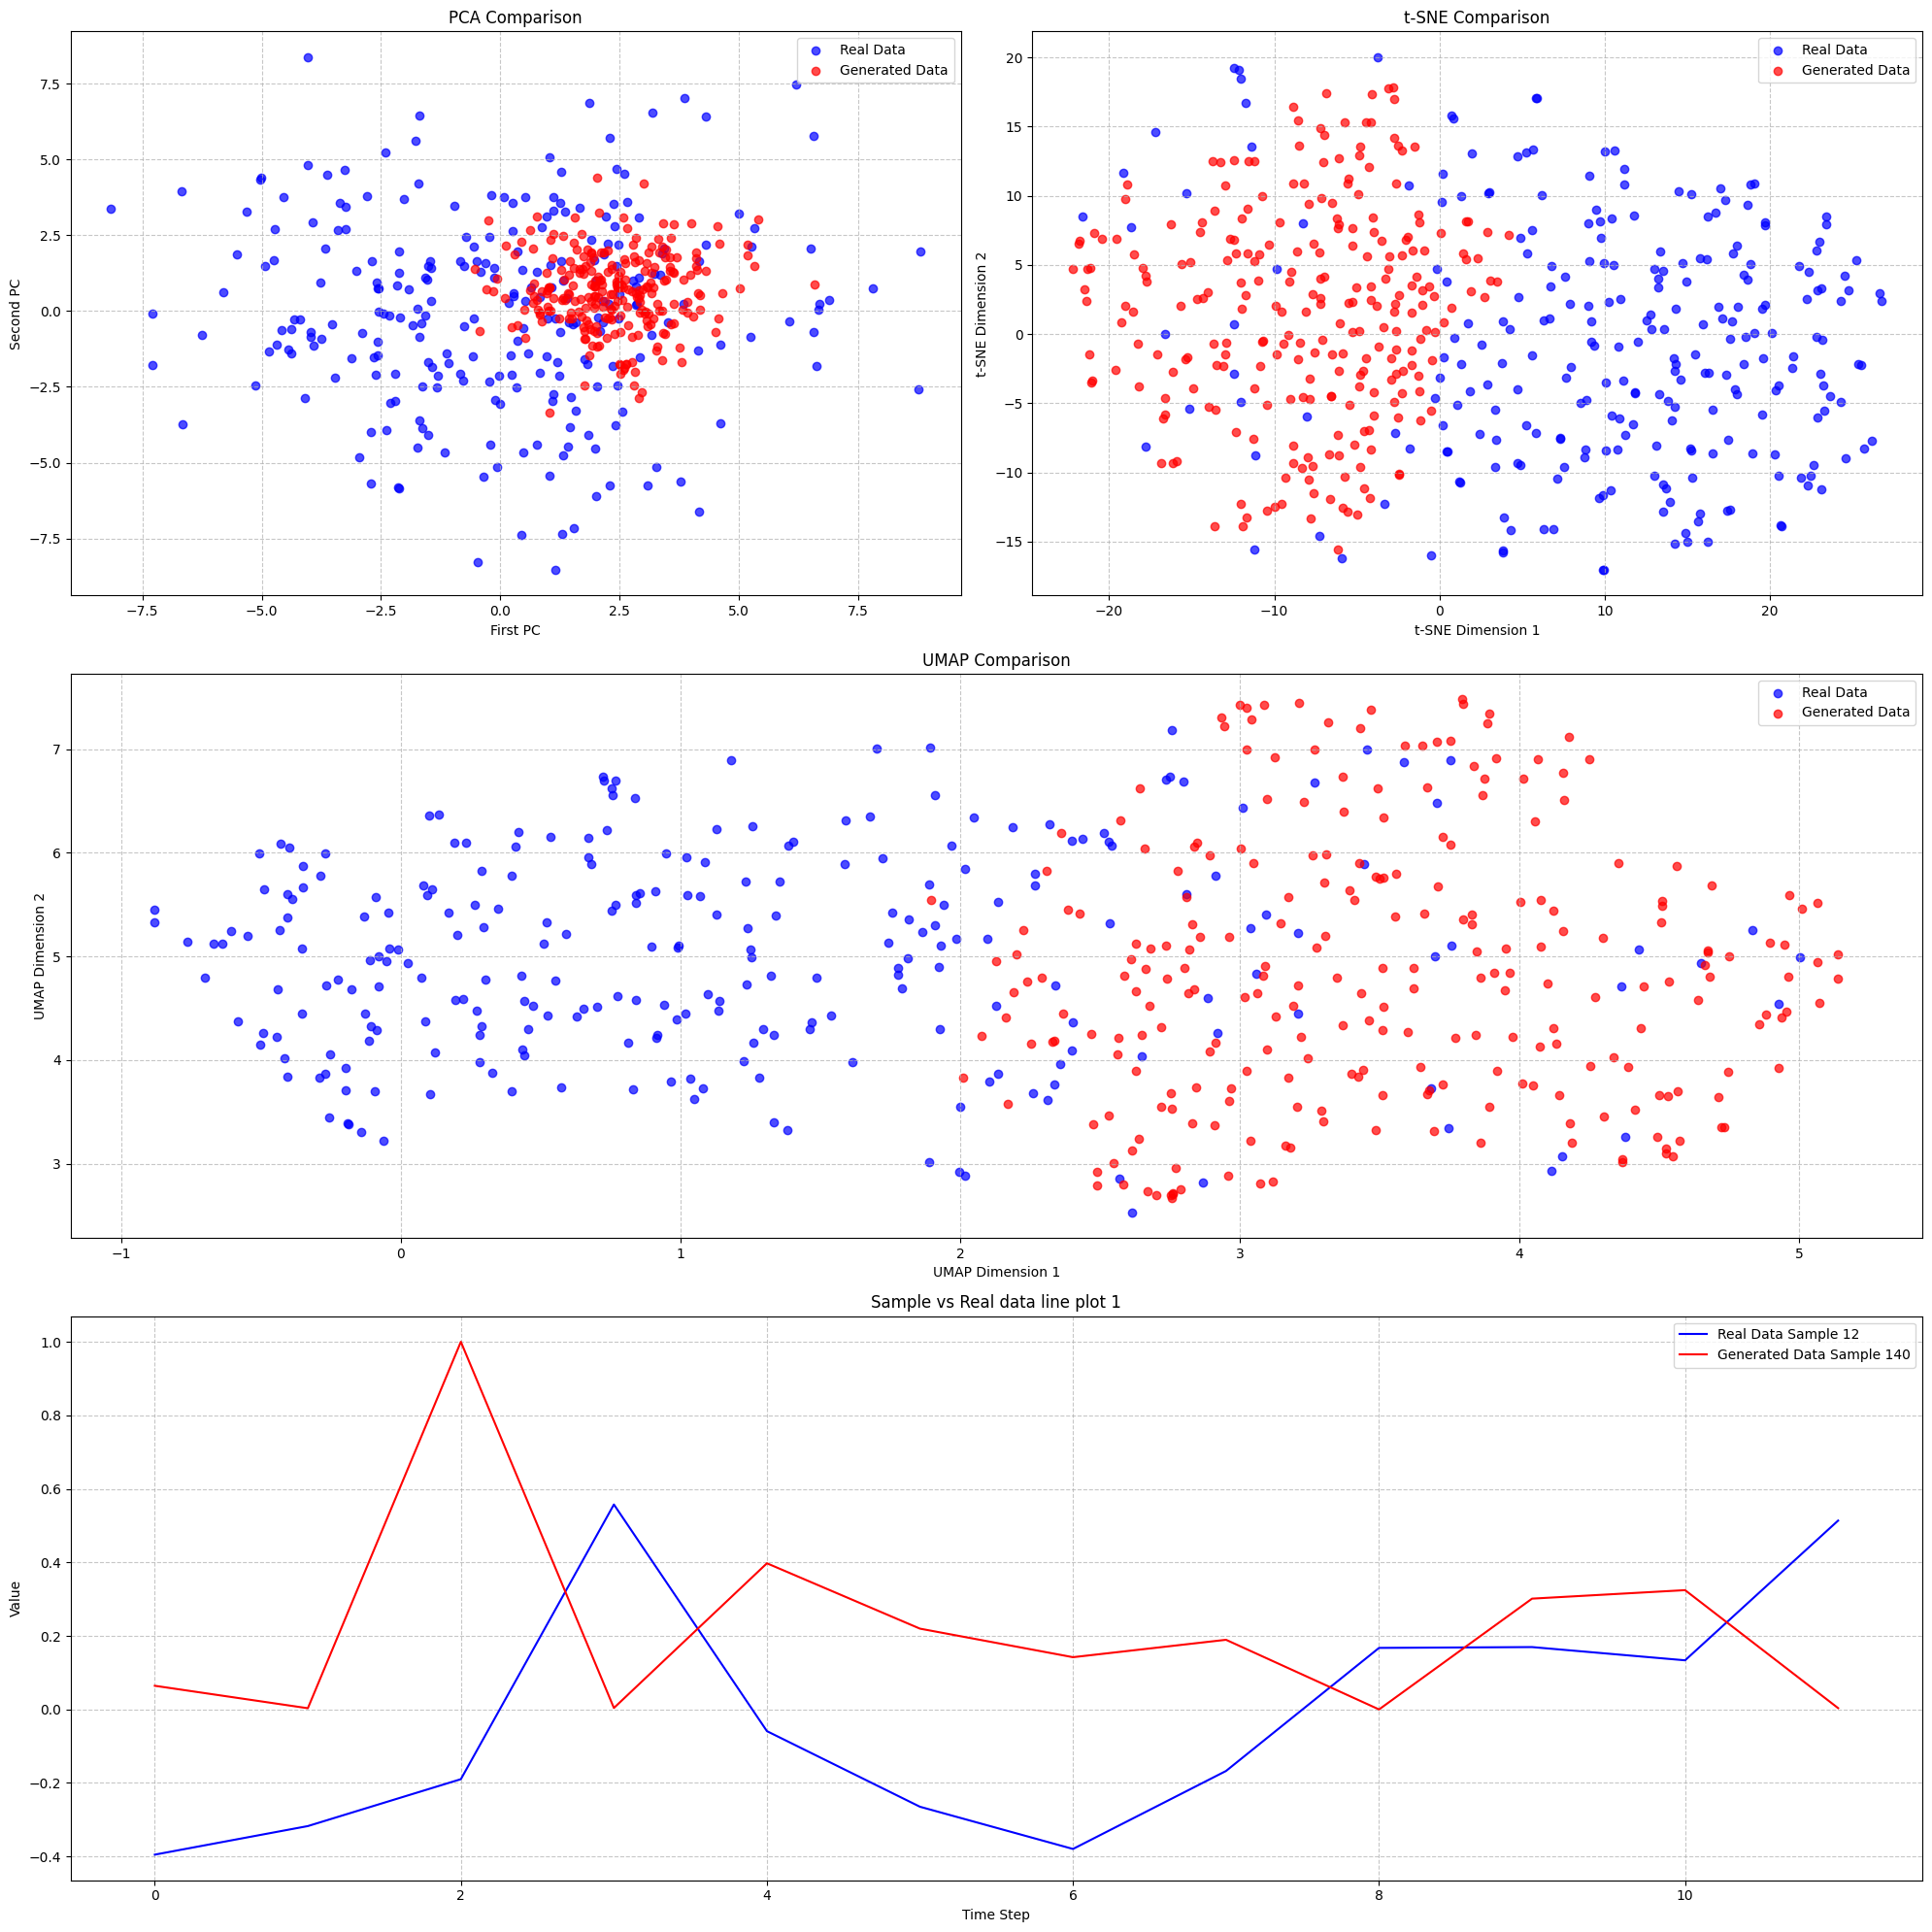

In [12]:
visual_evaluation(real_data_train, samples, log_file_name, False, "train")

### Test

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


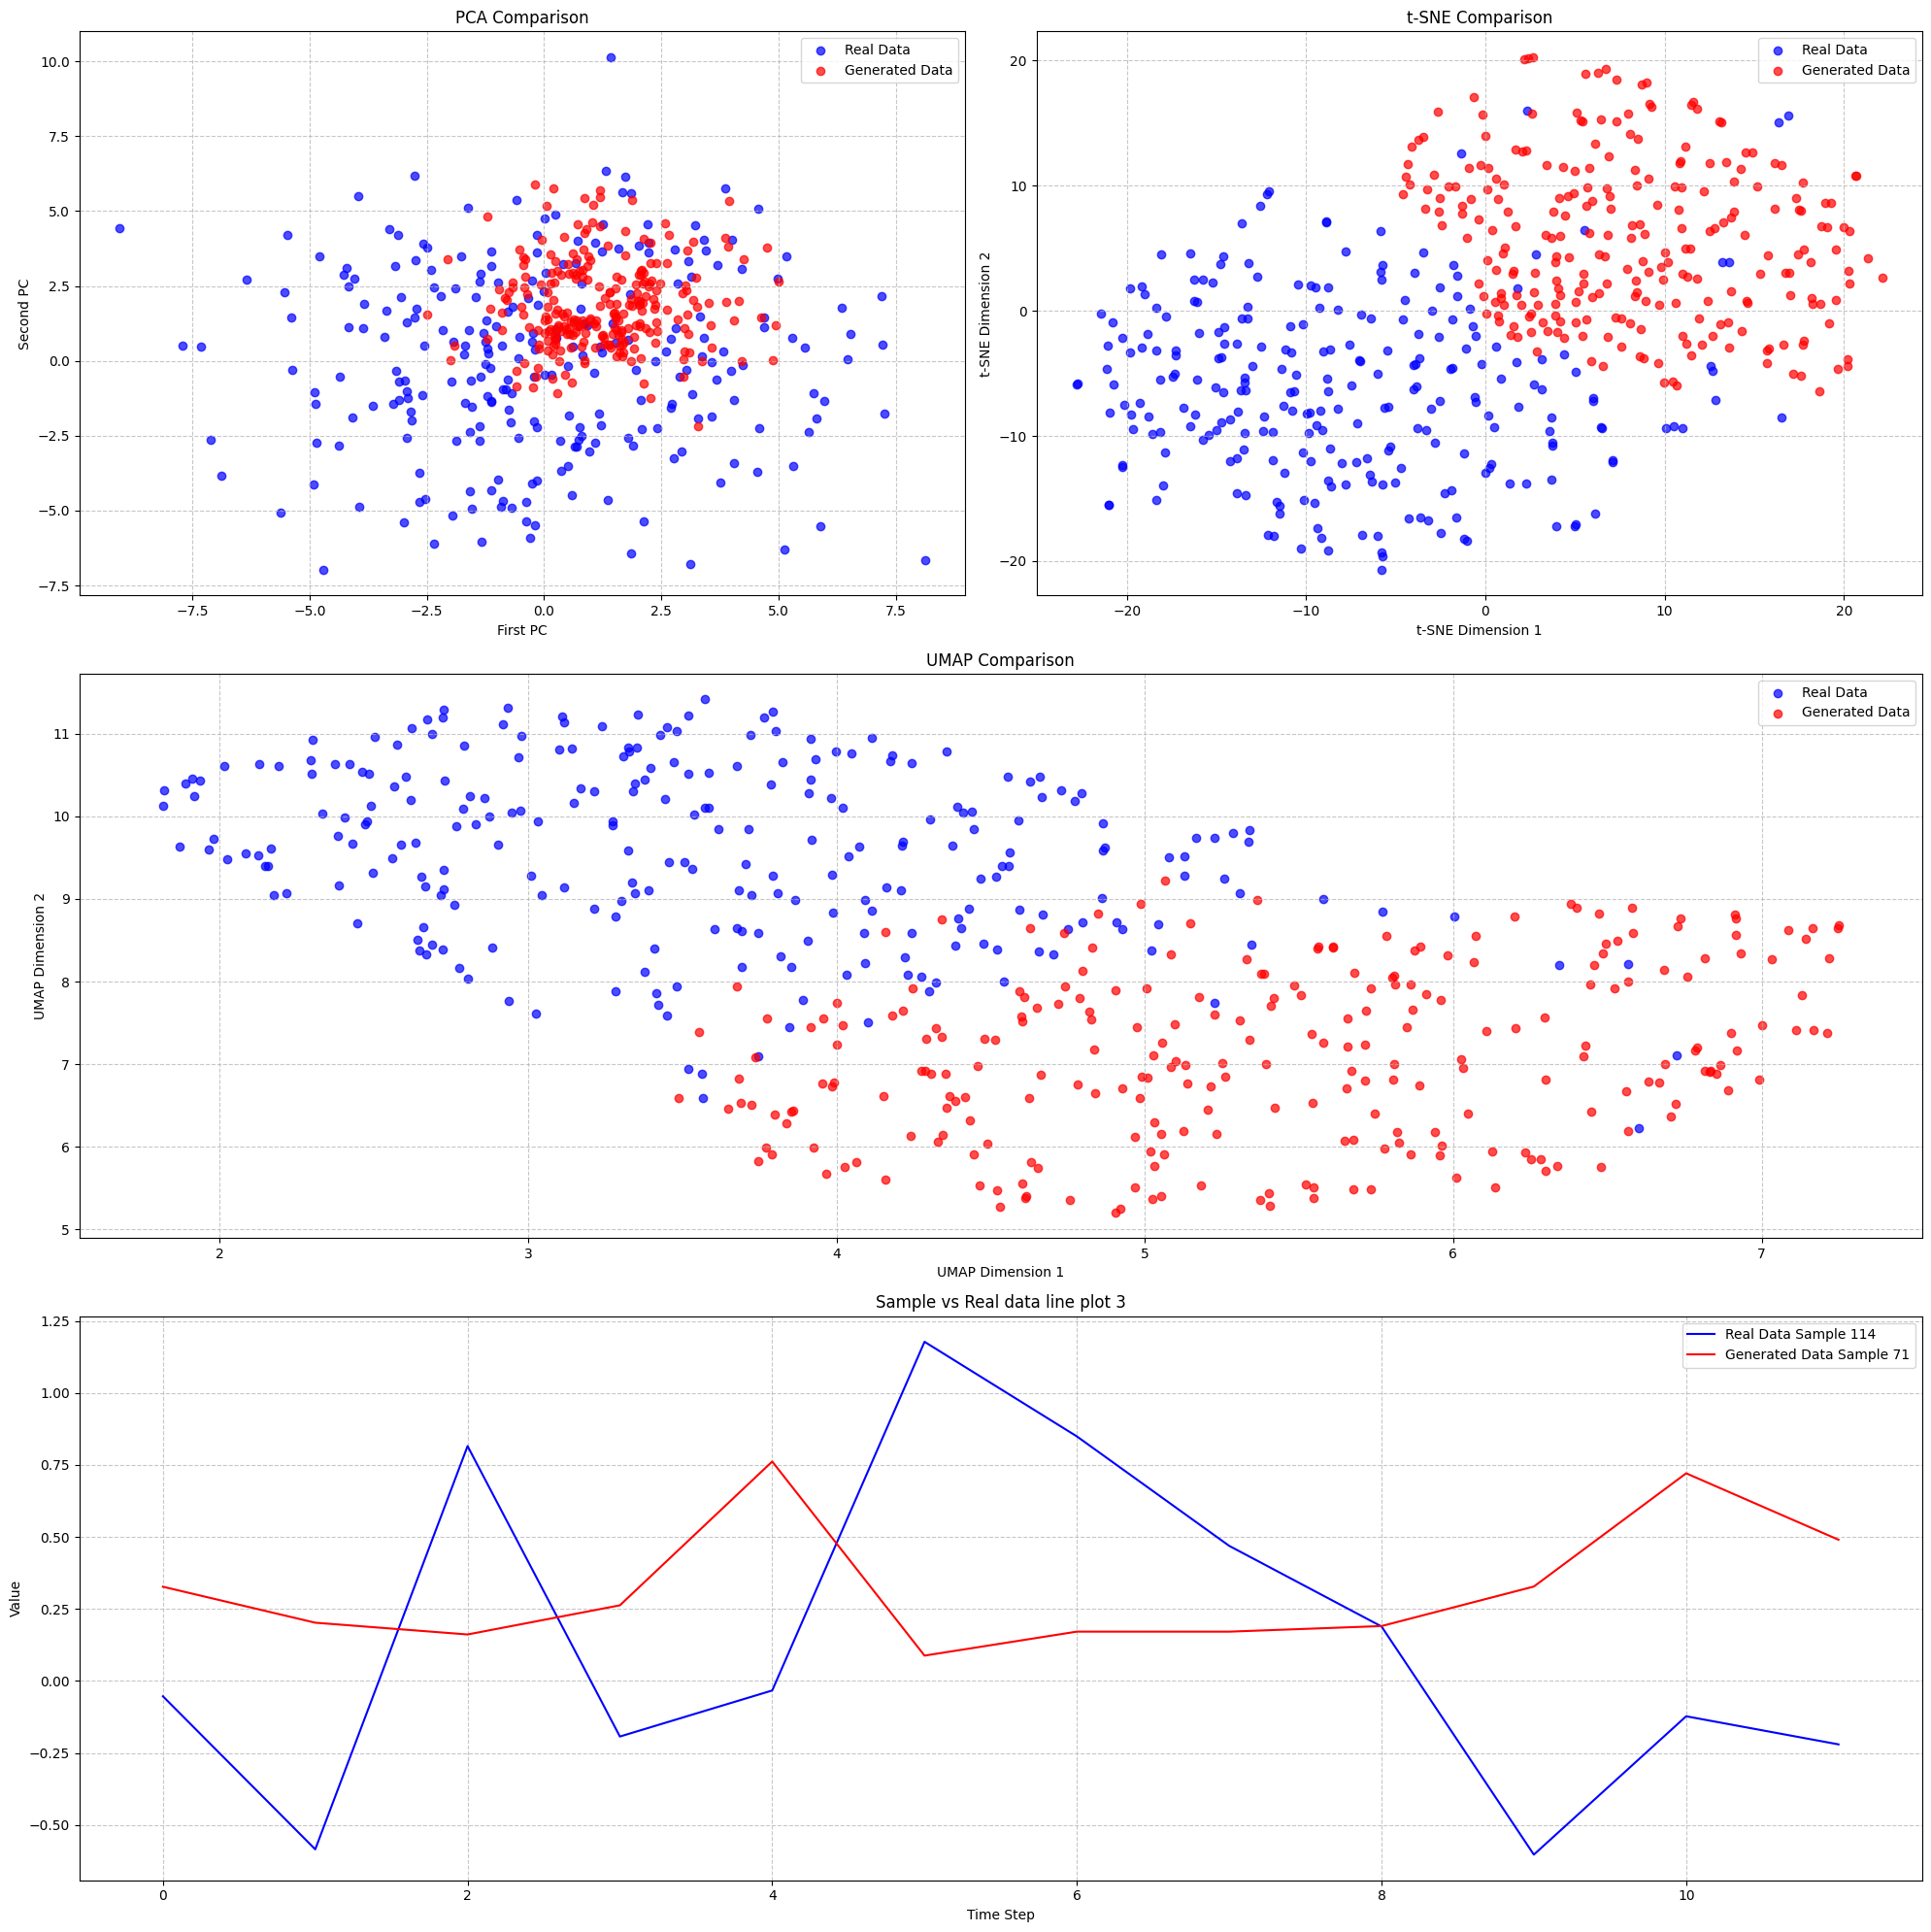

In [13]:
visual_evaluation(real_data_test, samples, log_file_name, False, "test")

### Jensen-Shannon Divergence

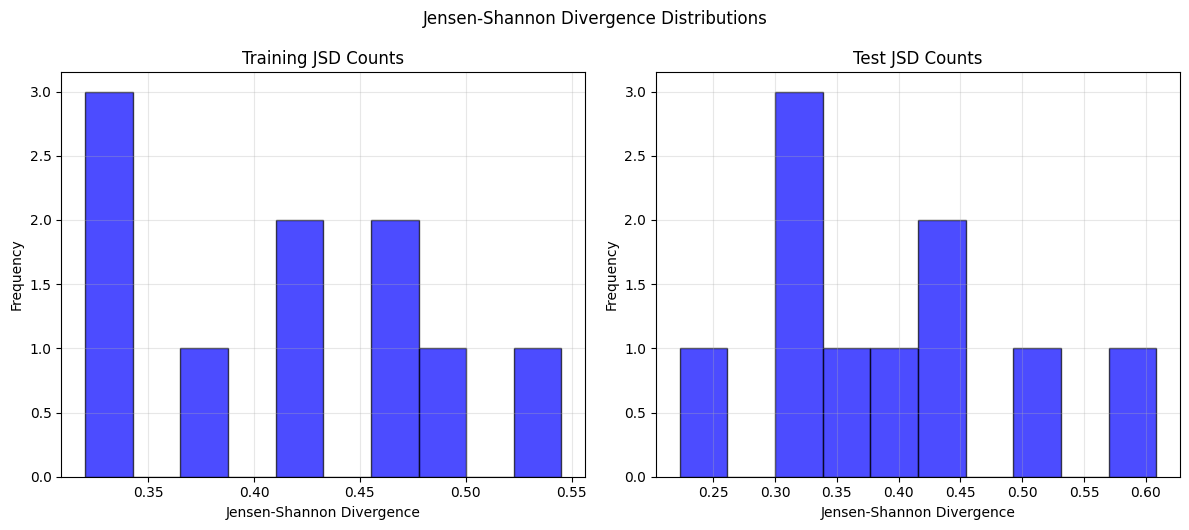

In [14]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

## With Conditioning

In [15]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()

print(f"Samples shape: {cond_samples_train.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 180.66it/s]

Samples shape: (256, 10, 12)


## Train

### T-SNE and PCA

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


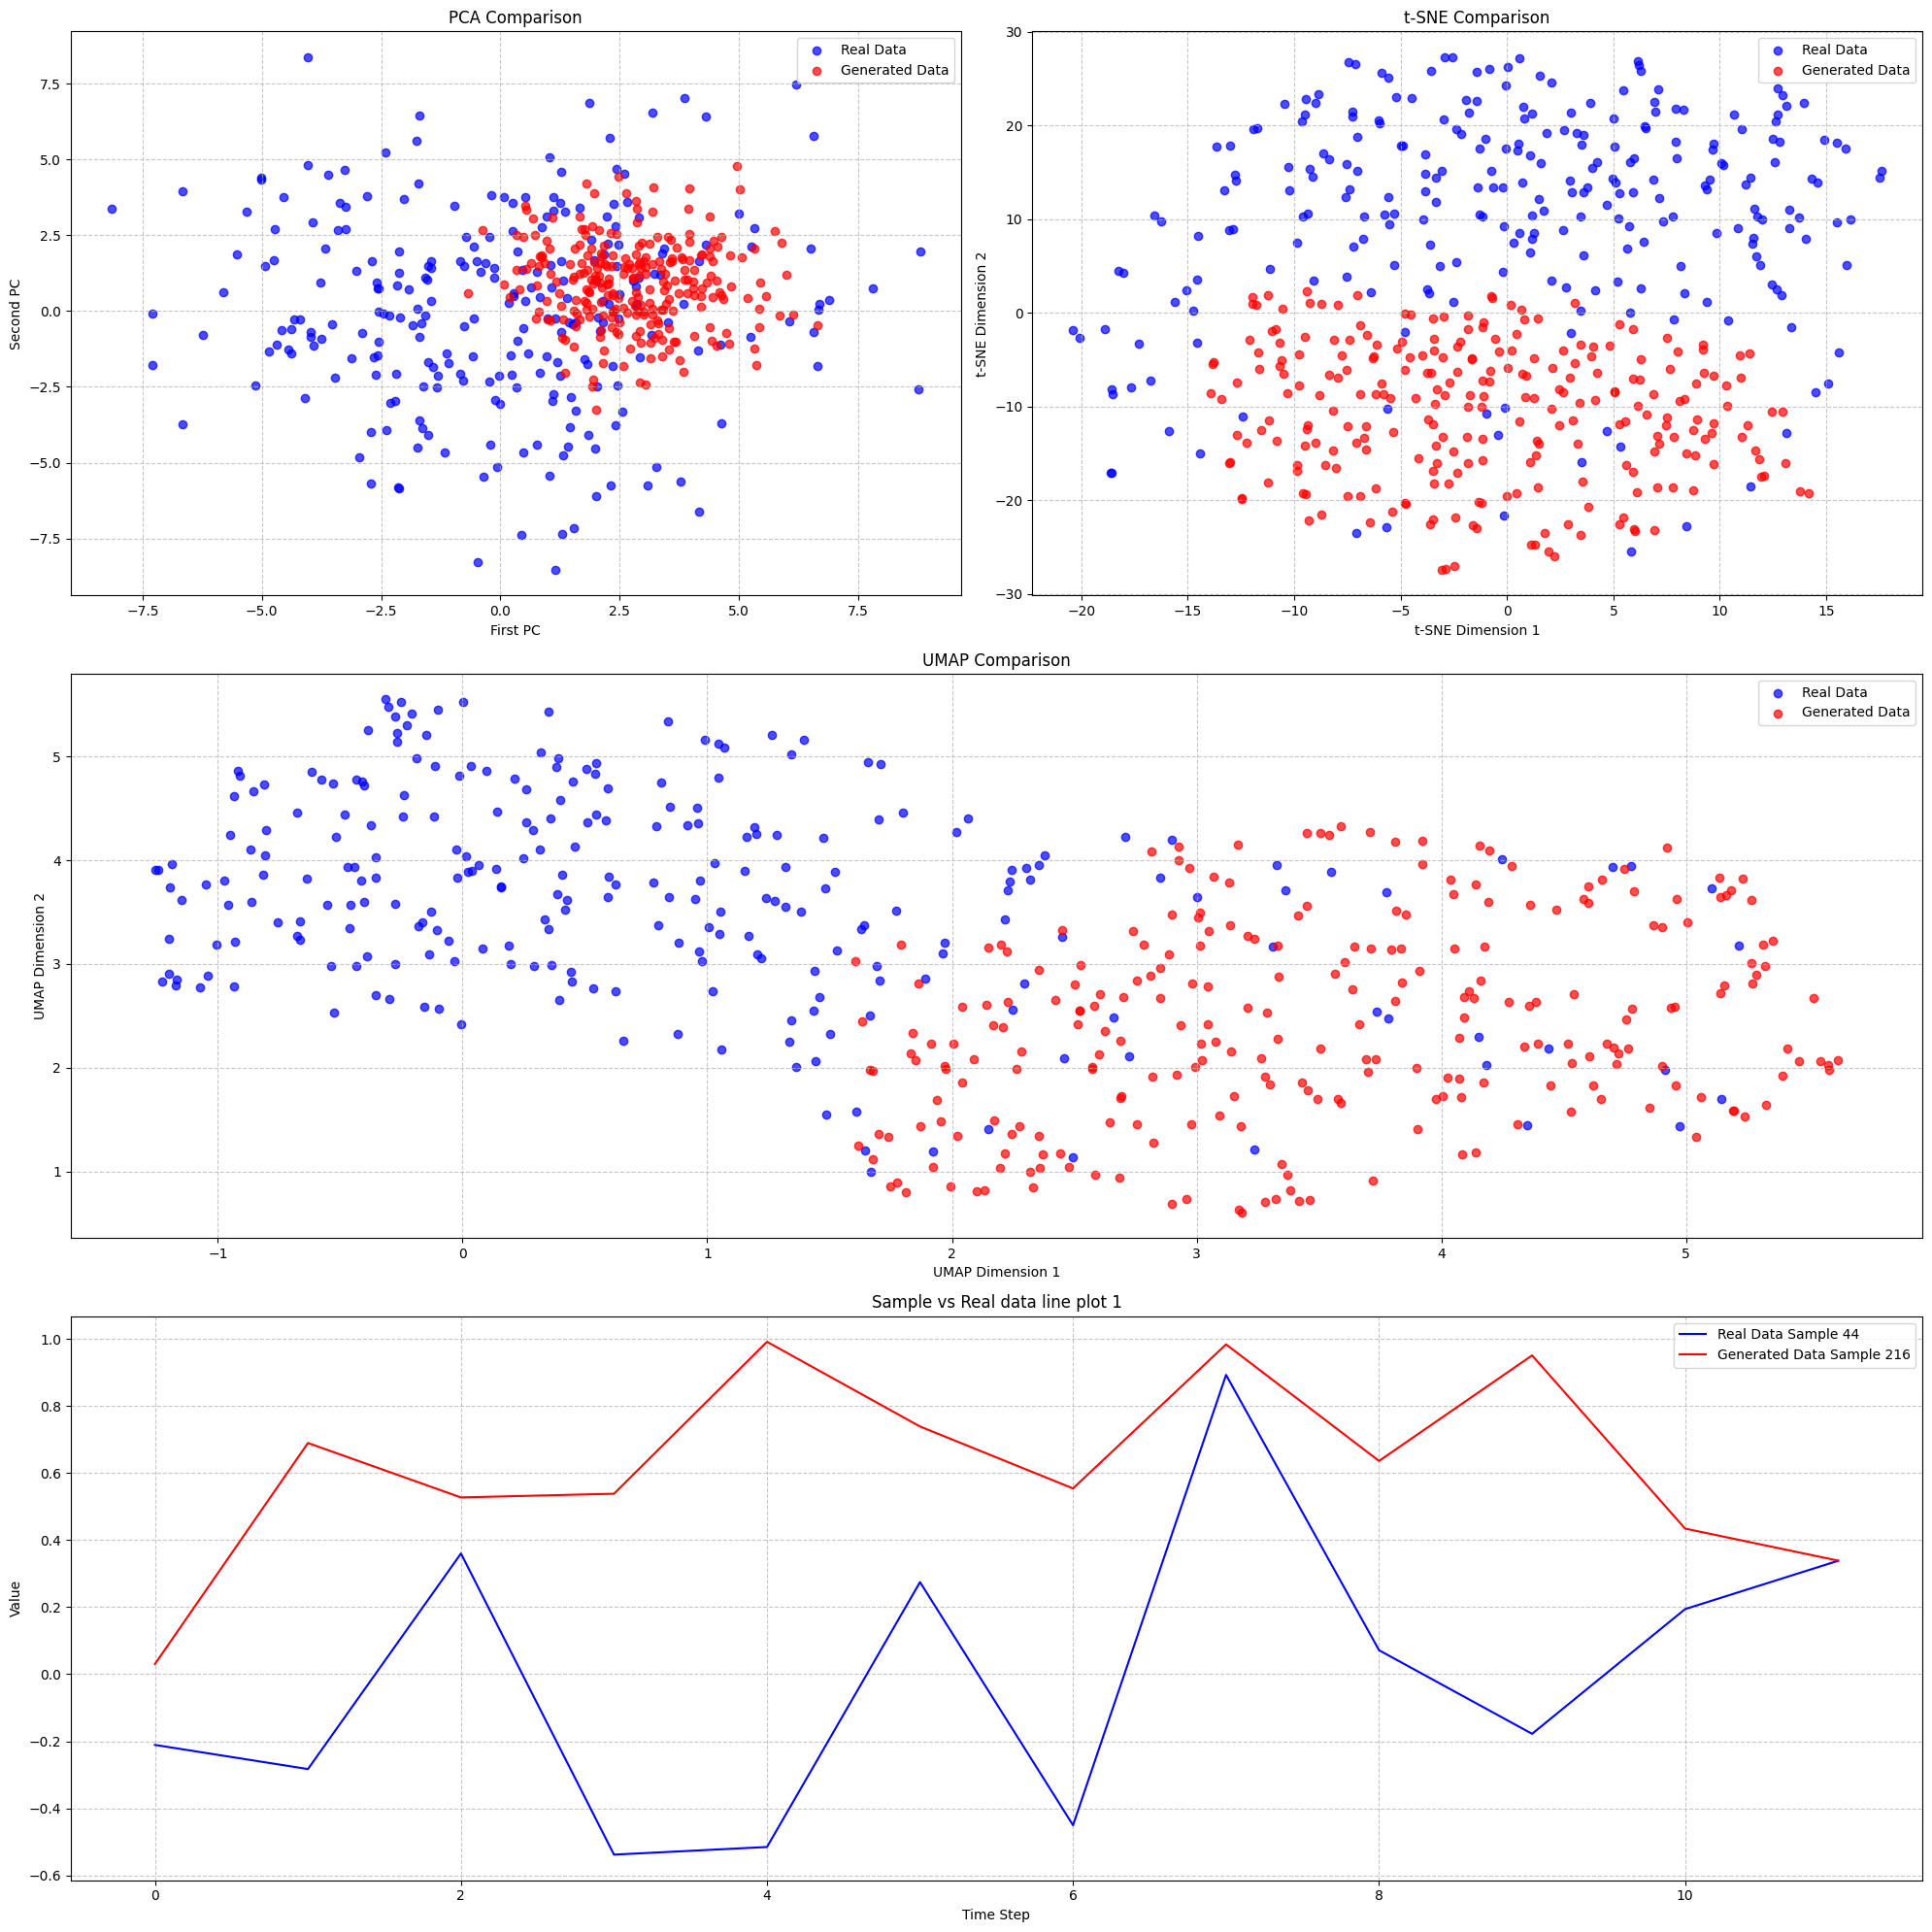

In [16]:
visual_evaluation(real_data_train, cond_samples_train, log_file_name, True, "train")

### Jensen-Shannon-Divergence

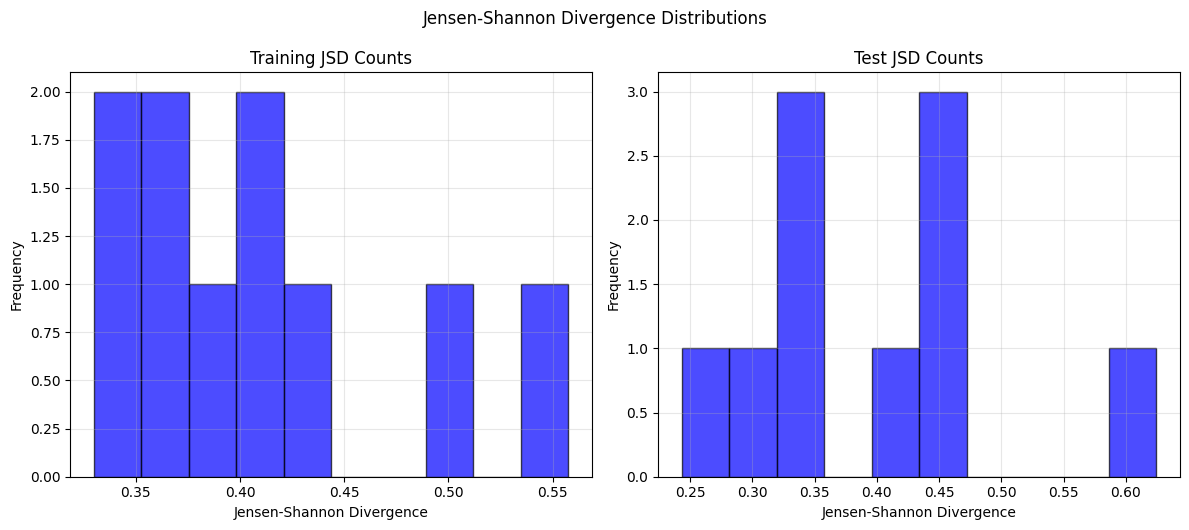

In [17]:
plot_jsd(real_data_train, real_data_test, cond_samples_train.transpose(0,2,1), log_file_name, cond=True)

## Test

In [18]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()

print(f"Samples shape: {cond_samples_test.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 180.98it/s]

Samples shape: (256, 10, 12)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


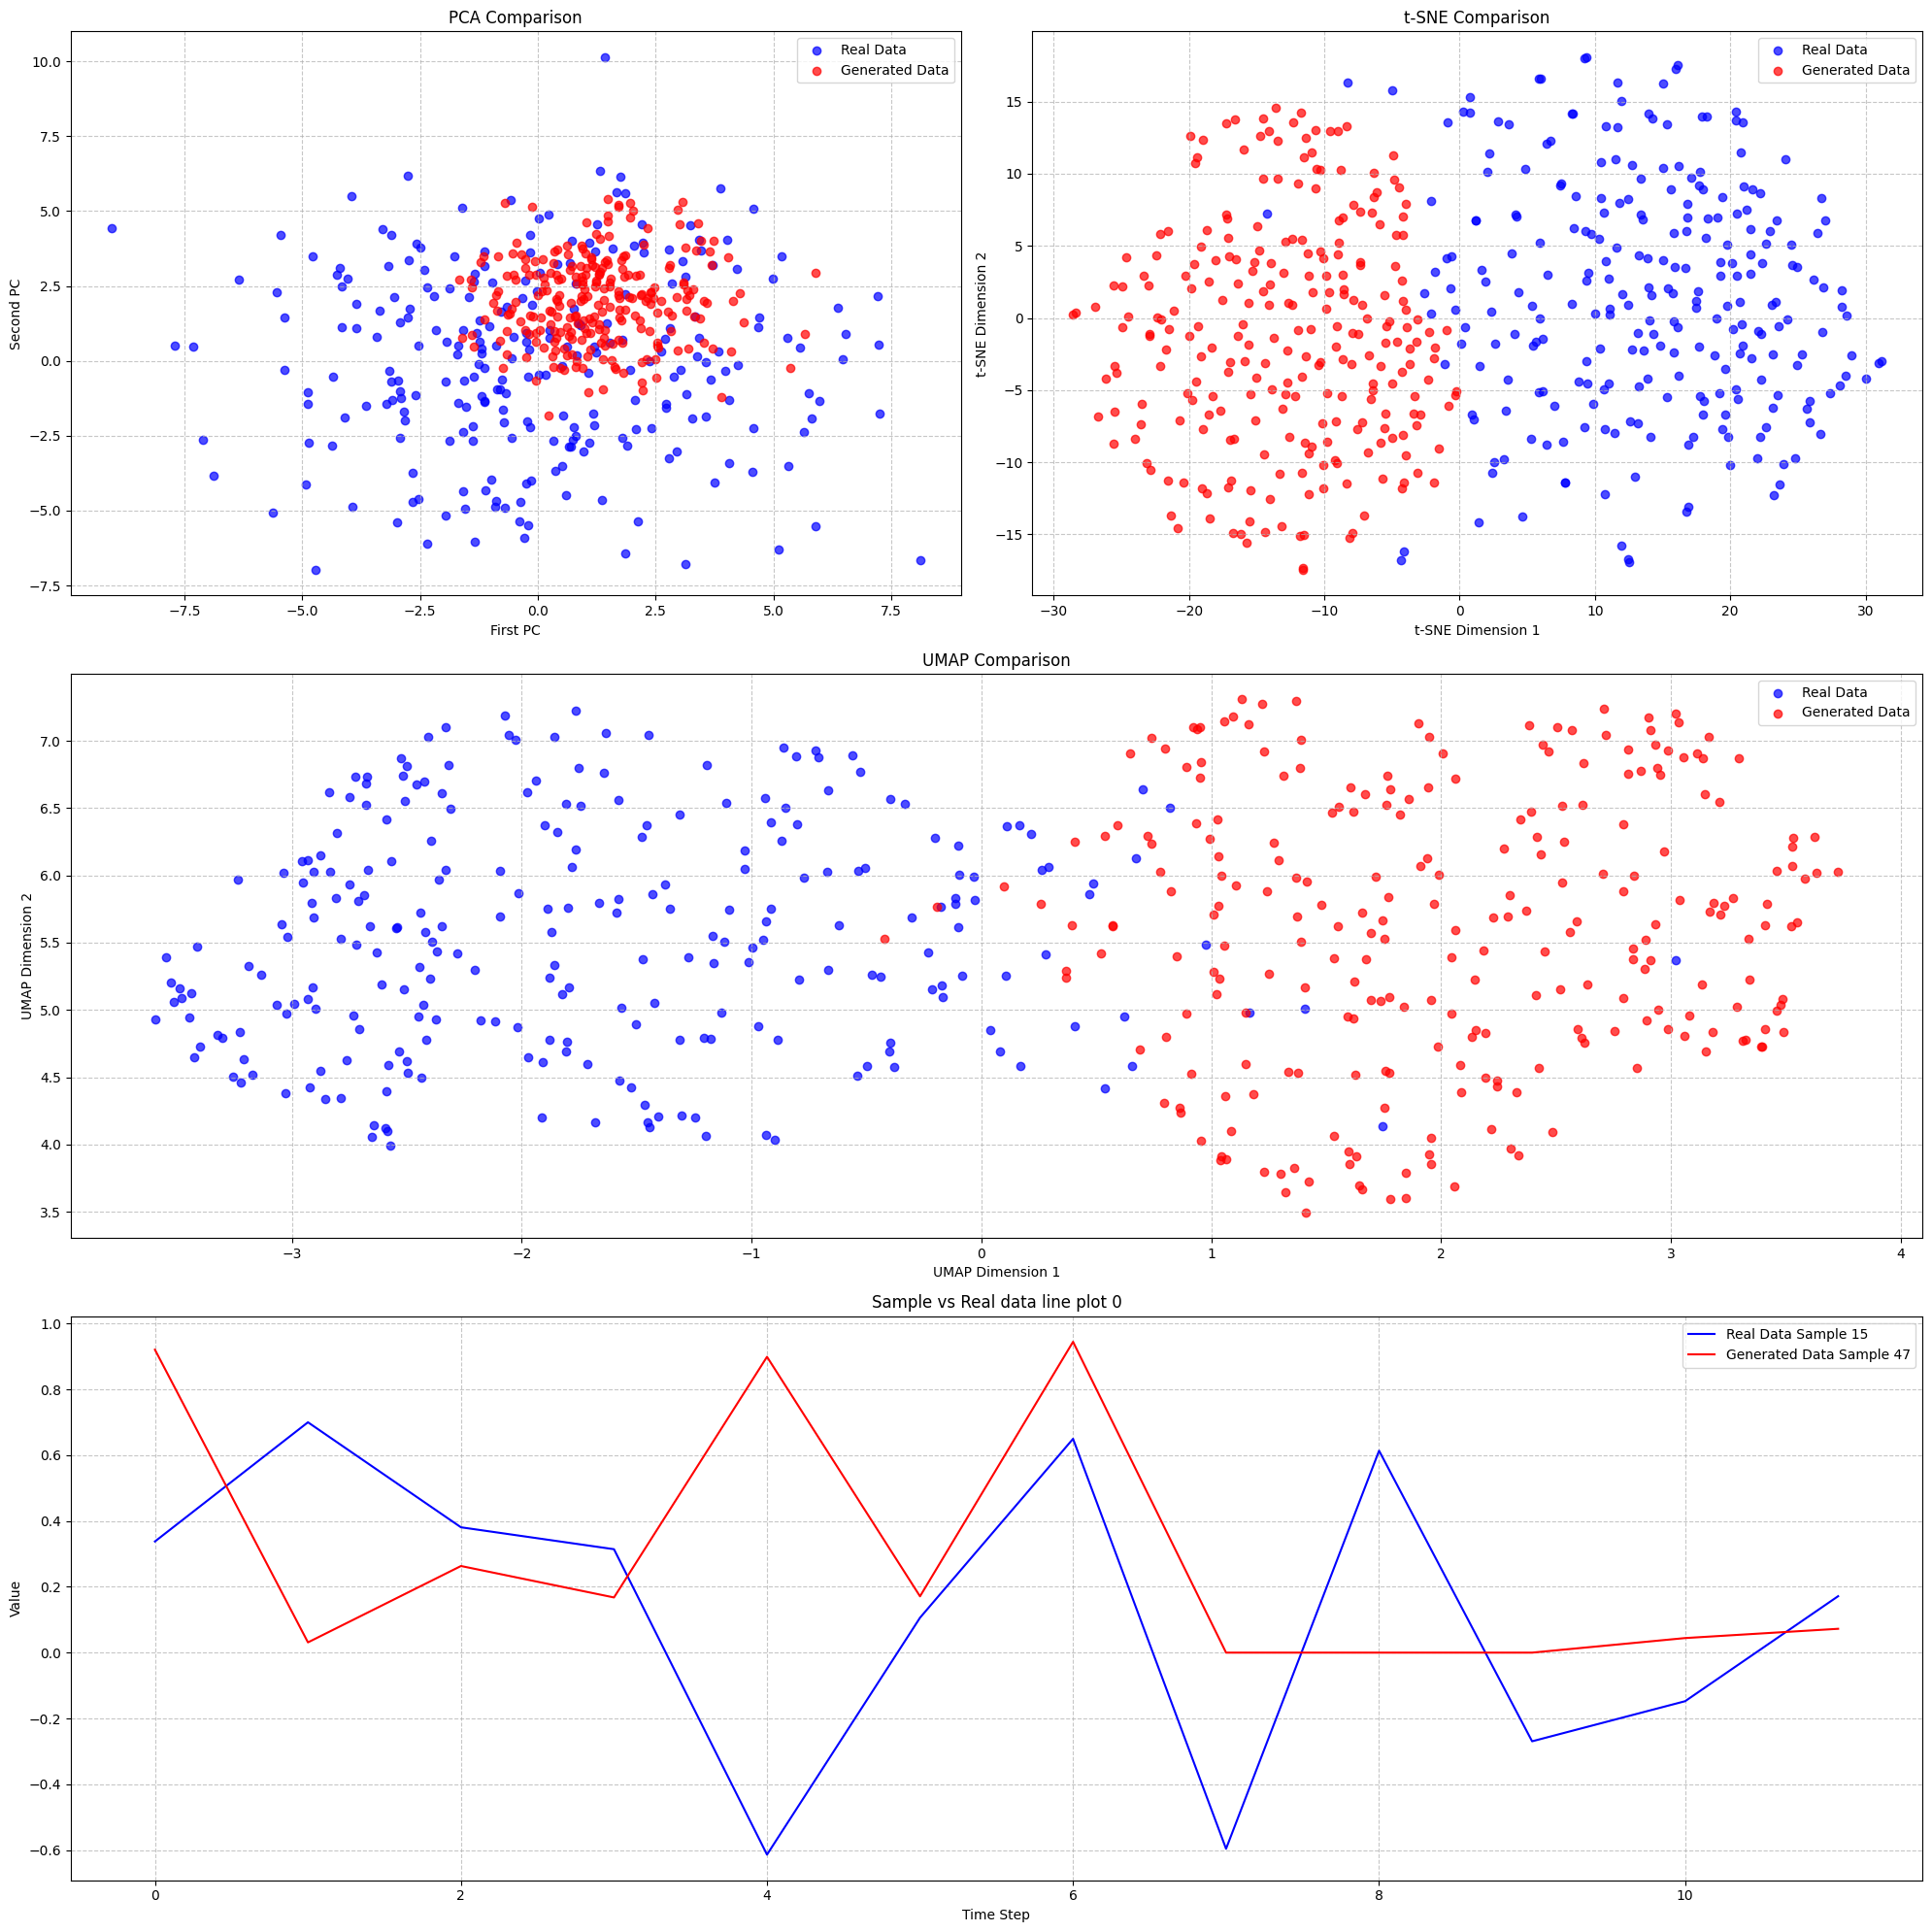

In [19]:
visual_evaluation(real_data_test, cond_samples_test, log_file_name, True, "test")

### Jensen-Shannon Divergence

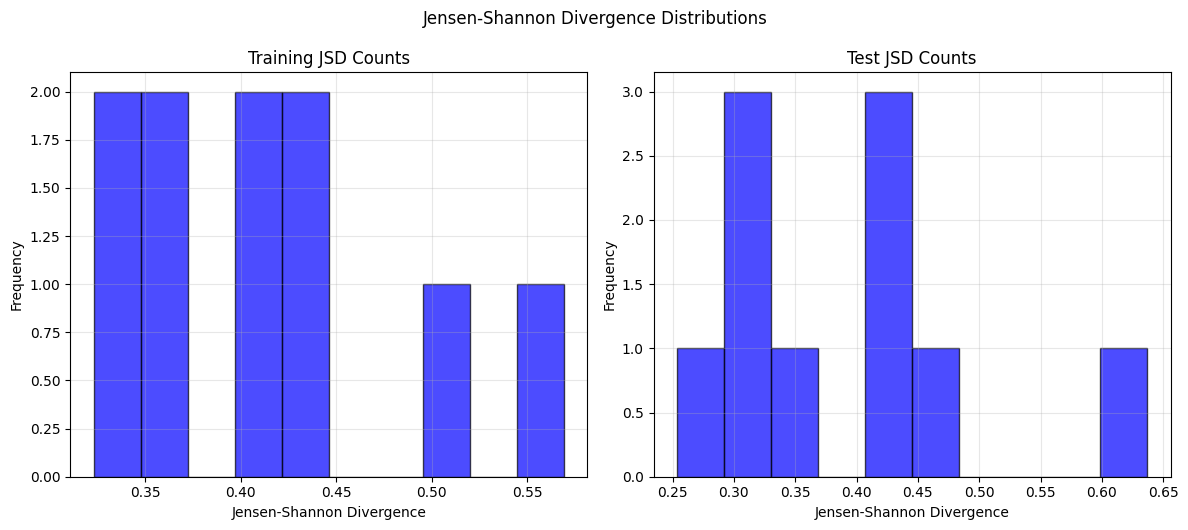

In [20]:
plot_jsd(real_data_train, real_data_test, cond_samples_test.transpose(0,2,1), log_file_name, cond=True)

# Logging

In [21]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\n\nRMSE Values:\n")
    for rmse in rmse_list:
        log_file.write(f"{rmse}\n")

print(f"Log file created at: {log_file_path}")

Log file created at: ./logging/logs\TransEncoder_mlp_2025-03-27-19-29.txt
